# Title

## Setting up the data

First we need to import all the relevant libraries as well as set up the data.

In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from AUS_Functions import *
from shapely.geometry import Polygon, MultiPolygon
import re
import joblib

In [2]:
sns.set()
colors = {
    "blue": "#4C72B0",
    "orange": "#DD8452",
    "green": "#55A868",
    "red": "#C44E52",
    "grey": "#8C8C8C",
    "black": "#000000",
    "blue_transparent": "#4C72B080"
}


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.metrics import r2_score, recall_score, precision_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.pipeline import Pipeline as skl_pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    OrdinalEncoder,
    OneHotEncoder,
)
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor

import statsmodels.api as sm
from autofeat import AutoFeatClassifier
from sklego.meta import Thresholder



In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
    RandomForestRegressor,
)
import xgboost as xg

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    OrdinalEncoder,
    OneHotEncoder,
)

from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, roc_curve


from sklego.meta import Thresholder
import optuna
import shap

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

Since the three tasks we want to accomplish use different datasets and features in those datasets, I've split the EDA into several parts to cover only the relevant datasets and columns to the task at hand.

Data relevant to our task is split into two datasets - one containing rejected and the other containing accepted loan applications. So before we can properly do EDA, we must combine the datasets together. 

Let's take a look at the rejected data first.

In [ ]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


The dataset is quite large - there are more than 27 million entries. Taking up 2 GB of RAM, it's more than my computer can easily process. Let's see how best should we go about sampling the dataset.

In [ ]:
df.isnull().sum()

Amount Requested               0
Application Date               0
Loan Title                  1303
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

We can see that there are quite a lot of missing values, especially for the "risk_score" feature. A good first step at getting a smaller dataset could be dropping the rows with missing values. However, we need to be careful with doing that - since about 2/3 of the whole dataset has missing values, by dropping them we could heavily alter the natural distributions for the features, especially, if the values are not missing completely at random.

To check, we will compare samples from untouched data and from data with dropped missing values.

In [ ]:
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df_sample = df.sample(frac = 0.1)
df = df.dropna(axis=0)
df = df.sample(frac = 0.25)

df["dropna"] = 1
df_sample["dropna"] = 0
df = pd.concat([df, df_sample])
df = df.reset_index(drop=True)
del(df_sample)

df.head()

amount_requested application_date               loan_title  risk_score  \
0            2500.0       2018-06-16                    Other       572.0   
1           15000.0       2017-10-16       Debt consolidation       624.0   
2            5000.0       2017-11-20  Credit card refinancing       653.0   
3           10000.0       2016-11-17                 Business       557.0   
4           30000.0       2017-07-03  Credit card refinancing       606.0   

  debt_to_income_ratio zip_code state employment_length  policy_code  dropna  
0                   0%    183xx    PA           3 years          0.0       1  
1               69.61%    748xx    OK          < 1 year          0.0       1  
2                35.8%    076xx    NJ          < 1 year          0.0       1  
3               22.62%    945xx    CA          < 1 year          0.0       1  
4              127.04%    350xx    AL          < 1 year          0.0       1

Differences in distributions for most features were miniscule, except for the "application_date".

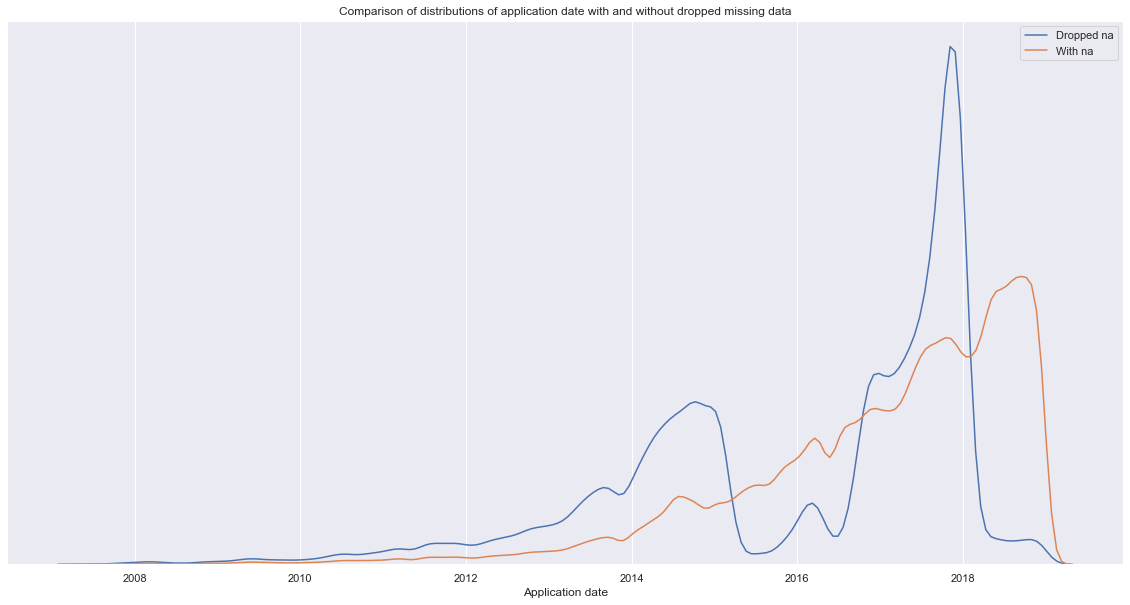

In [ ]:
df["application_date"] = pd.to_datetime(df["application_date"])
df["month"] = df["application_date"].dt.month

plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="dropna",
    palette=[colors["orange"], colors["blue"]],
    common_norm=False
)
plt.legend(labels=["Dropped na", "With na"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_title("Comparison of distributions of application date with and without dropped missing data")
ax.set_yticks([])

plt.show()

There seems to be a lot of missing data in 2015, 2016 and 2019.

Let's check the difference for the data split by month - one of the most likely ways we might use the application_date feature.

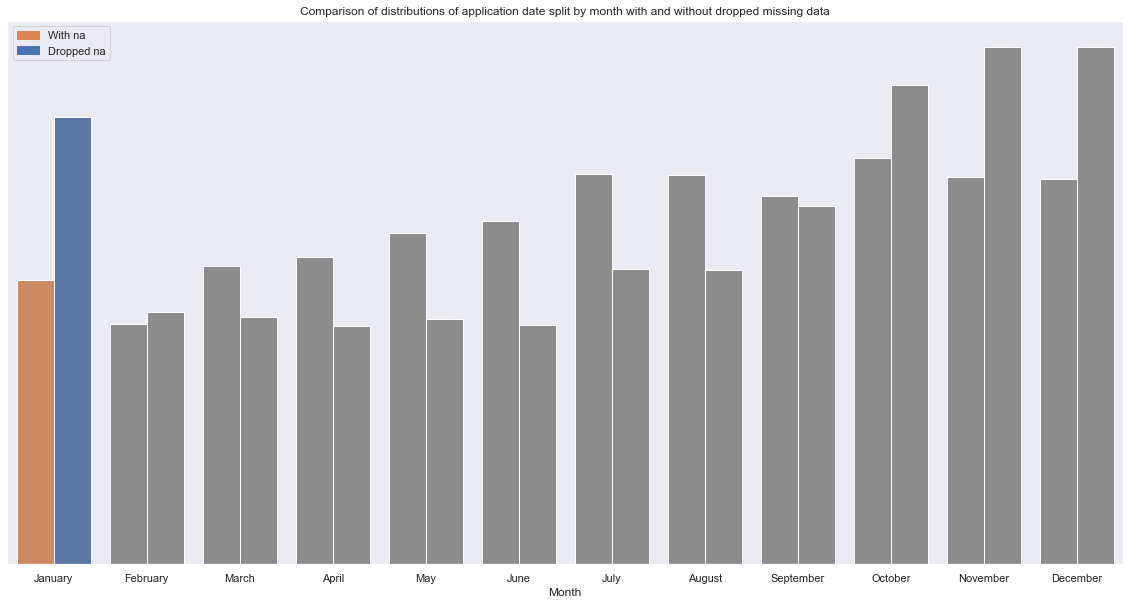

In [ ]:
df_month = df.loc[:, ["month", "dropna", "policy_code"]]
df_month.index.name = "id"
months_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
df_month["month"] = df_month["month"].replace(months_dict)
df_month["month"] = pd.Categorical(df_month["month"], categories=list(list(months_dict.values())))

draw_comparison_barplot(df_month, "dropna", "month", ["January"], ["Comparison of distributions of application date split by month with and without dropped missing data", "Month", "", "With na", "Dropped na"], mode="proportion", y_labels=False)

We can see that there is quite a pronounced difference in some months - the most extreme being in January.

Before we proceed let's quickly compare the date and month data between accepted and rejected datasets - to see how important the feature might be for discerning between the two.

In [ ]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()
df = df.sample(frac = 0.1)

df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

df["accepted"] = 0
df2["accepted"] = 1
df = df.loc[:, ["application_date", "accepted"]]
df2 = df2.loc[:, ["issue_d", "accepted"]]
df2 = df2.rename(columns={"issue_d":"application_date"})

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

df["application_date"] = pd.to_datetime(df["application_date"])
df = df.dropna(axis=0)
df["month"] = df["application_date"].dt.month
df["month"] = df["month"].replace(months_dict)
df["month"] = pd.Categorical(df["month"], categories=list(list(months_dict.values())))

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11664\1051733384.py:5: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


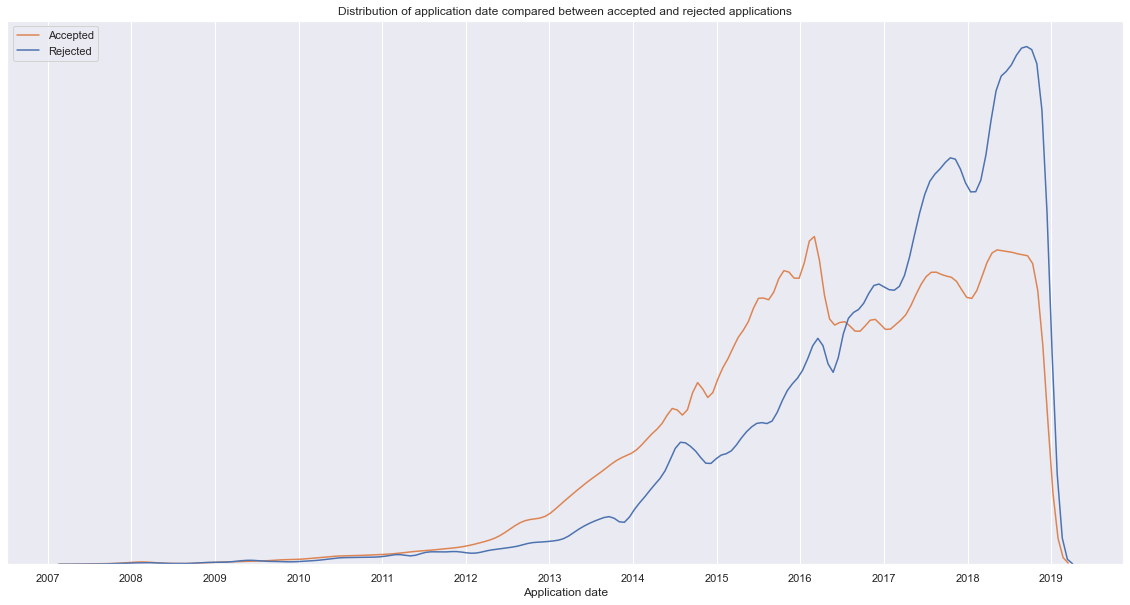

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="accepted",
    palette=[colors["blue"], colors["orange"]],
    common_norm=False
)
plt.legend(labels=["Accepted", "Rejected"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_xticks(pd.to_datetime([str(2007 + x) for x in range(13)]))
ax.set_xticklabels([2007 + x for x in range(13)])
ax.set_title("Distribution of application date compared between accepted and rejected applications")
ax.set_yticks([])

plt.show()

We can see that something must have happened to the market in 2016 (perhaps the (stock market crash due to Brexit?)[https://en.wikipedia.org/wiki/2015%E2%80%932016_stock_market_selloff#:~:text=The%20vote%20led%20to%20stock,dollars%20by%20June%2027%2C%202016.] ) that made applications a lot less likely to be accepted - while the number of rejected applications has continued to grow, the amount of accepted applications hadn't recovered yet in the 2019. Excluding that the distributions seem quite alike.

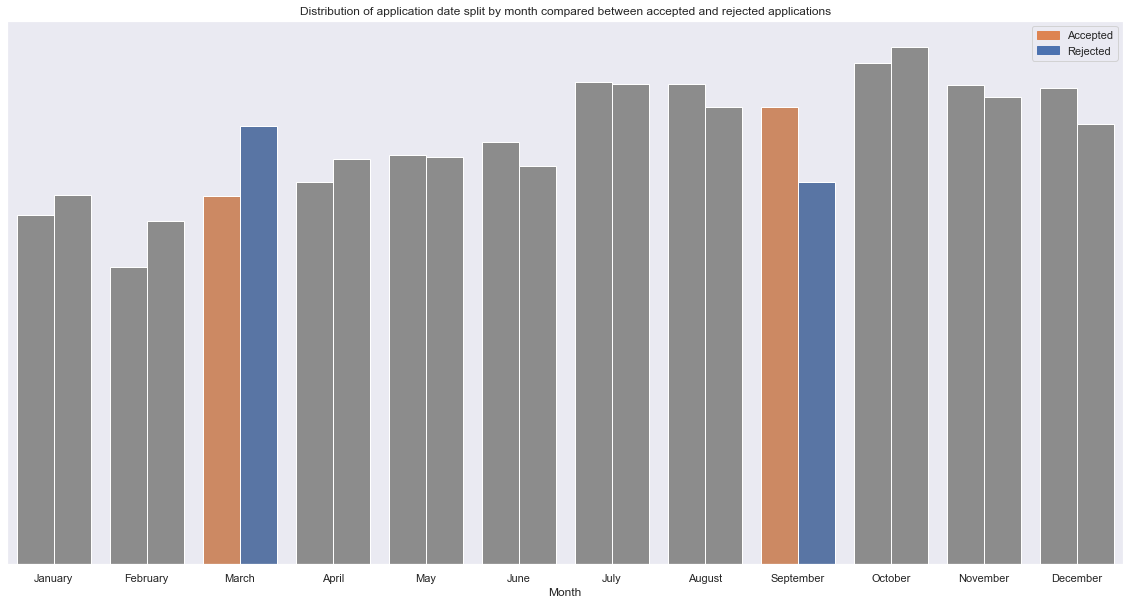

In [ ]:
df.index.name = "id"
draw_comparison_barplot(df, "accepted", "month", ["March", "September"], ["Distribution of application date split by month compared between accepted and rejected applications", "Month", "", "Accepted", "Rejected"], mode="proportion", y_labels=False)

If we look at the difference of distributions between months, there seem to be several that contain different proportion compared to the other distribution. However, if we look at the previous graph, we can attribute the unequal proportions in March to the 2016 crash event. For September a single event is harder to spot, however, there also doesn't seem to be an obvious yearly pattern for it. 

Overall, it seems like date and month data is not that important for the task and we can drop the column and all the rows with missing values. I think that the data we get will be better - since we won't have any missing data to impute and all the entries will contain actual data.

In [7]:
def df2_to_df(df2 : pd.DataFrame) -> pd.DataFrame:
    """
    Function that transforms data from accepted application dataset into similar format to the data in the rejected application dataset.
    """
    df2 = df2.loc[:, ["loan_amnt", "title", "fico_range_low", "fico_range_high", "dti", "zip_code", "addr_state", "emp_length", "loan_status"]]
    df2["risk_score"] = (df2["fico_range_low"] + df2["fico_range_high"])/2
    df2["accepted"] = 1
    df2.loc[df2["loan_status"] == "Charged Off","accepted"] = 2
    df2 = df2.drop(["fico_range_low", "fico_range_high", "loan_status"], axis=1)
    
    df2_name_dict = {
        "loan_amnt":"amount_requested",
        "title":"loan_title",
        "dti":"debt_to_income_ratio",
        "addr_state":"state",
        "emp_length":"employment_length"
    }
    df2 = df2.rename(columns=df2_name_dict)
    return df2

In [8]:
def clean_data(df : pd.DataFrame) -> pd.DataFrame:
    """
    Function that cleans up data for the first task for EDA.
    """
    df["employment_length"] = df["employment_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["employment_length"] = df["employment_length"].str.extract(r"([0-9]+)").astype("float")
    df = df.rename(columns={"employment_length" : "employment_length_years"})
    df["debt_to_income_ratio"] = df["debt_to_income_ratio"].replace("%", "", regex=True).astype(float)
    df["amount_requested"] = df["amount_requested"].astype(int)
    
    df.loc[:, "loan_title"] = df["loan_title"].str.lower().replace("[^a-zA-Z0-9]", " ", regex=True)

    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df

In [9]:
def zip_state_to_coordinates(df : pd.DataFrame) -> pd.DataFrame:
    """
    Function that converts state and zip_code columns into latitude and longitude.
    """
    df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
    df["bin"] = df["zip_code"].str.strip("x") + df["state"]
    df = df.merge(bin_coord_means.reset_index(), on="bin", how="left")
    df = df.merge(state_coord_means.reset_index(), on="state", how="left")
    df["latitude"] = df["latitude"].fillna(df["state_latitude"])
    df["longitude"] = df["longitude"].fillna(df["state_longitude"])
    df.drop(["zip_code", "bin", "state"], axis=1, inplace=True)
    
    return df

In [10]:
def customize_us_shapefile(states : geopandas.GeoDataFrame) -> geopandas.GeoDataFrame:
    """
    Function that customizes us shapefile changing Alaska and Hawaii location for better visualization.
    
    Returns:
        Transformed states shapefile
    """
    states = states.loc[states["STUSPS"].isin(df["state"].unique())]
    states.loc[states["NAME"]=="Alaska", "geometry"] = states.loc[states["NAME"]=="Alaska", "geometry"].scale(0.3, 0.3)
    states.loc[states["NAME"]=="Alaska", "geometry"] = states.loc[states["NAME"]=="Alaska", "geometry"].translate(-10000000, -3000000)
    states.loc[states["NAME"]=="Hawaii", "geometry"] = states.loc[states["NAME"]=="Hawaii", "geometry"].translate(3000000, 1500000)

    alaska = states.loc[states["NAME"]=="Alaska", "geometry"]
    alaska_geom = alaska[47]
    alaska_bool_list = []
    for P in alaska_geom.geoms:
        alaska_bool_list.append(P.bounds[0]< -10000000)
    alaska = alaska.explode(index_parts=True)
    alaska = alaska.reset_index().set_index("level_1")
    alaska = MultiPolygon(list(alaska[alaska_bool_list].geometry))

    states.loc[states["NAME"]=="Alaska", "geometry"] = pd.Series([alaska]).values
    
    return states

In [11]:
def draw_usa(df, column, title, legend=True) -> None:
    """
    Draws the map of USA, with the states colored in different intensity given by the "column" attribute in the "df".
    
    Parameters:
        df(pd.DataFrame): A dataframe containing data for plotting
        column(str): Name of the column containing data for state color intensity
        title(str): Contains the title for the graph
        legend(bool): Toggle for the legend explaining the colors. Default is "True"

      Returns:
        Nothing
    
    """
    ax = df.plot(figsize=(30, 10), column=column, legend=legend)
    ax.plot([-14200000, -14200000], [7000000, 5000000], linewidth=2, color=colors["black"])
    ax.plot([-14200000, -16500000], [5000000, 5000000], linewidth=2, color=colors["black"])
    ax.plot([-14200000, -13500000], [5000000, 3000000], linewidth=2, color=colors["black"])
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

In [12]:
def get_relevant_words(df: pd.DataFrame, target: pd.Series) -> list:
    """
    Function that filters out the words in the "loan_title" whose usage frequency differs between the accepted and rejected applications by at least 1% of total words used count. 
    Also, to prevent multicollinearity in modelling, if words have a correlation higher than 0.7, then only the word with a higher correlation with target column is kept.
    
    Parameters:
        df(pd.DataFrame): A dataframe containing "loan_title" column
        target(pd.Series): A series containing the target data.

      Returns:
        A list containing the filtered words
    """
    word_df = pd.Series([y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]).value_counts().to_frame("total")
    word_df["total"] = (word_df["total"]/word_df["total"].sum()).round(3)
    for index, value in enumerate(["rejected", "accepted"]):
        word_df[value] = pd.Series([y for x in df.loc[target == index, "loan_title"].dropna().values.flatten() for y in x.split()]).value_counts()
        word_df[value] = (word_df[value]/word_df[value].sum()).round(3)

    difference_words = (word_df[np.abs(word_df["rejected"]-word_df["accepted"]) > 0.01]).index.to_list()

    word_df = pd.DataFrame(index=df.index)
    for word in difference_words:
        word_df.loc[df["loan_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), word] = 1
        word_df.loc[:, word] = word_df.loc[:, word].fillna(0).astype(int)

        word_corr = word_df.corrwith(word_df[word])
        multicoll_list = word_corr[(word_corr > 0.7) & (word_corr.index != word)].index.tolist()
        if multicoll_list:
            for multicoll_name in multicoll_list:
                if np.abs(word_df[multicoll_name].corr(target)) < np.abs(word_df[word].corr(target)):
                    word_df = word_df.drop(multicoll_name, axis=1)
                else:
                    word_df = word_df.drop(word, axis=1)
                    break
    return word_df.columns.to_list()

In [13]:
df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')
df2 = df2_to_df(df2)
df2.shape[0]

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


2260701

Dataset containing accepted data has a lot of columns that are not relevant to us and the column names are different than for the rejected data, so we use a custom function that filters out the data that we need and renames the columns.

We can see that accepted dataset has only 2 million entries - a lot less than the rejected dataset even after we've excluded the missing data. To balance out the datasets and make the complete size manageable, we will be sampling the accepted dataset to approximately the same size as the rejected dataset.

In [14]:
df = pd.read_csv('data/rejected_2007_to_2018Q4.csv')
df = df.dropna(axis=0)
df = df.sample(frac = 0.25)
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df["accepted"] = 0
df = df.drop(["policy_code", "application_date"], axis=1)

We also have to drop the "policy code" feature - the feature is related to the action taken ("accepted", "rejected") and thus contains information unknown to us at the moment of prediction.

In [ ]:
df2.isnull().sum()

amount_requested            33
loan_title               23358
debt_to_income_ratio      1744
zip_code                    34
state                       33
employment_length       146940
risk_score                  33
accepted                     0
dtype: int64

We dropped all the missing entries in the rejected dataset, but there are some in the accepted dataset that we will have to deal with.

In [15]:
df2 = df2.drop(df2[df2["amount_requested"].isnull()].index, axis=0)

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

del(df2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   amount_requested      float64
 1   loan_title            object 
 2   risk_score            float64
 3   debt_to_income_ratio  object 
 4   zip_code              object 
 5   state                 object 
 6   employment_length     object 
 7   accepted              int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 275.2+ MB


After combining both the accepted data and the sample from rejected dataset, we get 4.5 million entries. Memory usage is still high due to most of the features having been designated as containing strings, but hopefully with some data cleaning and engineering we'll be able to bring it down.

In [ ]:
df.head()

amount_requested               loan_title  risk_score debt_to_income_ratio  \
0            1000.0  Credit card refinancing       570.0               42.82%   
1           40000.0           Major purchase       751.0                  20%   
2            5000.0       debt_consolidation       579.0               34.92%   
3            1500.0       debt_consolidation       695.0                3.66%   
4            7000.0              credit_card       648.0               20.77%   

  zip_code state employment_length  accepted  
0    902xx    CA          < 1 year         0  
1    773xx    TX          < 1 year         0  
2    754xx    TX          < 1 year         0  
3    954xx    CA          < 1 year         0  
4    891xx    NV          < 1 year         0

We can see that some of the string columns actually contain numeric data - debt_to_income_ratio column contains percentages, while employement_length contains discrete numeric data. We will use a custom function to transform the features to numeric as well as downcast all numeric columns as much as possible to minimize the memory usage of the data. Zip_code also contains numbers, but we will look at it later.

In [16]:
df = clean_data(df)
df_copy = df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amount_requested         int32  
 1   loan_title               object 
 2   risk_score               float32
 3   debt_to_income_ratio     float32
 4   zip_code                 object 
 5   state                    object 
 6   employment_length_years  float32
 7   accepted                 int8   
dtypes: float32(3), int32(1), int8(1), object(3)
memory usage: 176.3+ MB


We can see that memory usage is smaller now.

In [ ]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

amount_requested     risk_score debt_to_income_ratio  \
count    4508717.00000  4508717.00000        4507006.00000   
mean       13843.39351      664.02002             89.50935   
std        10157.07826       77.02917           3986.81006   
min          300.00000        0.00000             -1.00000   
25%         5200.00000      636.00000             10.89000   
50%        10500.00000      675.00000             18.73000   
75%        20000.00000      702.00000             28.43000   
max      1400000.00000      990.00000        3225600.00000   

      employment_length_years       accepted  
count           4361810.00000  4508717.00000  
mean                  4.06340        0.56096  
std                   5.67515        0.60449  
min                   0.00000        0.00000  
25%                   0.00000        0.00000  
50%                   0.00000        1.00000  
75%                   6.00000        1.00000  
max                  15.00000        2.00000

Some of the features - "amount_requested" and "debt_to_income_ratio" seem to be quite heavily right skewed.

In [ ]:
accepted_to_words = {0:"Rejected", 1:"Accepted", 2:"Charged off"}
df["accepted"].value_counts().rename(index=accepted_to_words)

Rejected       2248049
Accepted       1992109
Charged off     268559
Name: accepted, dtype: int64

Our target column - accepted is currently split into 3 values - rejected applications, accepted applications and accepted applications that got charged off. "Charged off" means that the applicator has been negligent to his due payments for long enough that the creditor no longer believes that the debt will be payed and cuts his losses. It might improve our model if we exclude theses failed cases.

Now that we've combined the data and cleaned up the data a bit, let's take a closer look at each of the features.

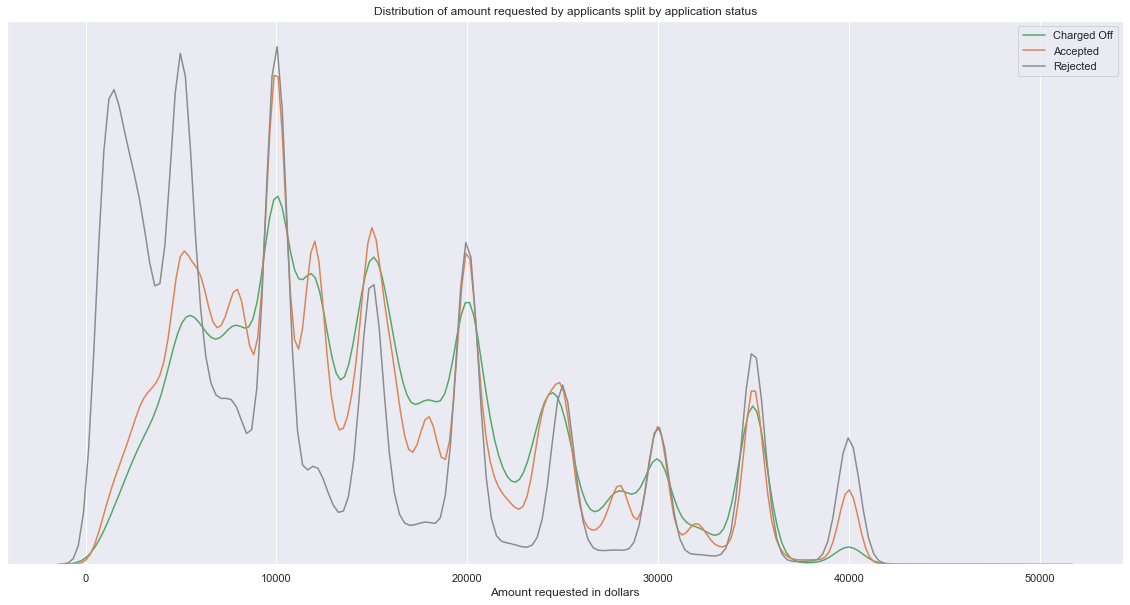

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["amount_requested"]<50000],
    x="amount_requested",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Amount requested in dollars", ylabel="")
ax.set_title("Distribution of amount requested by applicants split by application status")
ax.set_yticks([])

plt.show()

Since amount_requested feature was so heavily skewed, to better see the differences in distributions for the main body of entries, we have excluded the long tail. There is quite a large difference in distributions from 0 to around 7000 dollars with a lot more rejected applications - seems like investors tend to not be interested in lending such small amounts. There doesn't seem to be much of a difference between accepted and charged off applications.

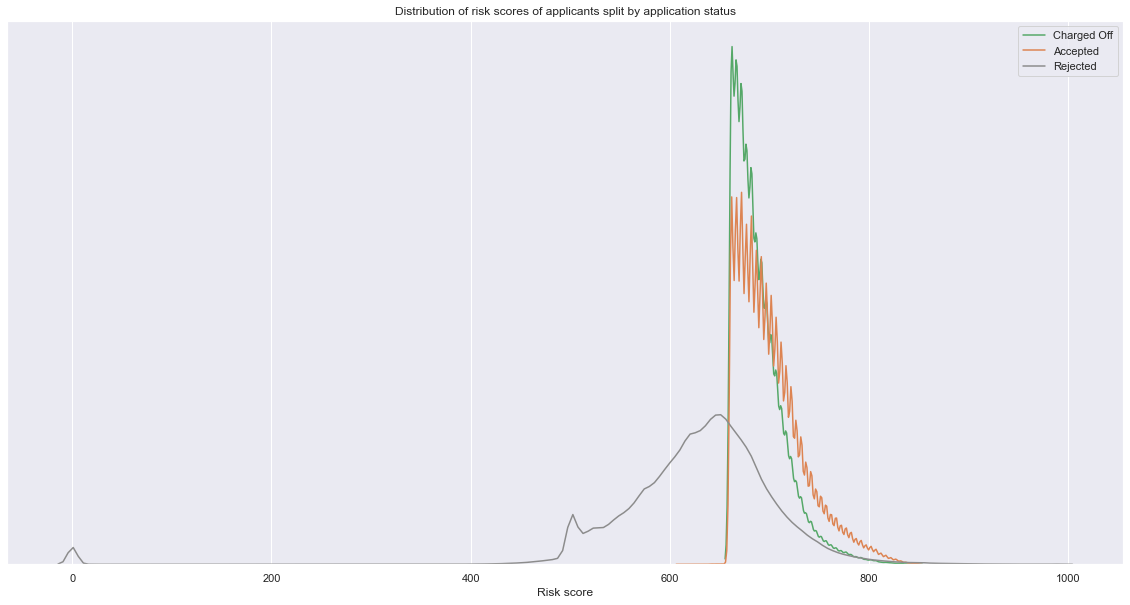

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="risk_score",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [ ]:
df.loc[df["accepted"]==1, "risk_score"].sort_values().quantile(0.0001)

647.0

For the risk_score feature we can see that the distributions are quite different. For accepted aplications there are basically no entries under risk score of 647, while the rejected values range from 400 up to over 800. Charged off entries tend to also have a smaller risk score than other accepted entries. Also there seem to be a number of entries with risk score 0 - since 0 is an invalid value for risk score, most likely given to an applicant that hasn't had his risk score measured, we'll have to treat them as missing values.

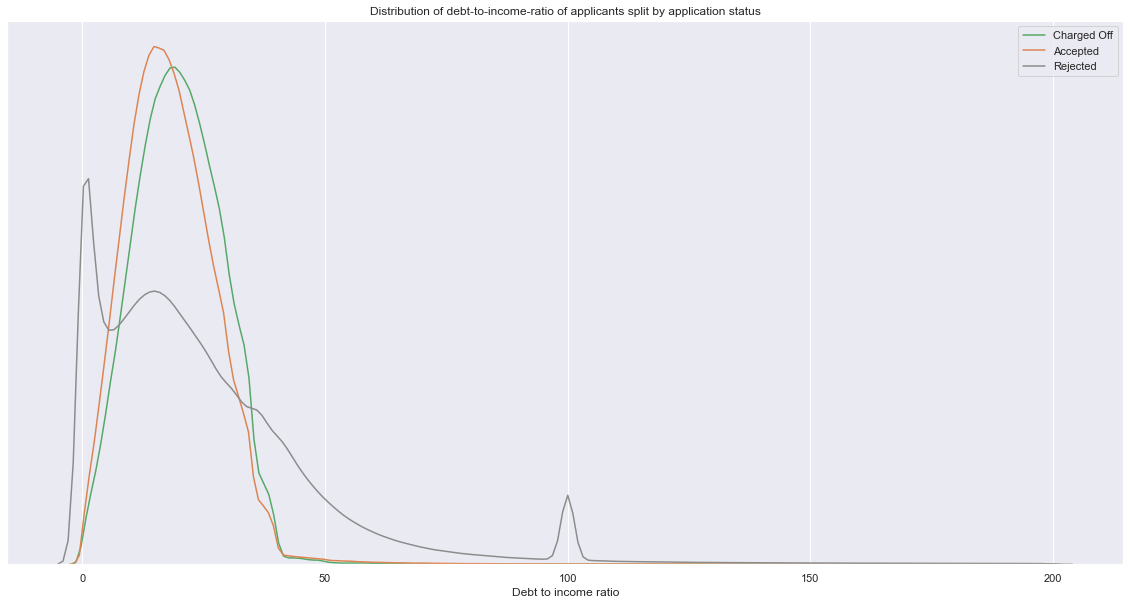

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["debt_to_income_ratio"]<200],
    x="debt_to_income_ratio",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Debt to income ratio", ylabel="")
ax.set_title("Distribution of debt-to-income-ratio of applicants split by application status")
ax.set_yticks([])

plt.show()

In [ ]:
df.loc[df["debt_to_income_ratio"]<0, "debt_to_income_ratio"].value_counts()

-1.0    3810
Name: debt_to_income_ratio, dtype: int64

Debt-to-income-ratio feature was heavily skewed, so, in order to see the difference in distributions, we will again be cutting off the long tail. We can again see quite large differences in distributions for this feature. Applicants that have debt-to-income-ratio of either 0 or above 45 seem a lot less likely to be accepted than the applicants whose debt-to-income-ratio is inbetween. Also, there seem to be some entries with a negative value, which is invalid for this feature - we will be considering those values as missing data.

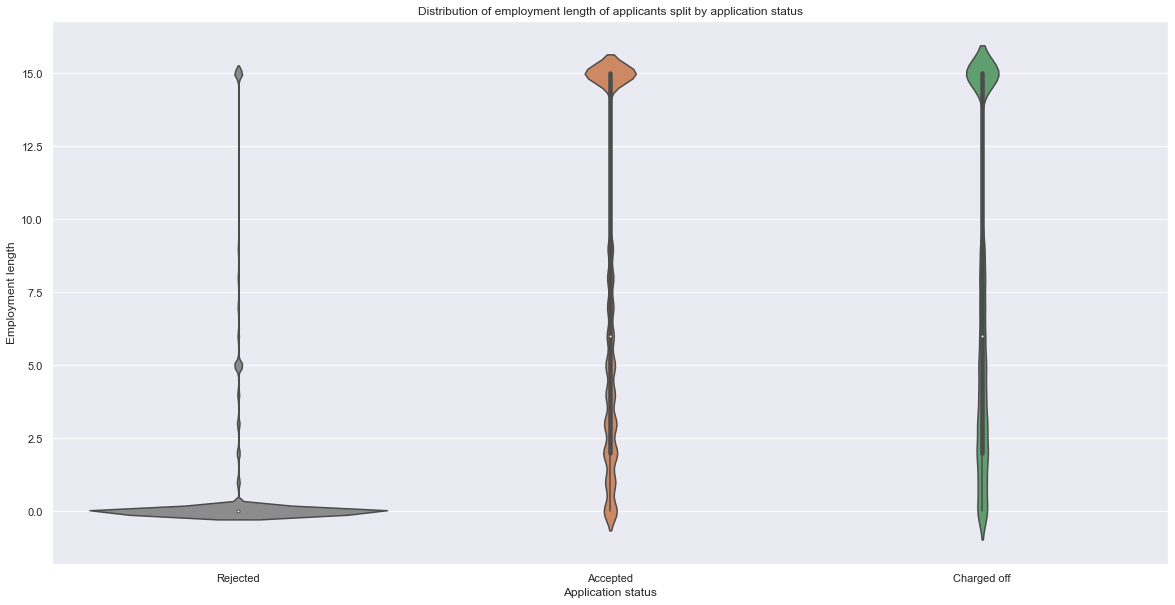

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.violinplot(
    y=df["employment_length_years"],
    x=df["accepted"].replace(accepted_to_words),
    palette=[colors["grey"], colors["orange"], colors["green"]]
)
ax.set(xlabel="Application status", ylabel="Employment length")
ax.set_title("Distribution of employment length of applicants split by application status")

plt.show()

We can see quite extreme differences in distributions for employement_length feature. Almost all of the rejected applicants had worked in their current job for less than a year, while the majority of accepted applicants had worked in their workplace for more than 10 years. 

Next let's take a look at some of the columns containing strings, starting with the loan_title column. We'll count all the different words for entries, split them by status and then check their proportions of total word count per split.

In [17]:
word_df = pd.Series([y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]).value_counts().to_frame("total")
word_df["total"] = (word_df["total"]/word_df["total"].sum()).round(3)
for index, value in enumerate(["rejected", "accepted", "charged_off"]):
    word_df[value] = pd.Series([y for x in df.loc[df["accepted"] == index, "loan_title"].dropna().values.flatten() for y in x.split()]).value_counts()
    word_df[value] = (word_df[value]/word_df[value].sum()).round(3)

difference_words = (word_df[np.abs(word_df["rejected"]-word_df["accepted"]) > 0.01]).index.to_list()

In [ ]:
word_df.head(10)

total  rejected  accepted  charged_off
debt           0.248     0.248     0.244        0.270
consolidation  0.248     0.248     0.244        0.270
credit         0.086     0.068     0.105        0.085
card           0.085     0.067     0.103        0.082
refinancing    0.071     0.040     0.099        0.078
other          0.052     0.082     0.026        0.026
home           0.032     0.031     0.033        0.029
improvement    0.027     0.024     0.030        0.026
car            0.015     0.028     0.005        0.004
purchase       0.012     0.015     0.010        0.009

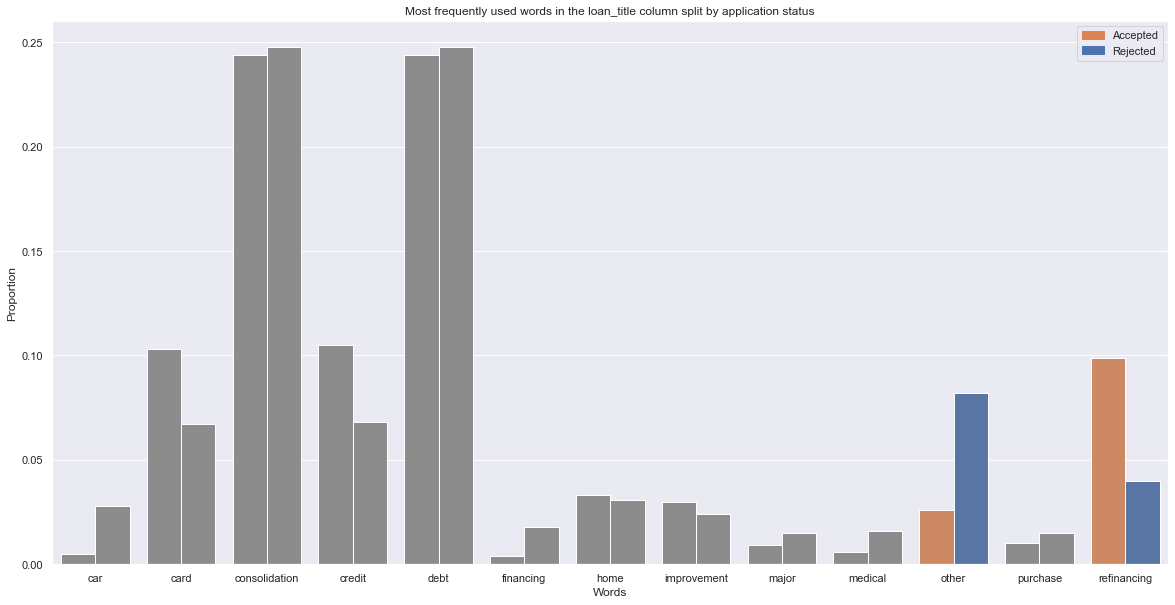

In [ ]:
word_df = word_df.loc[word_df["total"] > 0.01, ["rejected", "accepted"]]
word_df = word_df.unstack().reset_index().rename(columns={"level_0":"accepted", "level_1":"word", 0:"count"})
word_df.index.name = "id"

draw_comparison_barplot(word_df, "accepted", "word", ["other", "refinancing"], ["Most frequently used words in the loan_title column split by application status", "Words", "Proportion", "Accepted", "Rejected"], mode="")

We can see that some words are being used in the title a lot more frequently than others - words "debt" and "consolidation" together make up almost half of the total words used. For some words, like "other" and "refinancing", the difference in proportions is quite large and we might use them as features for our model. 

Next we'll look at the state and zip_code columns. 

In [17]:
states = geopandas.read_file("data/maps/tl_2012_us_state.shp")
us_pop_df = pd.read_csv('data/2019_Census_US_Population_Data_By_State_Lat_Long.csv')

states = customize_us_shapefile(states)

loans_states_count = df.groupby("state")["accepted"].count().rename("count")
states = states.merge(loans_states_count, left_on = "STUSPS", right_index=True)
states = states.merge(us_pop_df.set_index("STATE")["POPESTIMATE2019"], left_on = "NAME", right_index=True, how="left")
states["applications_per_thousand"] = states["count"]/(states["POPESTIMATE2019"]/1000)

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.


Let's start by just plotting the absolute loan application count per state.

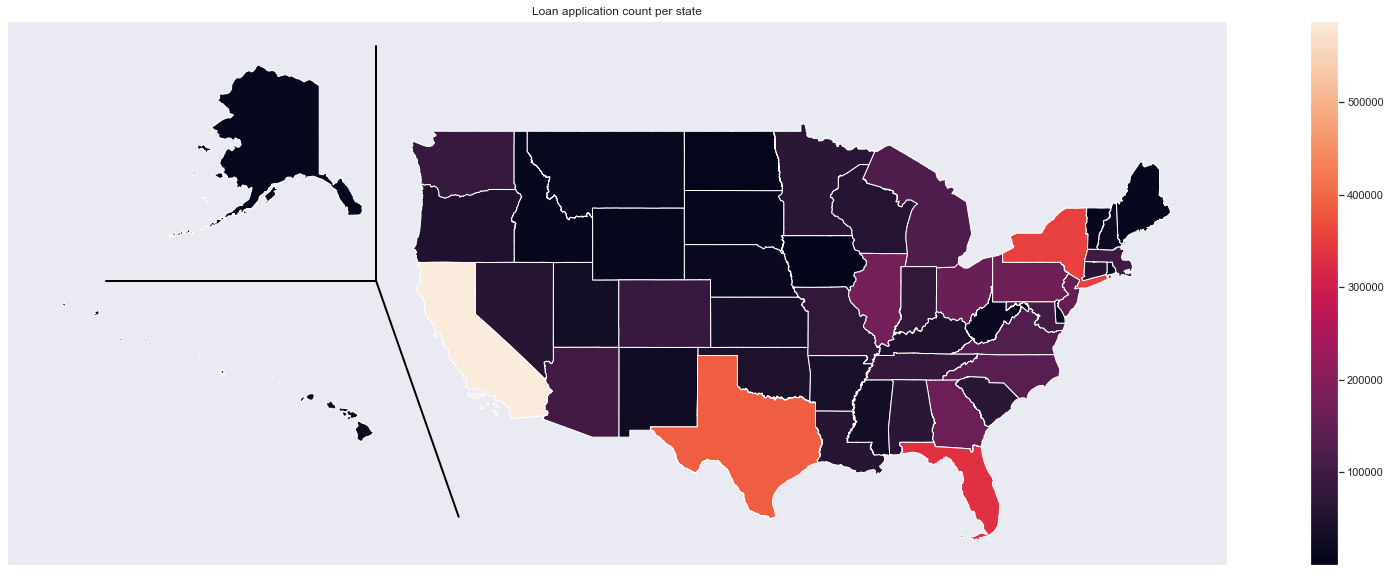

In [ ]:
draw_usa(states, "count", "Loan application count per state")

We can see that a few states - most notably California and Texas have a huge amount of loan applications. However, the absolute numbers of applications might be misleading in this case due to the differring population counts between the states.

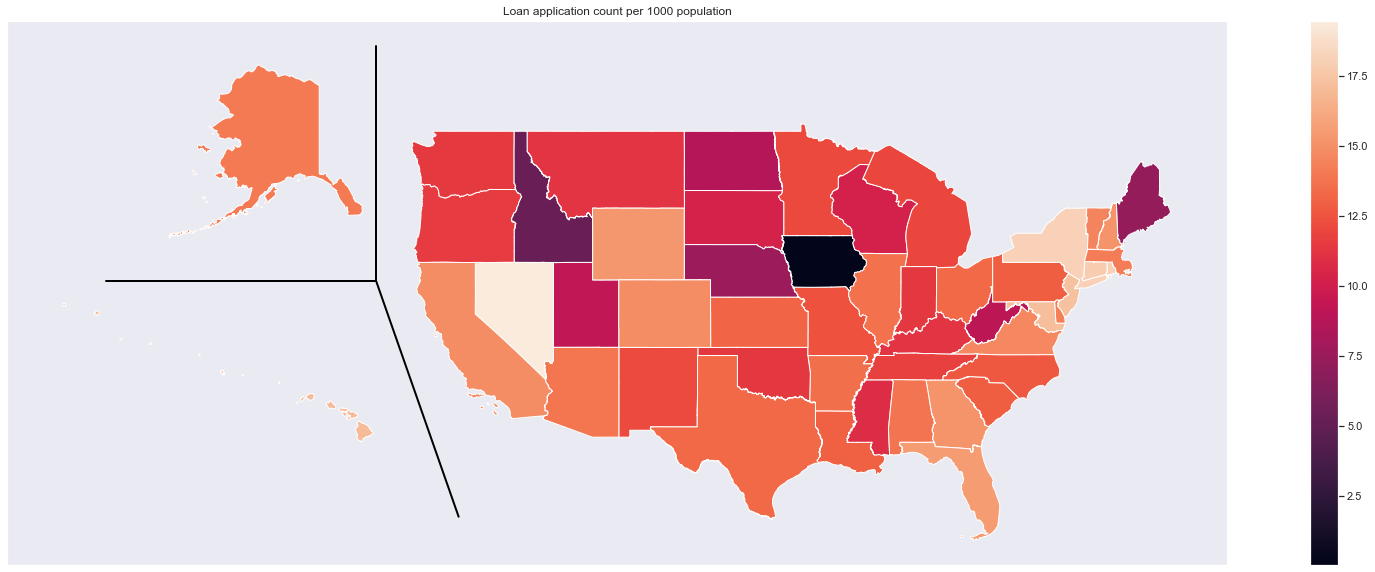

In [ ]:
draw_usa(states, "applications_per_thousand", "Loan application count per 1000 population")

If we look at a map containing normalized data - application count per 1000 population in each state - the high population states are not as prevalent as in the previous plot. There seem to be more per person applications in the New York area, but otherwise people seem to be more likely to apply for a loan in the southern part of the country compared to the more northern states. Two outlier states are Iowa with extremely low amount of applications and Nevada with the opposite - in Iowa's case it could be explained by a low population and thus a sample too small to be stable, while Nevada's high number could be explained by relatively low population combined with being adjacent to California.

Next let's look at the ratios between application statuses in each of the states.

In [ ]:
ratios_states = df.groupby("state")["accepted"].value_counts().rename("count").to_frame().unstack()
ratios_states.columns = ratios_states.columns.get_level_values(1)
ratios_states["accepted_charged_off_ratio"] = ratios_states[2]/ratios_states[1]
ratios_states["accepted_rejected_ratio"] = ratios_states[0]/(ratios_states[1]+ratios_states[2])
ratios_states = ratios_states.drop([0, 1, 2], axis=1)

states = states.merge(ratios_states, left_on = "STUSPS", right_index=True, how="left")

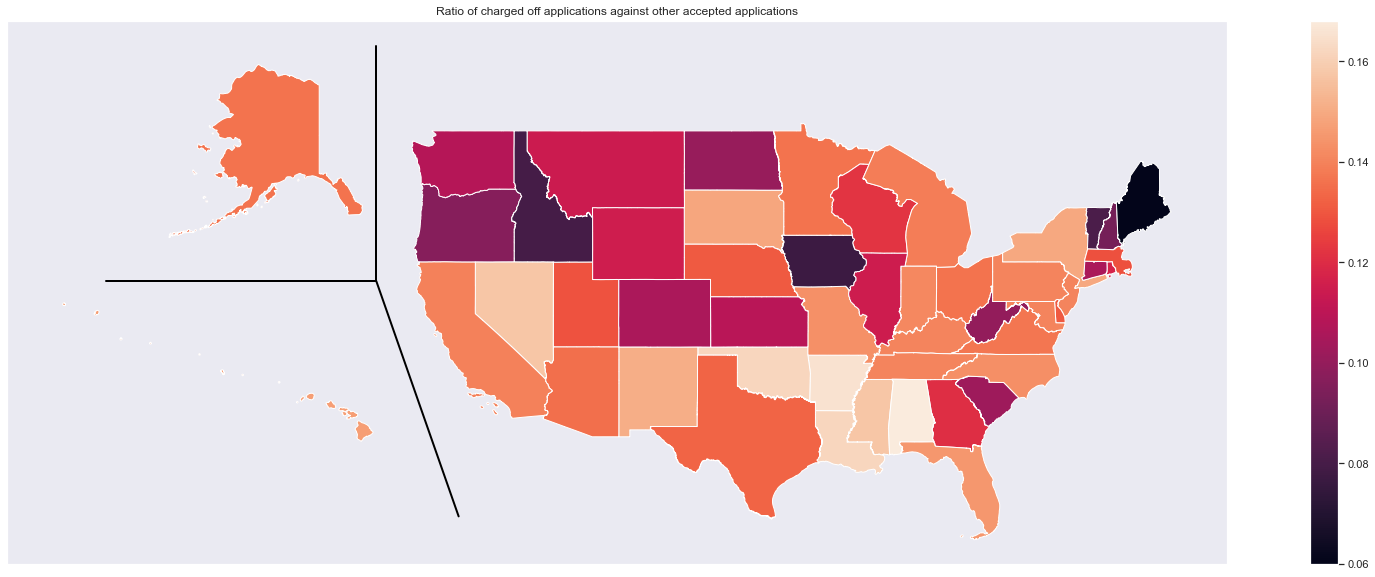

In [ ]:
draw_usa(states, "accepted_charged_off_ratio", "Ratio of charged off applications against other accepted applications")

In [ ]:
states.loc[states["accepted_charged_off_ratio"].sort_values(ascending=False)[:5].index].loc[:, ["NAME", "count", "accepted_charged_off_ratio"]]

NAME  count  accepted_charged_off_ratio
31    Alabama  67508                    0.143899
1    Arkansas  41034                    0.141736
17  Louisiana  60311                    0.139485
14   Oklahoma  45303                    0.139336
54     Nevada  59678                    0.136050

Looking at the ratio between charged off and accepted applications, we again see the difference between southern and northern states with the southern part of the country having a higher charged off ratio. Especially high the ratio seems to be in the states around Alabama.

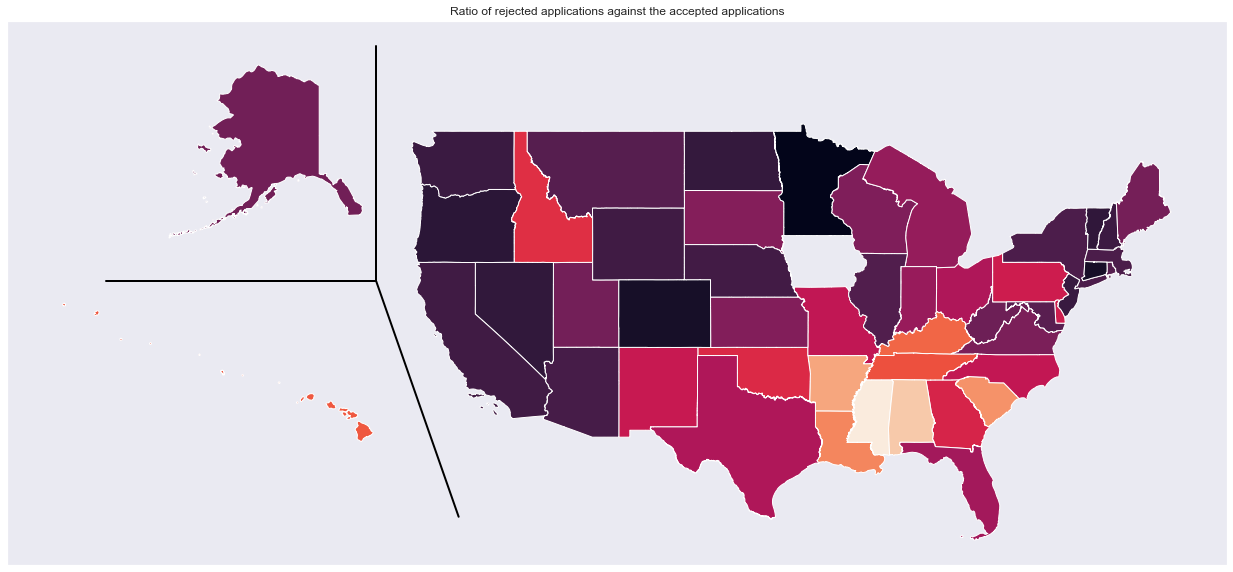

In [ ]:
draw_usa(states[states["NAME"]!="Iowa"], "accepted_rejected_ratio", "Ratio of rejected applications against the accepted applications", legend=False)

And here again we see that the ratio of rejected applications is especially high in the Alabama region. Note that since we are using a sample for rejected data and the complete dataset for accepted data, the ratios calculated here, while being accurate in comparison between the states are by themselves misleading, so I've excluded the legend here. Also note that we have excluded Iowa from this graph due to having an extremely low value.

And finally let's look at the zip_code.

In [18]:
zip_df = pd.read_csv("data/US_zip_codes_coordinates.txt", sep="\t", header=None)
zip_df = zip_df.drop([0, 2, 3, 5, 6, 7, 8, 11], axis=1)
zip_df.columns = ["zip_code", "state", "latitude", "longitude"]
zip_df = zip_df.dropna(axis=0)

zip_df["bin"] = np.floor(zip_df["zip_code"] / 100).astype(int).astype(str).str.zfill(3) + zip_df["state"]
state_coord_means = zip_df.groupby("state")[["latitude", "longitude"]].mean()
state_coord_means = state_coord_means.rename(columns={"latitude":"state_latitude", "longitude":"state_longitude"})
bin_coord_means = zip_df.groupby("bin")[["latitude", "longitude"]].mean()

zip_df.head()

zip_code state  latitude  longitude    bin
0     99553    AK   54.1430  -165.7854  995AK
1     99571    AK   55.1858  -162.7211  995AK
2     99583    AK   54.8542  -163.4113  995AK
3     99612    AK   55.0628  -162.3056  996AK
4     99661    AK   55.3192  -160.4914  996AK

Even though zip code contains numbers, they don't represent ordinal data. One way we can convert both zip codes and state names to numerical data is to look up their physical location as latitude and longitude. Since we are missing last two digits for the values in zip_code feature, we'll have to take the average geographical values between all the possible zip codes for each entry.

In [ ]:
df = zip_state_to_coordinates(df)

df.head()

amount_requested          loan_title  risk_score  debt_to_income_ratio  \
0             20000  debt consolidation       632.0             48.540001   
1             20000  debt consolidation       673.0             76.250000   
2              1000  debt consolidation       631.0              0.000000   
3              1000              moving       569.0            128.660004   
4              1800  debt consolidation       531.0              4.000000   

  state  employment_length_years  accepted   latitude  longitude  \
0    VA                      0.0         0  36.842242 -81.134800   
1    OH                      0.0         0  39.989814 -82.991341   
2    NC                      1.0         0  35.808798 -78.633634   
3    WI                      0.0         0  44.832535 -91.591833   
4    IN                      0.0         0  38.151090 -87.455367   

   state_latitude  state_longitude  
0       37.714359       -78.231150  
1       40.387578       -82.739298  
2       35.573569       -79.528286  
3       44.109163       -89.534565  
4       39.940313       -86.267456

We won't be exploring these geographical values further - data we already explored using the state column and geopandas visualisations was quite similar.

## Missing data and data engineering

In [19]:
df = df_copy
del(df_copy)

df["accepted"].value_counts()

0    2248049
1    1992109
2     268559
Name: accepted, dtype: int64

As we saw previously, there was a significant difference between accepted applications and those that were accepted but later got charged off. Since we're interested to minimize the amount of charged off applications and to make data cleaner, I won't be including them with the rest of the accepted data.

In [20]:
df = df[df["accepted"]!=2]

train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"]
)

In [21]:
relevant_words = get_relevant_words(train_set, train_accepted)
missing_dict = {"debt_to_income_ratio":-1, "risk_score":0}

preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(missing_dict, one_column = True)),
    ]
)

cleaned_train_set = preprocessor.fit_transform(train_set)

And here we can see the beginnings of a pipeline - We check whether the "loan_title" column has any of the relevant words, we change "state" and "zip_code" columns into coordinates, mark invalid values as missing and add a column marking the applications where these invalid values were.

In [ ]:
cleaned_train_set.isnull().sum()

amount_requested                0
risk_score                  17401
debt_to_income_ratio         4409
employment_length_years    100625
word_refinancing                0
word_other                      0
word_car                        0
word_medical                    0
word_moving                     0
state_latitude                  0
state_longitude                 0
missing_data                    0
dtype: int64

As for the missing values, we have some for the risk_score and debt_to_income_ratio - at least some of those are from the invalid values we transformed to NANs. There are quite a lot of missing values in the employment_length_years column.

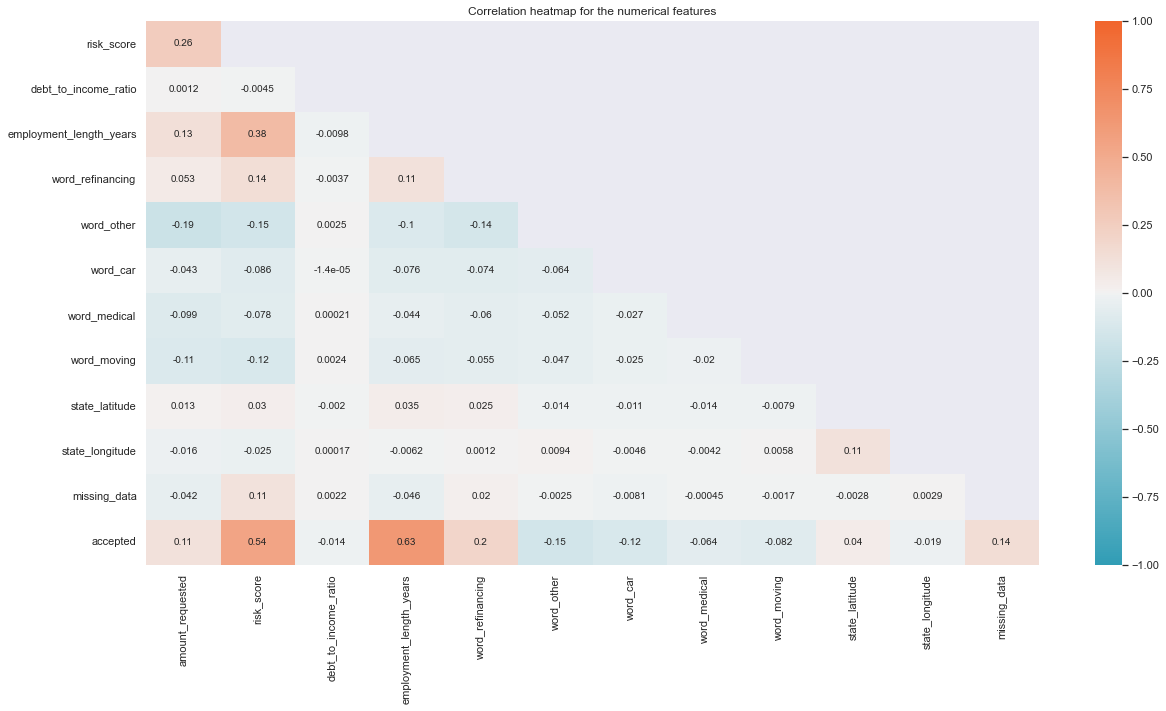

In [ ]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(cleaned_train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = cleaned_train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

Checking the correlations between features, we can see that debt_to_income_ratio does not have any relevant correlations we could use, so we will use median value. For the other two columns the greatest correlation, excluding the target column, is with each other. Let's take a closer look at them!

In [ ]:
cleaned_train_set.groupby("employment_length_years")["risk_score"].mean()

employment_length_years
0.0     629.851196
1.0     692.005371
2.0     695.772278
3.0     696.698730
4.0     697.252380
5.0     688.215088
6.0     698.583130
7.0     699.000244
8.0     699.400940
9.0     699.647278
15.0    700.991516
Name: risk_score, dtype: float32

Looking at the mean risk_score values for each employment_length_years value, we can see that the means are all almost identical except for the value "0".

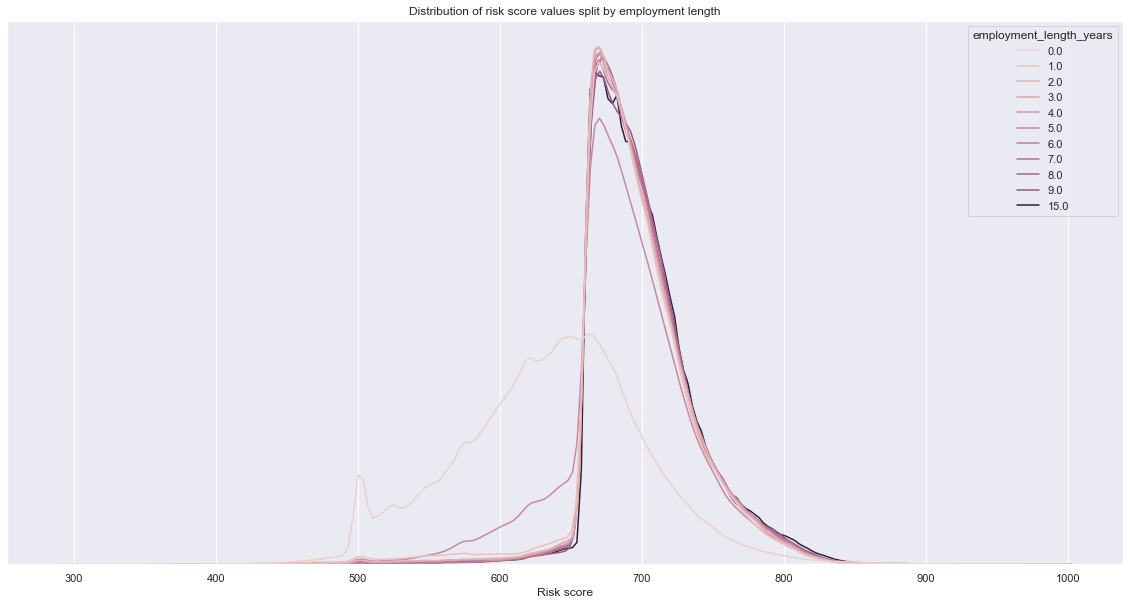

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=cleaned_train_set.join(train_accepted),
    x="risk_score",
    hue="employment_length_years",
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk score values split by employment length")
ax.set_yticks([])

plt.show()

And if we look at the risk_score plotted, split by employement_length_years, we can see that the distribution is almost identical for values 1 to 15. Only the distribution for value 0 is different. However, since all the missing values come from the accepted dataset, and since as we previously saw, accepted applications are unlikely to have an employment_length_years value of 0, this correlation doesn't really help us for the missing values in employment_length_years column. Since the employment_length_years seems to be a critical column for target prediction, I decided to get rid of the missing data to not muddy the feature.

In [23]:
train_set = train_set.drop(train_set.loc[train_set["employment_length_years"].isna()].index)
test_set = test_set.drop(test_set.loc[test_set["employment_length_years"].isna()].index)

In [22]:
print(f'mean | {cleaned_train_set["debt_to_income_ratio"].mean()}')
print(f'median | {cleaned_train_set["debt_to_income_ratio"].median()}')

mean | 95.75413513183594
median | 18.65999984741211


For the debt_to_income_ratio we'll be using median instead of mean because the column is quite heavily skewed.

In [33]:
train_set.describe().apply(lambda s: s.apply('{0:.5f}'.format))

amount_requested     risk_score debt_to_income_ratio  \
count    3392126.00000  3392126.00000        3390813.00000   
mean       13738.26144      662.46008             95.66722   
std        10207.52864       78.73376           4249.15527   
min          150.00000        0.00000             -1.00000   
25%         5000.00000      632.00000             10.70000   
50%        10000.00000      672.00000             18.65000   
75%        20000.00000      702.00000             28.66000   
max       500000.00000      990.00000        3967200.00000   

      employment_length_years  
count           3291501.00000  
mean                  3.85430  
std                   5.60120  
min                   0.00000  
25%                   0.00000  
50%                   0.00000  
75%                   6.00000  
max                  15.00000

We can see that the "amount_requested" is also skewed. We'll convert both of these features into log scale.

In [ ]:
to_log_list = ["debt_to_income_ratio", "amount_requested"]
preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(missing_dict, one_column = True)),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list))
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor)
    ]
)

cleaned_train_set = full_pipe.fit_transform(train_set)

In [ ]:
cleaned_train_set.isna().sum()

risk_score                  0
employment_length_years     0
word_refinancing            0
word_other                  0
word_car                    0
word_medical                0
word_moving                 0
state_latitude              0
state_longitude             0
missing_data                0
debt_to_income_ratio_log    0
amount_requested_log        0
dtype: int64

All of the missing values are gone.

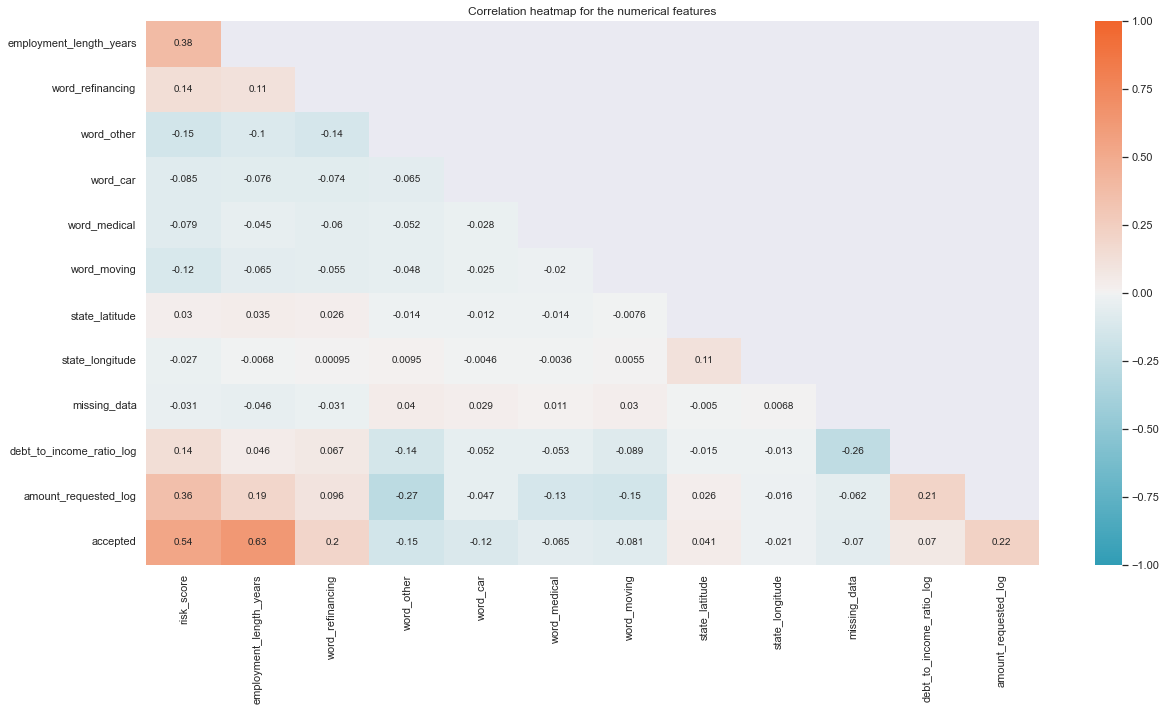

In [ ]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(cleaned_train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = cleaned_train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

In the correlation heatmap we can see that both of the features we transformed into log scale now have a better correlation with "accepted" column than they did previously. Let's get to training!

In [34]:
df2 = df.copy()
df = df2.sample(frac=0.1)

df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
df = df.drop(df.loc[df["employment_length_years"].isna()].index)
df = df[df["accepted"]!=2]

We'll be using a sample of the dataset for tuning to speed up the process.

In [35]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"]
)

In [56]:
relevant_words = get_relevant_words(train_set, train_accepted)

models = [
    ["svm_rbf", SVC()],
    ["k_neighbors", KNeighborsClassifier()],
    ["logistic_reg", LogisticRegression()],
    ["decision_tree", DecisionTreeClassifier()],
    ["random_forest", RandomForestClassifier()],
    ["boosted_model", GradientBoostingClassifier()],
]

model_scores = pd.DataFrame(
    columns=["f1_score", "recall", "precision", "roc_auc", "model", "fit_time"]
)
missing_dict = {"debt_to_income_ratio":-1, "risk_score":0}
to_log_list = ["debt_to_income_ratio", "amount_requested"]

for model in models:
    
    preprocessor = Pipeline(
        [
            ("extract_words", ExtractWords(relevant_words)),
            ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
            ("unknown_to_nan", UnknownToNan(missing_dict)),
            ("add_missing_column", AddMissingColumn(list(missing_dict.keys()), one_column = True)),
            ("fill_missing_data", FillMissingData()),
            ("transform_to_log", TransformToLog(to_log_list))
        ]
    )

    full_pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("scaler", MinMaxScaler()),
            (model[0], model[1]),
        ]
    )

    temp = cross_validate(
        full_pipe,
        train_set,
        train_accepted,
        cv=5,
        scoring=("f1", "recall", "precision", "roc_auc"),
    )
    model_scores.loc["default_" + model[0]] = [
        temp["test_f1"].mean(),
        temp["test_recall"].mean(),
        temp["test_precision"].mean(),
        temp["test_roc_auc"].mean(),
        model[0],
        temp["fit_time"].mean(),
    ]

In [57]:
model_scores

f1_score    recall  precision   roc_auc          model  \
default_svm_rbf        0.896688  0.892130   0.901303  0.953908        svm_rbf   
default_k_neighbors    0.899094  0.909580   0.888863  0.946613    k_neighbors   
default_logistic_reg   0.835901  0.806966   0.867039  0.938660   logistic_reg   
default_decision_tree  0.913708  0.913220   0.914217  0.921452  decision_tree   
default_random_forest  0.931609  0.941247   0.922175  0.979457  random_forest   
default_boosted_model  0.934827  0.936531   0.933139  0.986085  boosted_model   

                        fit_time  
default_svm_rbf        14.663200  
default_k_neighbors     0.407798  
default_logistic_reg    0.401399  
default_decision_tree   0.390797  
default_random_forest   2.843797  
default_boosted_model   3.016000

The scores for all of the models are quite high, maybe even too high. Let's use shap to check whether there hasn't been any data leakage.

In [36]:
shap.initjs()

In [57]:
preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(list(missing_dict.keys()), one_column = True)),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list))
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", MinMaxScaler()),
        ("model", LogisticRegression()),
    ]
)

full_pipe.fit(train_set, train_accepted)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('extract_words',
                                  ExtractWords(relevant_words=['refinancing',
                                                               'other', 'car',
                                                               'medical',
                                                               'moving'])),
                                 ('zip_to_coords',
                                  ZipStateToCoordinates(bin_coord_means=        latitude   longitude
bin                         
005NY  40.815400  -73.045100
010MA  42.264533  -72.571779
011MA  42.124445  -72.570877
012MA  42.347011  -73.226954
013MA  42.594145  -72.576003
...          ...         ...
99...
                                  UnknownToNan(missing_dict={'debt_to_income_ratio': -1,
                                                             'risk_score': 0})),
                                 ('add_missing_column',
                                  AddMissingColumn(missing_list=['debt_to_income_ratio',
                                                                 'risk_score'])),
                                 ('fill_missing_data', FillMissingData()),
                                 ('transform_to_log',
                                  TransformToLog(log_list=['debt_to_income_ratio',
                                                           'amount_requested']))])),
                ('scaler', MinMaxScaler()), ('model', LogisticRegression())])

In [51]:
to_log_list = ["debt_to_income_ratio", "amount_requested"]


preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(list(missing_dict.keys()), one_column = True)),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list))
    ]
)

transformer = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", MinMaxScaler())
    ]
)

train_shap = transformer.fit_transform(train_set)
test_shap = transformer.transform(test_set)

column_names = transformer.steps[1][1].feature_names_in_

train_shap = pd.DataFrame(train_shap, index=train_set.index, columns=column_names)
test_shap = pd.DataFrame(test_shap, index=test_set.index, columns=column_names)

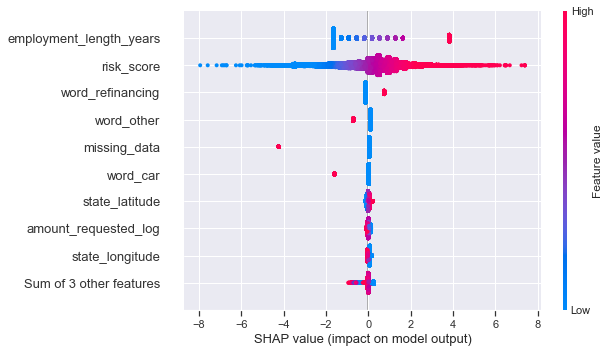

In [59]:
log_reg = full_pipe[-1]

log_reg.fit(train_shap, train_accepted)
explainer = shap.Explainer(log_reg, train_shap, feature_names=train_shap.columns)
shap_values = explainer(test_shap)

shap.plots.beeswarm(shap_values)

We don't see any features that shouldn't be here. Unsuprisingly, the most important feature is employment length, with risk score as second most important.

We're mostly interested in roc_auc score at the moment and the highest score was for the boosted model. Let's try tuning a XGboost model a bit to see whether we can get an even better score.

In [100]:
def objective_booster_class(trial, X: pd.DataFrame, y: pd.Series):
    

    
    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
        
    state = trial.suggest_categorical("state", [True, False])

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.7)
    n_estimators = trial.suggest_int("n_estimators", 10, 300)
    max_depth = trial.suggest_int("max_depth", 2, 6, log=True)
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-10, 0.1
    )
    
    Preprocessor = Pipeline(
        [
            ("extract_words", ExtractWords(relevant_words)),
            ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=state)),
            ("unknown_to_nan", UnknownToNan(missing_dict)),
            ("add_missing_column", AddMissingColumn(list(missing_dict.keys()), one_column = True)),
            ("fill_missing_data", FillMissingData()),
            ("transform_to_log", TransformToLog(to_log_list))
        ]
    )

    full_pipe = Pipeline(
        [
            ("preprocessor", Preprocessor),
            ("scaler", scaler),
            (
                "model", 
                 xg.XGBClassifier(
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_impurity_decrease=min_impurity_decrease,
                    tree_method='gpu_hist',
                ),
            ),
        ]
    )


    models[trial.number] = full_pipe
    score = cross_val_score(
        full_pipe,
        X,
        y,
        n_jobs=-1,
        cv=5,
        scoring="roc_auc",
        verbose=30,
    )
    average_precision = score.mean()
    return average_precision

In [101]:
models = {}
accepted_wrapper = lambda trial: objective_booster_class(
    trial, train_set, train_accepted
)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(accepted_wrapper, n_trials=300)

[I 2022-10-14 10:01:04,456] A new study created in memory with name: no-name-b40a018c-081b-4cba-bb9d-0e93759cc3e5
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished
[I 2022-10-14 10:01:23,188] Trial 0 finished with value: 0.9954588033037794 and parameters: {'scaler': 'Standard', 'state': False, 'learning_rate': 0.5633424441899579, 'n_estimators': 205, 'max_depth': 2, 'min_impurity_decrease': 0.09960374631530268}. Best is trial 0 with value: 0.9954588033037794.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_job

The best score we get is 0.99556 - can't go much higher than that! Let's see whether the same model is just as good when trained and tested on the full dataset.

In [60]:
df = df2.copy()

df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
df = df.drop(df.loc[df["employment_length_years"].isna()].index)
df = df[df["accepted"]!=2]

In [61]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"]
)

[11:50:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




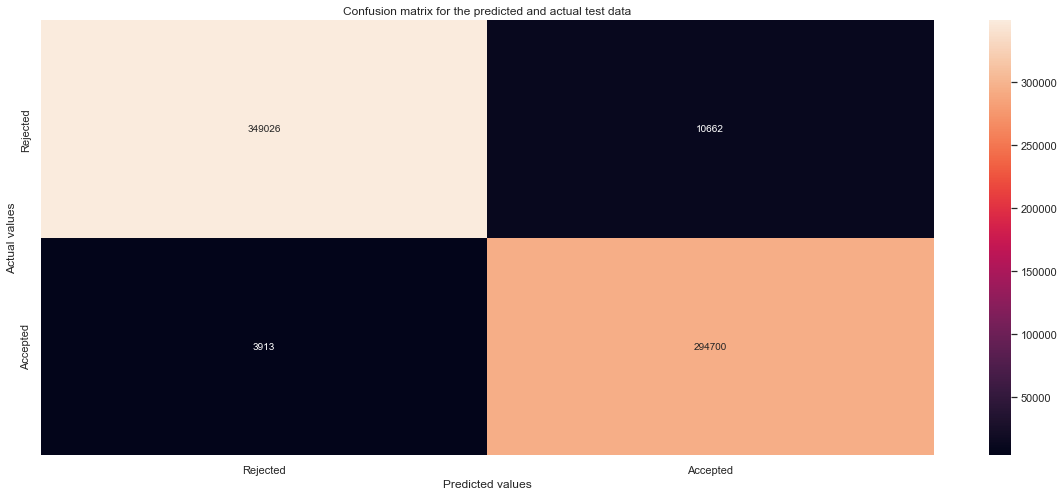

In [62]:
relevant_words = get_relevant_words(train_set, train_accepted)

preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=False)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(list(missing_dict.keys()), one_column = True)),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list))
    ]
)
full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", MinMaxScaler()),
        ("model", xg.XGBClassifier(
            learning_rate = 0.41972, 
            n_estimators = 246,
            max_depth = 3,
            min_impurity_decrease = 0.0868
        )),
    ]
)

train_set_val, test_set_val, train_accepted_val, test_accepted_val = train_test_split(
    train_set, train_accepted, test_size=0.2, random_state=42, stratify=train_accepted
)

full_pipe.fit(train_set_val, train_accepted_val)

matrix = confusion_matrix(test_accepted_val, full_pipe.predict(test_set_val))
label_list = ["Rejected", "Accepted"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

In [63]:
roc_auc_score(test_accepted_val, full_pipe.predict(test_set_val))

0.9786268630903732

The score is slightly worse, but not by much. Let's see whether we can't improve it a bit more by changing the threshold.

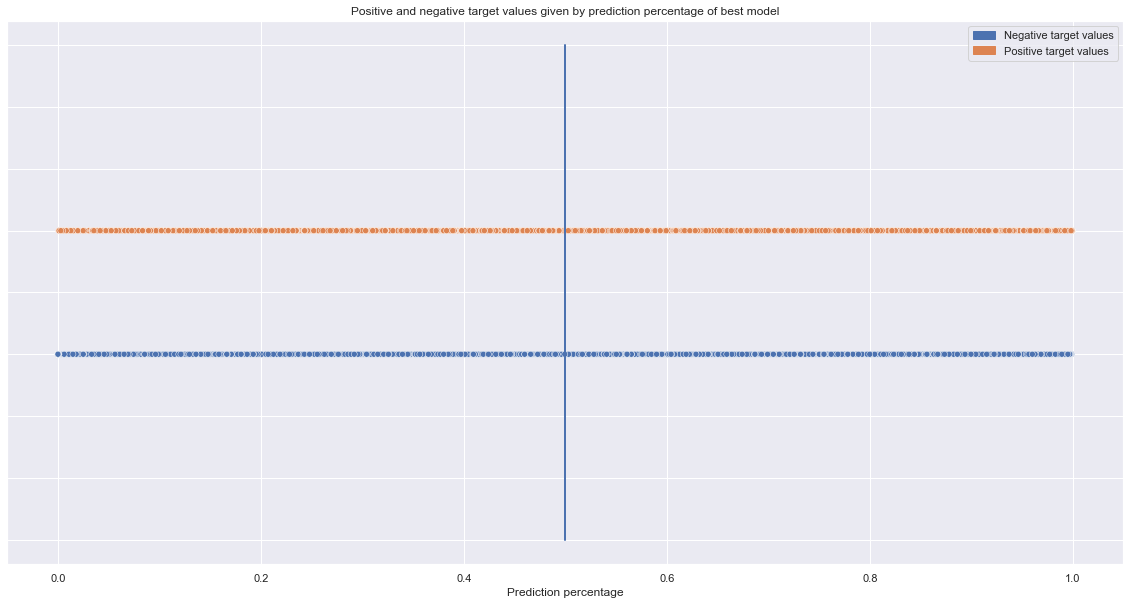

In [27]:
df_colors = pd.DataFrame()
df_colors["predictions"] = full_pipe.predict_proba(test_set_val)[:, 1]
df_colors["y_numbers"] = np.array(test_accepted_val)
df_colors["loc"] = np.zeros(len(test_accepted_val))
df_colors.loc[df_colors["y_numbers"] == 0, "loc"] -= 0.25
df_colors.loc[df_colors["y_numbers"] == 1, "loc"] += 0.25

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df_colors, x="predictions", y="loc", hue="y_numbers")

blue_patch = mpatches.Patch(color=colors["blue"], label="Negative target values")
orange_patch = mpatches.Patch(color=colors["orange"], label="Positive target values")
plt.legend(handles=[blue_patch, orange_patch])
ax.set_xlabel("Prediction percentage")
ax.set_ylabel("")
ax.axes.yaxis.set_ticklabels([])
ax.set_title(
    "Positive and negative target values given by prediction percentage of best model"
)
plt.plot([0.5, 0.5], [-1, 1], linewidth=2)
plt.show()

Both positive and negative values are distributed all across the thresholds, so we won't be able to get completely "clean" either of the values.

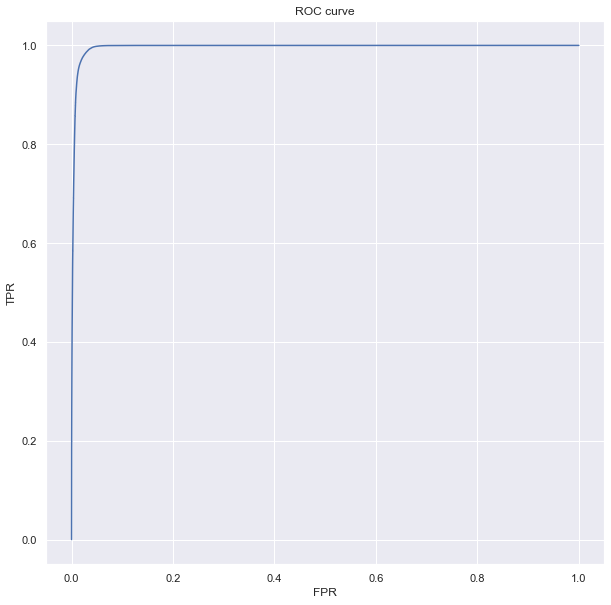

In [64]:
yhat = full_pipe.predict_proba(test_set_val)
yhat = yhat[:, 1]
fpr, tpr, thresholds = roc_curve(test_accepted_val, yhat)

plt.figure(figsize=(10, 10))
plt.title("ROC curve")
plt.plot(fpr, tpr, "b-")
plt.ylabel("TPR")
plt.xlabel("FPR")
#plt.plot([0.5, 0.5], [-1, 1], linewidth=2)
plt.show()

In [30]:
best_thresh = sorted(list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)[0][1]
best_thresh

0.47115397

Checking the ROC curve, it seems like we can get a slightly better result in correct values, if we move the threshold a bit.
Let's check the model on the test data.

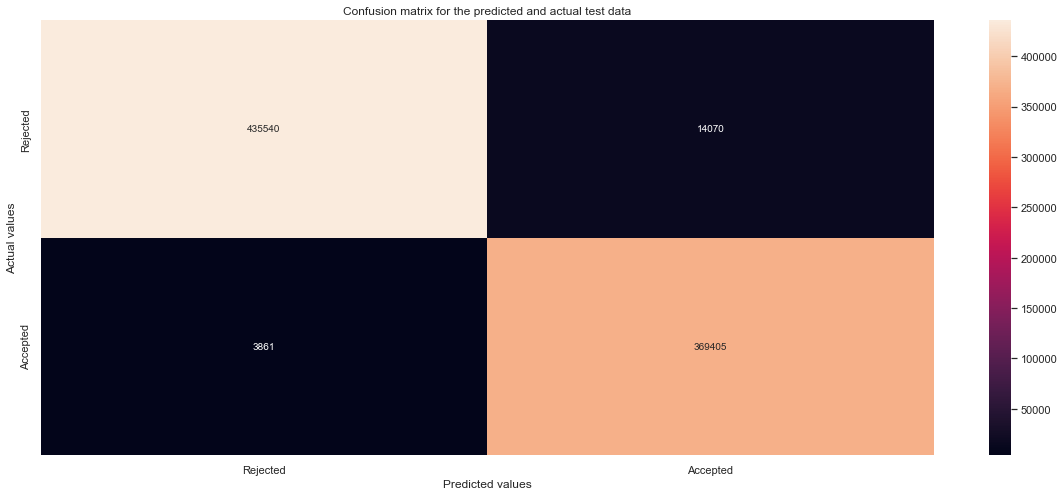

In [35]:
missing_dict = {"debt_to_income_ratio":-1, "risk_score":0}
to_log_list = ["debt_to_income_ratio", "amount_requested"]

preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=False)),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(list(missing_dict.keys()), one_column = True)),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list))
    ]
)


full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", StandardScaler()),
        ("model", Thresholder(
            xg.XGBClassifier(
                learning_rate = 0.41972, 
                n_estimators = 246,
                max_depth = 3,
                min_impurity_decrease = 0.0868),
            best_thresh)
        ),
    ]
)

full_pipe.fit(train_set, train_accepted)

matrix = confusion_matrix(test_accepted, full_pipe.predict(test_set))
label_list = ["Rejected", "Accepted"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

In [36]:
roc_auc_score(test_accepted, full_pipe.predict(test_set))

0.979181191090564

The score is pretty similar to the one we got with the training data. We'll call it good enough and move to the second task.

In [37]:
joblib.dump(full_pipe, "accepted_model_tuned.pkl")

['accepted_model_tuned.pkl']

In [ ]:
del(cleaned_train_set)
del(df)
del(df2)
del(train_set)

# Setting up data

The dataset we're going to use for the second and third tasks has a lot of columns - around 150. While the principle "More data = more better" still stands, the problem for this dataset is that it's obvious that some of the columns are updated after the loan has been given out, which, if used in model, may provide target data leakage. Due to there being limited info about the dataset and the features, it's not easy to check which features were made at the application origination and which have been updated after. To check, we will load a different version of the same dataset, from a different year, check for same loan ids and then see which features have changed and which have not.

In [39]:
df = pd.read_csv('data/Loan_status_2007-2020Q3.gzip')
df_2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_1960\578772369.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


In [41]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


In [ ]:
df_2 = df_2.loc[df_2["id"].isin(df["id"])]
df = df.loc[df["id"].isin(df_2["id"])]

df = df.loc[df["id"].astype("str").str.isnumeric()]
df_2 = df_2.loc[df_2["id"].astype("str").str.isnumeric()]

df_2  = df_2.set_index("id")
df = df.set_index("id")

df.index = df.index.astype(int)
df_2.index = df_2.index.astype(int)

df = df.sort_index()
df_2 = df_2.sort_index()

In [ ]:
original_columns = []
changed_columns = []
not_found_columns = []
for column in df_2.columns:
    if column in df.columns:
        if not df_2[column].dtype == df[column].dtype:
            df[column] = df[column].str.strip("%").astype("float")
        if df_2[column].equals(df[column]):
            original_columns.append(column)
        else:
            changed_columns.append(column)
    else:
        not_found_columns.append(column)

We sorted the feature names in three lists - columns that have not changed since origination, columns that did and columns that were missing in the second dataset.

In [ ]:
del(df)
del(df_2)

In [5]:
df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_10564\4289167991.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", None)

In [10]:
titles = pd.read_excel("LCDataDictionary.xlsx")
titles = pd.DataFrame(titles.set_index("LoanStatNew").T)

In [11]:
titles = titles.loc[:, titles.columns[:-2]]

In [ ]:
df.head().append(titles).loc[:, not_found_columns]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_9968\3308183394.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(titles).loc[:, not_found_columns]


member_id  \
0                                                         NaN   
1                                                         NaN   
2                                                         NaN   
3                                                         NaN   
4                                                         NaN   
Description  A unique LC assigned Id for the borrower member.   

                                                  desc  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
Description  Loan description provided by the borrower   

             sec_app_mths_since_last_major_derog  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
Description                                  NaN   

                                                                                     disbursement_method  \
0                                                                                                   Cash   
1                                                                                                   Cash   
2                                                                                                   Cash   
3                                                                                                   Cash   
4                                                                                                   Cash   
Description  The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY   

                                                     debt_settlement_flag_date  \
0                                                                          NaN   
1                                                                          NaN   
2                                                                          NaN   
3                                                                          NaN   
4                                                                          NaN   
Description  The most recent date that the Debt_Settlement_Flag has been set     

                                                                                                                 settlement_status  \
0                                                                                                                              NaN   
1                                                                                                                              NaN   
2                                                                                                                              NaN   
3                                                                                                                              NaN   
4                                                                                                                              NaN   
Description  The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT   

                                                      settlement_date  \
0                                                                 NaN   
1                                                                 NaN   
2                                                                 NaN   
3                                                                 NaN   
4                                                                 NaN   
Description  The date that the borrower agrees to the settlement plan   

                                         

In [ ]:
df.loc[:, not_found_columns].isnull().sum()*100/ df.shape[0]

member_id                              100.000000
desc                                    94.423544
sec_app_mths_since_last_major_derog     98.410139
disbursement_method                      0.001460
debt_settlement_flag_date               98.485160
settlement_status                       98.485160
settlement_date                         98.485160
settlement_amount                       98.485160
settlement_percentage                   98.485160
settlement_term                         98.485160
dtype: float64

In [7]:
original_columns = ['loan_amnt', 'funded_amnt', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
                    'issue_d', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
                    'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
                    'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type',
                    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
                    'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
                    'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
                    'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
                    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 
                    'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
                    'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
                    'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
                    'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                    'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med']

In [ ]:
df = df.loc[:, original_columns + ["disbursement_method", "int_rate"]]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 106 entries, loan_amnt to int_rate
dtypes: float64(87), object(19)
memory usage: 1.8+ GB


In [ ]:
missing_percentage = df.loc[:, original_columns].isnull().sum()*100/ df.shape[0]
missing_percentage[missing_percentage>40].sort_values()

mths_since_rcnt_il                    40.251099
il_util                               47.281042
mths_since_last_delinq                51.246715
mths_since_recent_revol_delinq        67.250910
mths_since_last_major_derog           74.309960
mths_since_recent_bc_dlq              77.011511
mths_since_last_record                84.113069
annual_inc_joint                      94.660506
dti_joint                             94.660683
verification_status_joint             94.880791
sec_app_num_rev_accts                 95.221792
sec_app_open_act_il                   95.221792
sec_app_open_acc                      95.221792
sec_app_mort_acc                      95.221792
sec_app_collections_12_mths_ex_med    95.221792
sec_app_earliest_cr_line              95.221792
sec_app_fico_range_high               95.221792
sec_app_fico_range_low                95.221792
sec_app_chargeoff_within_12_mths      95.221792
sec_app_inq_last_6mths                95.221792
revol_bal_joint                       95

In [38]:
df.loc[:, ["fico_range_high", "sec_app_fico_range_high", 

loan_amnt  funded_amnt        term grade sub_grade  \
0           3600.0       3600.0   36 months     C        C4   
1          24700.0      24700.0   36 months     C        C1   
2          20000.0      20000.0   60 months     B        B4   
3          35000.0      35000.0   60 months     C        C5   
4          10400.0      10400.0   60 months     F        F1   
...            ...          ...         ...   ...       ...   
2260696    40000.0      40000.0   60 months     B        B3   
2260697    24000.0      24000.0   60 months     C        C4   
2260698    14000.0      14000.0   60 months     C        C4   
2260699        NaN          NaN         NaN   NaN       NaN   
2260700        NaN          NaN         NaN   NaN       NaN   

                           emp_title emp_length home_ownership  annual_inc  \
0                            leadman  10+ years       MORTGAGE     55000.0   
1                           Engineer  10+ years       MORTGAGE     65000.0   
2                       truck driver  10+ years       MORTGAGE     63000.0   
3        Information Systems Officer  10+ years       MORTGAGE    110000.0   
4                Contract Specialist    3 years       MORTGAGE    104433.0   
...                              ...        ...            ...         ...   
2260696              Vice President     9 years       MORTGAGE    227000.0   
2260697              Program Manager    6 years           RENT    110000.0   
2260698  Customer Service Technician  10+ years       MORTGAGE     95000.0   
2260699                          NaN        NaN            NaN         NaN   
2260700                          NaN        NaN            NaN         NaN   

        verification_status   issue_d  \
0              Not Verified  Dec-2015   
1              Not Verified  Dec-2015   
2              Not Verified  Dec-2015   
3           Source Verified  Dec-2015   
4           Source Verified  Dec-2015   
...                     ...       ...   
2260696            Verified  Oct-2016   
2260697        Not Verified  Oct-2016   
2260698            Verified  Oct-2016   
2260699                 NaN       NaN   
2260700                 NaN       NaN   

                                                                       url  \
0        https://lendingclub.com/browse/loanDetail.action?loan_id=68407277   
1        https://lendingclub.com/browse/loanDetail.action?loan_id=68355089   
2        https://lendingclub.com/browse/loanDetail.action?loan_id=68341763   
3        https://lendingclub.com/browse/loanDetail.action?loan_id=66310712   
4        https://lendingclub.com/browse/loanDetail.action?loan_id=68476807   
...                                                                    ...   
2260696  https://lendingclub.com/browse/loanDetail.action?loan_id=88985880   
2260697  https://lendingclub.com/browse/loanDetail.action?loan_id=88224441   
2260698  https://lendingclub.com/browse/loanDetail.action?loan_id=88215728   
2260699                                                                NaN   
2260700                                                                NaN   

                    purpose               title zip_code addr_state    dti  \
0        debt_consolidation  Debt consolidation    190xx         PA   5.91   
1            small_business            Business    577xx         SD  16.06   
2          home_improvement                 NaN    605xx         IL  10.78   
3        debt_consolidation  Debt consolidation    076xx         NJ  17.06   
4            major_purchase      Major purchase    174xx         PA  25.37   
...                     ...                 ...      ...        ...    ...   
2260696  debt_consolidation                 NaN    907xx         CA  12.75   
2260697  debt_consolidation  Debt consolidation    334xx         FL  18.30   
2260698  debt_consolidation                 NaN    770xx         TX  23.36   
2260699                 NaN                 NaN      NaN        NaN    NaN   
2260700                 NaN

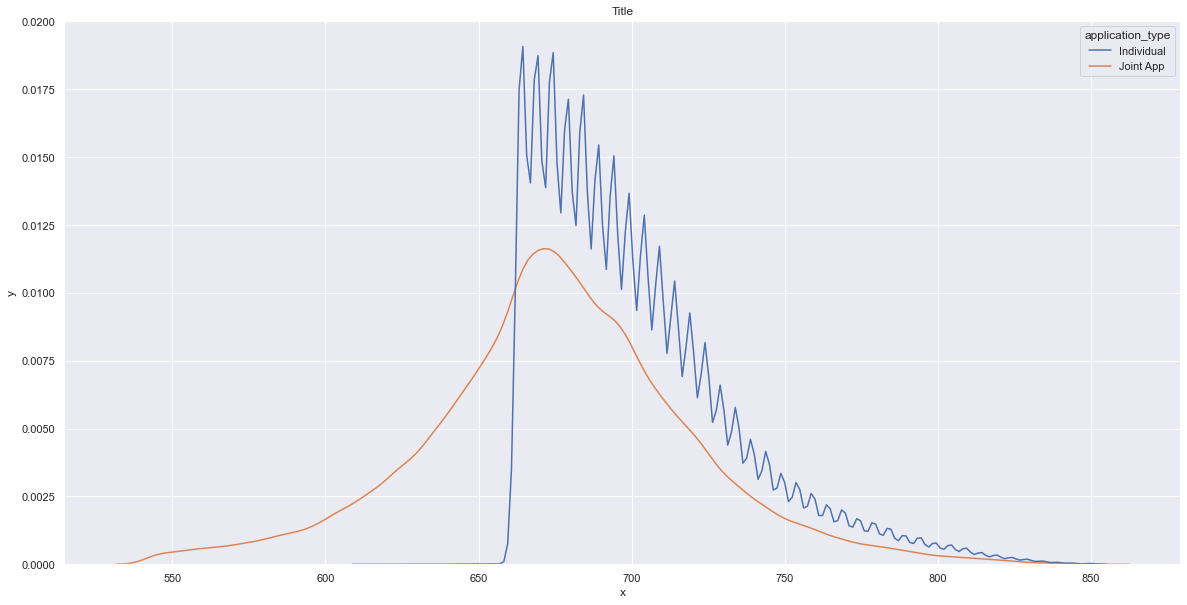

In [43]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    x=df["sec_app_fico_range_high"].fillna(df["fico_range_high"]),
    hue=df["application_type"],
    common_norm=False
)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Title")

plt.show()

In [ ]:
df.loc[:, df.columns[df.dtypes == "object"]].nunique()

term                              2
emp_title                    512694
emp_length                       11
home_ownership                    6
verification_status               3
issue_d                         139
purpose                          14
title                         63155
zip_code                        956
addr_state                       51
earliest_cr_line                754
initial_list_status               2
application_type                  2
verification_status_joint         3
sec_app_earliest_cr_line        663
disbursement_method               2
dtype: int64

In [ ]:
df.loc[:, df.columns[~(df.dtypes == "object")]].nunique().sort_values().head()

policy_code               1
num_tl_30dpd              5
sec_app_inq_last_6mths    7
num_tl_120dpd_2m          7
acc_now_delinq            9
dtype: int64

In [ ]:
(df["fico_range_high"] - df["fico_range_low"]).value_counts()

4.0    2260227
5.0        441
dtype: int64

In [ ]:
top_value_percentage = (df.loc[:, df.columns[~(df.dtypes == "string")]].apply(lambda x: x.value_counts().max(), axis=0)*100/df.shape[0])
top_value_percentage[top_value_percentage>50].sort_values()

title                         51.014840
purpose                       56.525697
inq_last_6mths                61.119184
initial_list_status           67.919950
term                          71.205967
num_accts_ever_120_pd         74.641273
delinq_2yrs                   81.351227
tot_coll_amt                  82.104135
pub_rec                       84.166725
pub_rec_bankruptcies          87.910033
num_tl_90g_dpd_24m            91.699875
num_tl_120dpd_2m              93.145356
application_type              94.659046
disbursement_method           96.542886
num_tl_30dpd                  96.632018
tax_liens                     97.135048
collections_12_mths_ex_med    98.336091
chargeoff_within_12_mths      99.232008
acc_now_delinq                99.608794
delinq_amnt                   99.679922
policy_code                   99.998540
dtype: float64

In [ ]:
df.isnull().sum().sort_values().head()

loan_amnt              33
disbursement_method    33
application_type       33
policy_code            33
initial_list_status    33
dtype: int64

In [ ]:
df.isna().all(axis=1).sum()

33

In [ ]:
titles = titles.drop(titles.columns[~titles.columns.isin(df.columns)], axis=1)

In [ ]:
df.head().append(titles)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11572\4213556082.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(titles)


loan_amnt  \
0                                                                                                                                                                                  3600.0   
1                                                                                                                                                                                 24700.0   
2                                                                                                                                                                                 20000.0   
3                                                                                                                                                                                 35000.0   
4                                                                                                                                                                                 10400.0   
Description  The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.   

                                                                                             term  \
0                                                                                       36 months   
1                                                                                       36 months   
2                                                                                       60 months   
3                                                                                       60 months   
4                                                                                       60 months   
Description  The number of payments on the loan. Values are in months and can be either 36 or 60.   

                              grade                  sub_grade  \
0                                 C                         C4   
1                                 C                         C1   
2                                 B                         B4   
3                                 C                         C5   
4                                 F                         F1   
Description  LC assigned loan grade  LC assigned loan subgrade   

                                                                       emp_title  \
0                                                                        leadman   
1                                                                       Engineer   
2                                                                   truck driver   
3                                                    Information Systems Officer   
4                                                            Contract Specialist   
Description  The job title supplied by the Borrower when applying for the loan.*   

                                                                                                                                     emp_length  \
0                                                                                                                                     10+ years   
1                                                                                                                                     10+ years   
2                                                                                                                                     10+ years   
3                                                                                                                                     10+ years   
4                                                                                                                                       3 years   
Description  Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.    

                                                              

In [ ]:
def clean_data_2_1(df):
    
    df = df.drop(df[df.isna().all(axis=1)].index, axis=0)
    
    df["risk_score"] = (df["fico_range_high"] + df["fico_range_low"])/2
    df["sec_risk_score"] = (df["sec_app_fico_range_high"] + df["sec_app_fico_range_low"])/2
    df = df.drop(["fico_range_high", "fico_range_low", "sec_app_fico_range_high", "sec_app_fico_range_low", "title", "url", "funded_amnt"], axis=1)

    df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]] = df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]].astype("datetime64[D]")
    
    

    second_account_columns = (df.columns[df.columns.str.contains("sec")]).tolist()
    for column in second_account_columns:
        primary_column = column.replace("sec_app_", "")
        df[column] = df[column].fillna(df[primary_column])
        if df[column].dtype == "float":
            df[primary_column] = (df[primary_column] + df[column])/2
        else:
            df[primary_column] = df[primary_column] + ((df[primary_column] - df[column])/2)
        df = df.drop(column, axis=1)
    
    joint_columns = (df.columns[df.columns.str.contains("joint")]).tolist()
    for column in joint_columns:
        primary_column = column.replace("_joint", "")
        df[primary_column] = df[column].fillna(df[primary_column])
        df = df.drop(column, axis=1)
        
    top_value_percentage = (df.loc[:, df.columns[~(df.dtypes == "string")]].apply(lambda x: x.value_counts().max(), axis=0)*100/df.shape[0])
    df = df.drop(top_value_percentage[top_value_percentage>98].index, axis=1)
    
    return df

In [ ]:
df = clean_data_2_1(df)

In [ ]:
missing_percentage = df.isnull().sum()*100/ df.shape[0]
missing_percentage[missing_percentage>30].sort_values()

open_act_il                       38.312968
open_il_12m                       38.312968
open_il_24m                       38.312968
total_bal_il                      38.312968
inq_fi                            38.312968
open_rv_12m                       38.312968
open_rv_24m                       38.312968
max_bal_bc                        38.312968
inq_last_12m                      38.313012
total_cu_tl                       38.313012
open_acc_6m                       38.313012
all_util                          38.322655
mths_since_rcnt_il                40.250227
il_util                           47.280273
mths_since_last_delinq            51.246003
mths_since_recent_revol_delinq    67.250432
mths_since_last_major_derog       74.309585
mths_since_recent_bc_dlq          77.011175
mths_since_last_record            84.112837
dtype: float64

In [ ]:
def clean_data_2_2(df):
    df["emp_length"] = df["emp_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["emp_length"] = df["emp_length"].str.extract(r"([0-9]+)").astype("float")
    df = df.rename(columns={"emp_length" : "emp_length_years"})
    
    df["home_ownership"] = df["home_ownership"].str.lower()
    df = df.rename(columns={"addr_state":"state"})
    
    df["mths_since_earliest_cr_line"] = ((df["issue_d"] - df["earliest_cr_line"])/np.timedelta64(1, 'M')).round()
    df = df.drop("earliest_cr_line", axis=1)
    
    sub_grade = pd.Series(df["sub_grade"].dropna().unique()).sort_values(ascending=False).tolist()
    sub_grade_dict = {}
    grade_dict = {}
    num = 0
    for grade in sub_grade:
        sub_grade_dict[grade] = num
        if ((num == 4) | (num%5 == 4)):
            grade_dict[grade[0]] = num
        num += 1
        
    df["sub_grade"] = df["sub_grade"].replace(sub_grade_dict)
    df["grade"] = df["grade"].replace(grade_dict)
    
    corr_df = pd.DataFrame(columns = ["col1", "col2", "corr"])
    numeric_cols = df.columns[((df.dtypes == "float") | (df.dtypes == "int")) & (~df.columns.isin(["sub_grade", "int_rate", "grade"]))]
    for column in numeric_cols:
        if column in df.columns:
            col_corr = df.corrwith(df[column])
            multicoll_list = col_corr[(col_corr > 0.7) & (col_corr.index != column)].index.tolist()
            if multicoll_list:
                for corr in multicoll_list:
                    if np.abs(df[corr].corr(df["sub_grade"])) < np.abs(df[column].corr(df["sub_grade"])):
                        df = df.drop(corr, axis=1)
                    else:
                        df = df.drop(column, axis=1)
                        break
    
    df = df.convert_dtypes()
    
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    
    return df

In [ ]:
df = clean_data_2_2(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2260668 entries, 0 to 2260698
Data columns (total 57 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   loan_amnt               Int32         
 1   term                    string        
 2   grade                   Int8          
 3   sub_grade               Int8          
 4   emp_title               string        
 5   emp_length_years        Int8          
 6   home_ownership          string        
 7   annual_inc              Float32       
 8   verification_status     string        
 9   issue_d                 datetime64[ns]
 10  purpose                 string        
 11  zip_code                string        
 12  state                   string        
 13  dti                     Float32       
 14  delinq_2yrs             Int8          
 15  inq_last_6mths          Float32       
 16  mths_since_last_delinq  Int16         
 17  mths_since_last_record  Int16         
 18  pu

In [ ]:
df.head().append(titles)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11572\4213556082.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(titles)


loan_amnt  \
0                                                                                                                                                                                    3600   
1                                                                                                                                                                                   24700   
2                                                                                                                                                                                   20000   
3                                                                                                                                                                                   35000   
4                                                                                                                                                                                   10400   
Description  The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.   

                                                                                             term  \
0                                                                                       36 months   
1                                                                                       36 months   
2                                                                                       60 months   
3                                                                                       60 months   
4                                                                                       60 months   
Description  The number of payments on the loan. Values are in months and can be either 36 or 60.   

                              grade                  sub_grade  \
0                                 C                         21   
1                                 C                         24   
2                                 B                         26   
3                                 C                         20   
4                                 F                          9   
Description  LC assigned loan grade  LC assigned loan subgrade   

                                                                       emp_title  \
0                                                                        leadman   
1                                                                       Engineer   
2                                                                   truck driver   
3                                                    Information Systems Officer   
4                                                            Contract Specialist   
Description  The job title supplied by the Borrower when applying for the loan.*   

             emp_length_years  \
0                          15   
1                          15   
2                          15   
3                          15   
4                           3   
Description              <NA>   

                                                                                                                                                    home_ownership  \
0                                                                                                                                                         mortgage   
1                                                                                                                                                         mortgage   
2                                                                                                                                                         mortgage   
3                                                                                                                                                         mortgage   
4                             

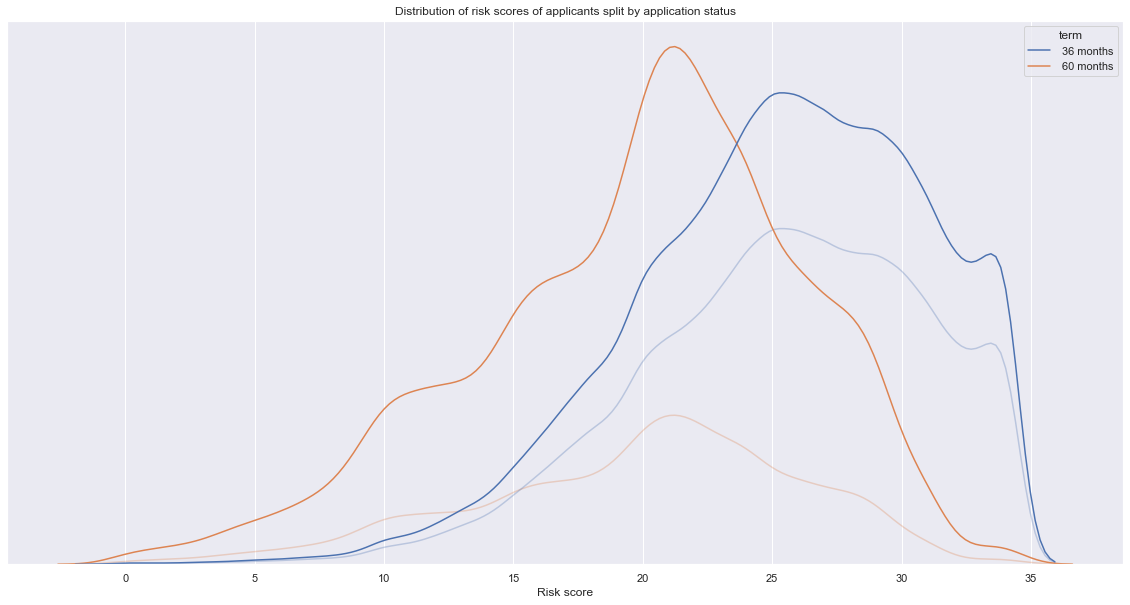

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="term",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="term",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

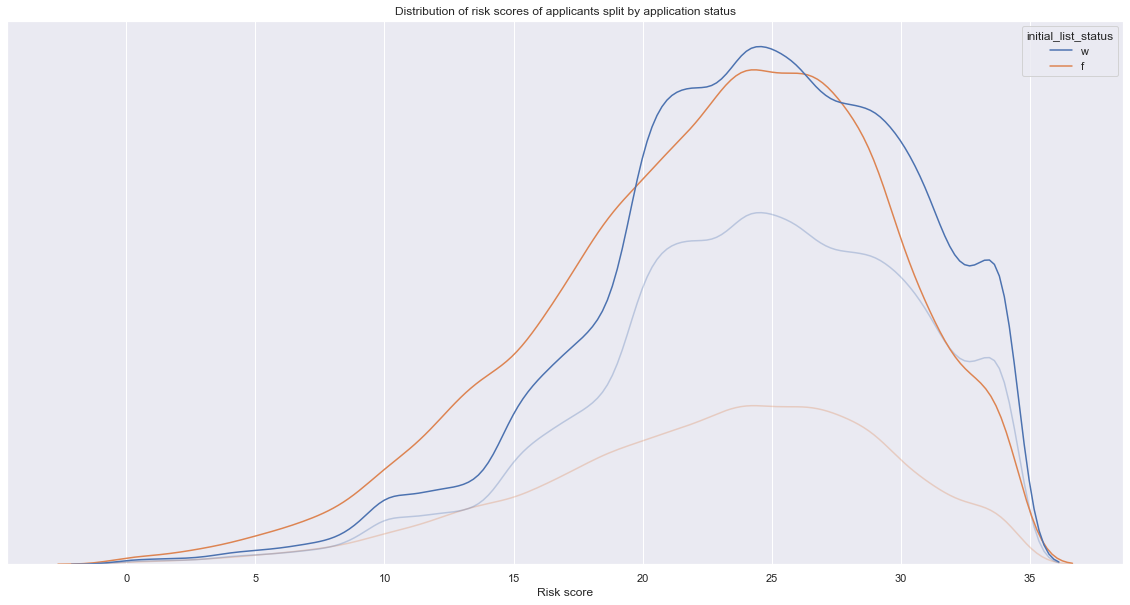

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="initial_list_status",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="initial_list_status",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

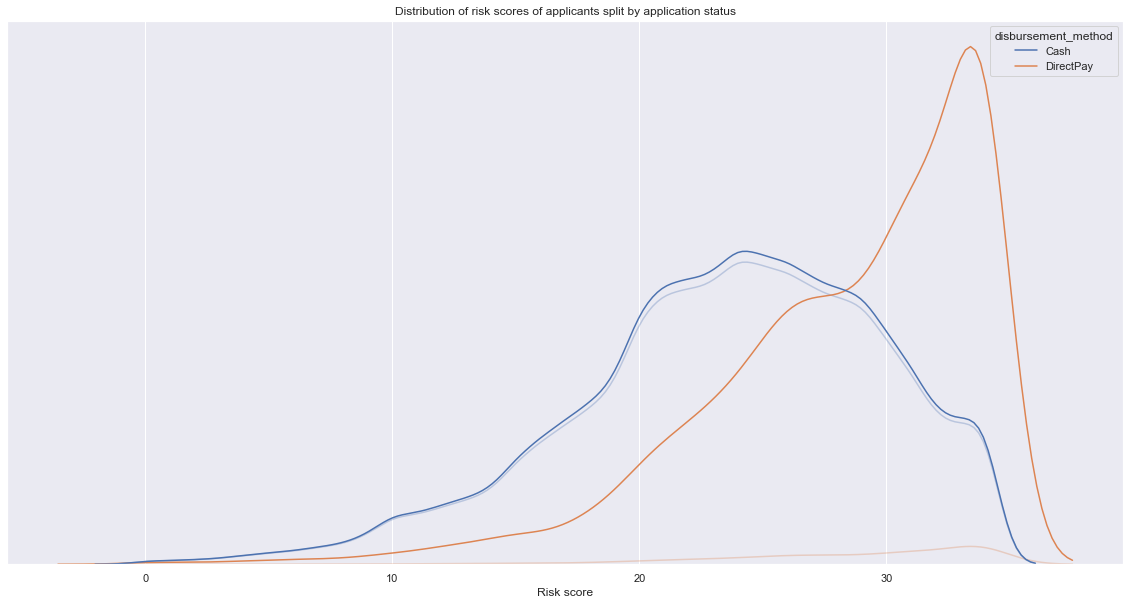

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="disbursement_method",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="disbursement_method",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

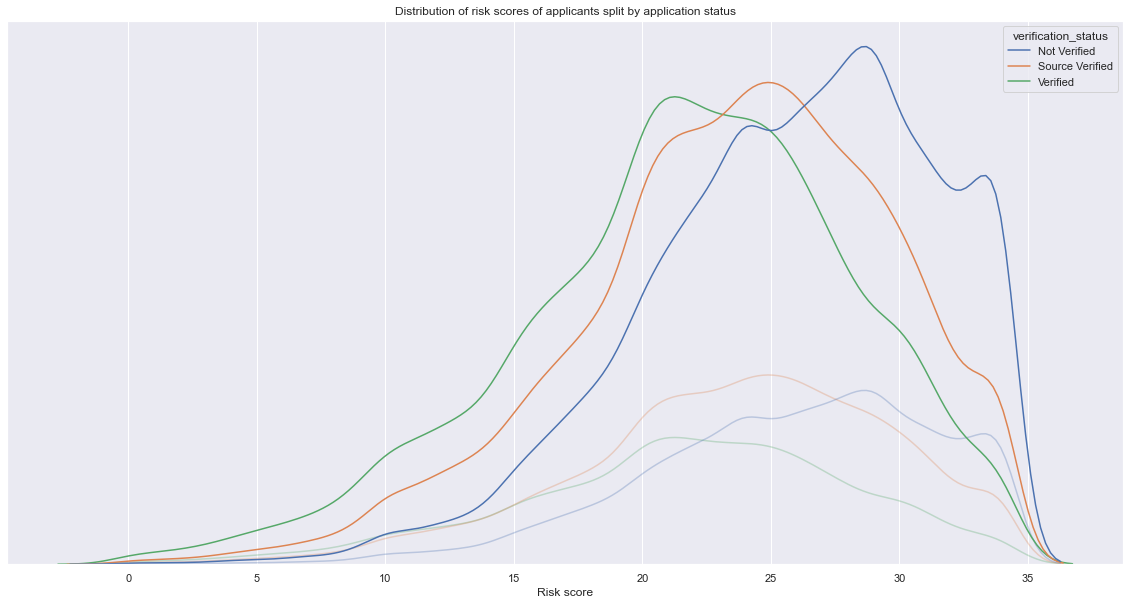

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="verification_status",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="verification_status",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [ ]:
df["purpose"].value_counts()*100/df.shape[0]

debt_consolidation    56.526522
credit_card           22.868064
home_improvement       6.655422
other                  6.168088
major_purchase          2.23142
medical                1.215924
small_business         1.092111
car                    1.062208
vacation               0.686744
moving                 0.681347
house                  0.625302
wedding                0.104173
renewable_energy       0.063919
educational            0.018756
Name: purpose, dtype: Float64

In [ ]:
largest_purposes = df["purpose"].value_counts()[(df["purpose"].value_counts()*100/df.shape[0])>5].index
temp_df = df.loc[df["purpose"].isin(largest_purposes), ["purpose", "sub_grade"]]

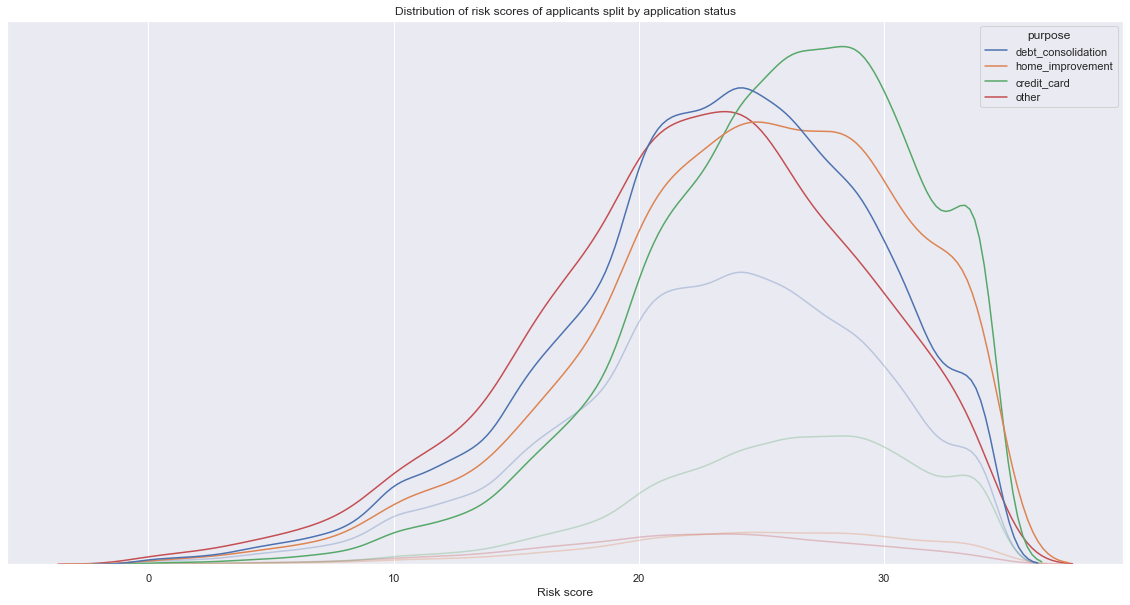

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="purpose",
    palette=[colors["blue"], colors["orange"], colors["green"], colors["red"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="purpose",
    palette=[colors["blue"], colors["orange"], colors["green"], colors["red"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [84]:
df["home_ownership"].value_counts()*100/df.shape[0]

mortgage    48.205712
rent        40.445887
own         11.291016
any          0.046496
other        0.008505
none         0.002383
Name: home_ownership, dtype: float64

In [85]:
largest_home_ownership = df["home_ownership"].value_counts()[(df["home_ownership"].value_counts()*100/df.shape[0])>5].index
temp_df = df.loc[df["home_ownership"].isin(largest_home_ownership), ["home_ownership", "sub_grade"]]

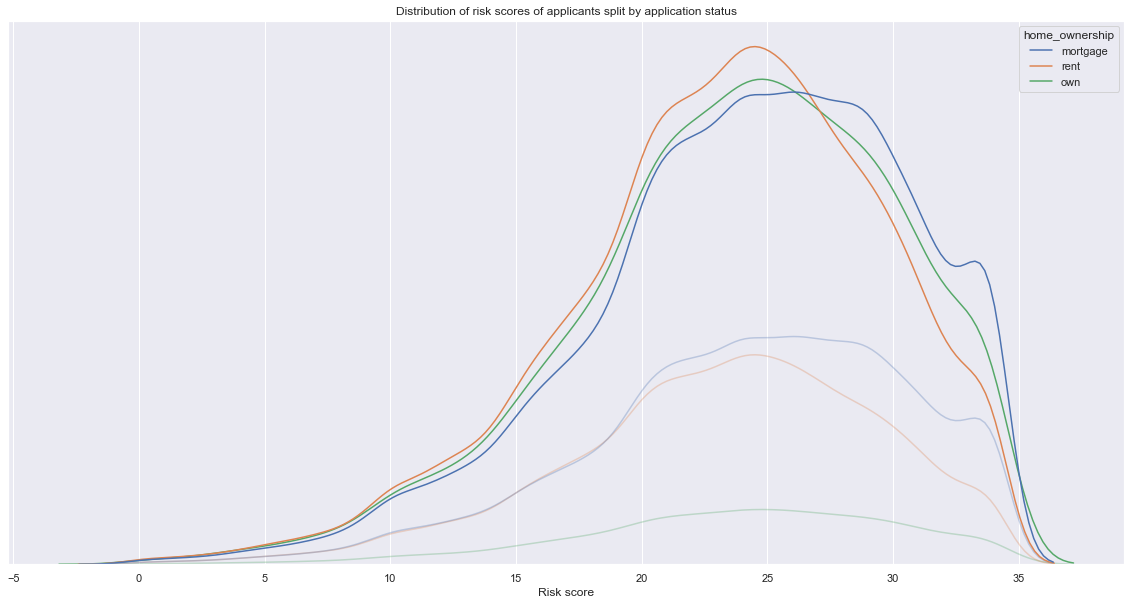

In [88]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="home_ownership",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    alpha=0.3
)
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="home_ownership",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    common_norm=False
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [ ]:




#TODO: Explore employee title





In [102]:
df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")
prof_df.head()

total
manager     291503
director     77294
sales        69221
assistant    68137
supervisor   55071

In [104]:
prof_df.shape[0]

95854

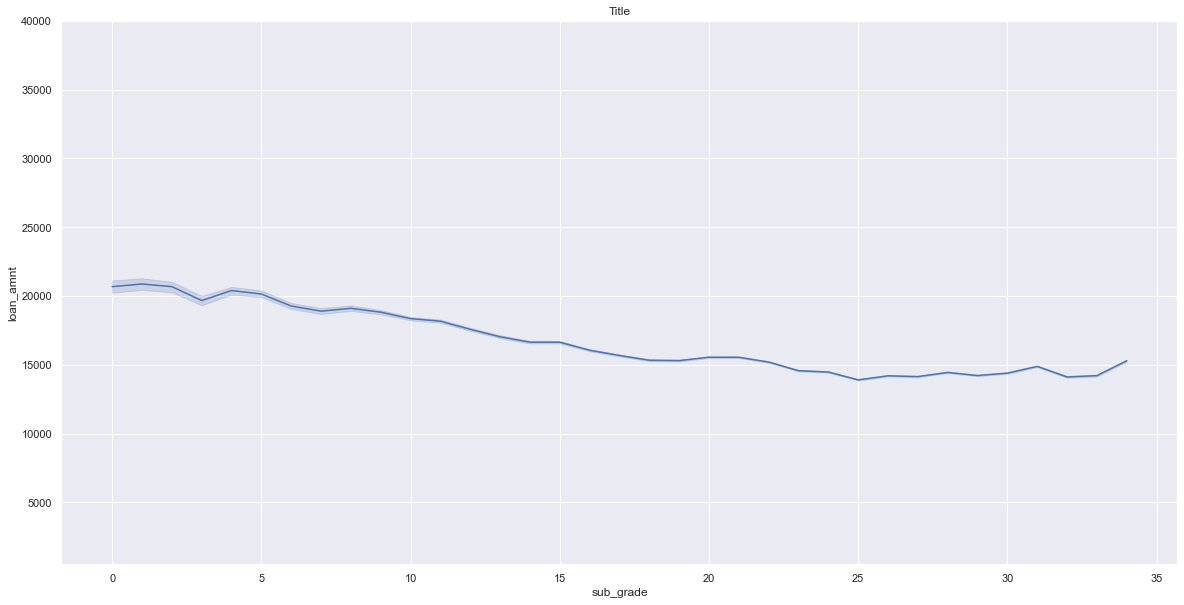

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="loan_amnt",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["loan_amnt"].min(), df["loan_amnt"].max()])
plt.show()

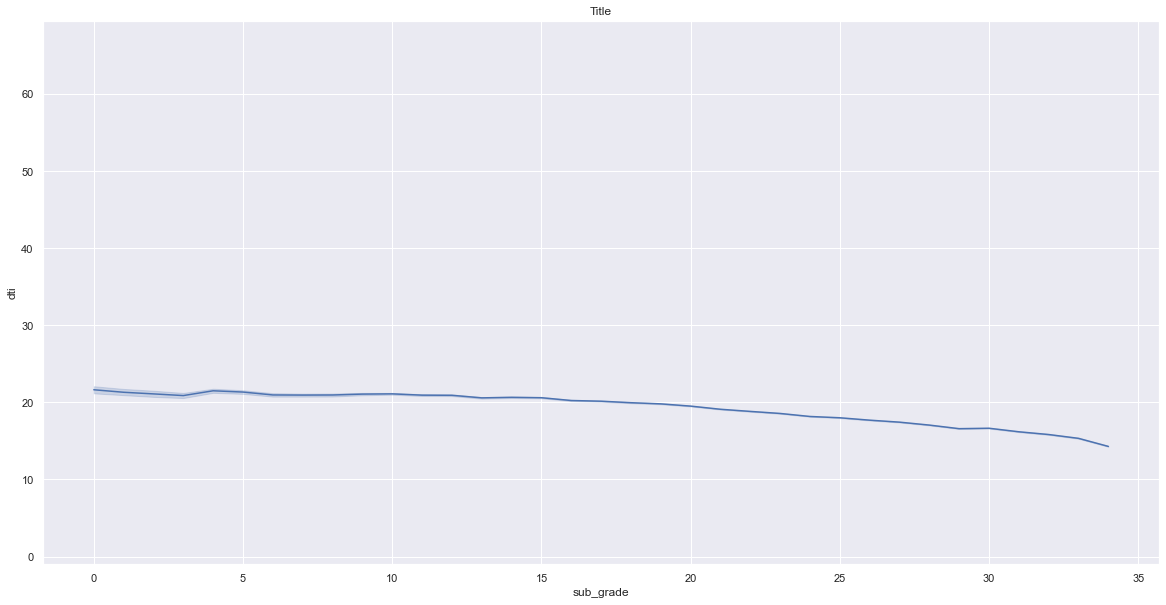

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="dti",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["dti"].min(), df["dti"].max()])
plt.show()

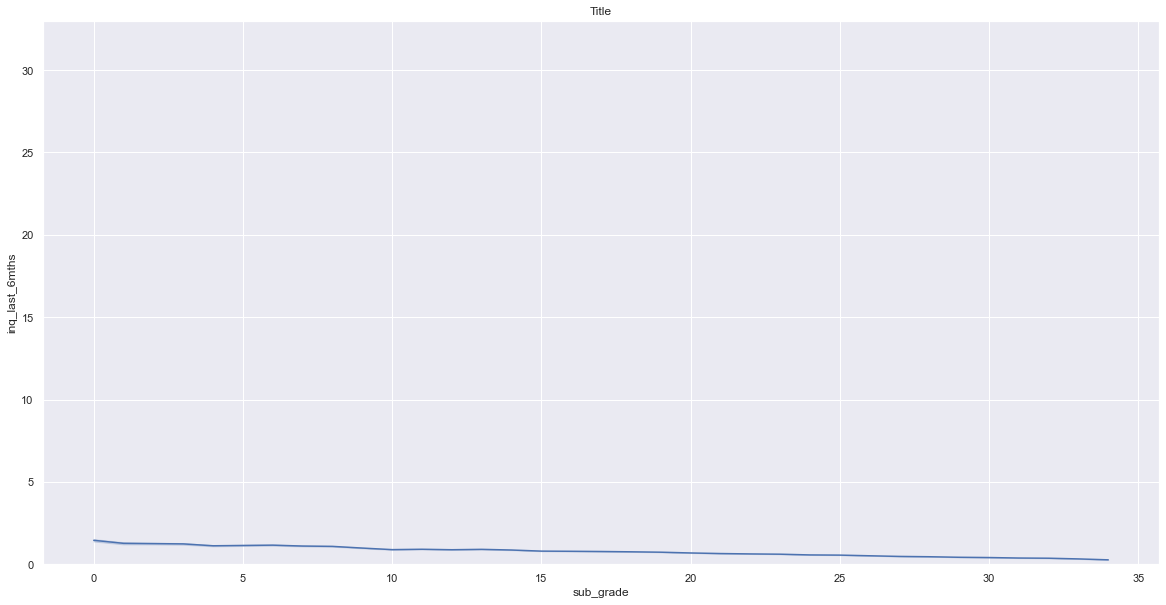

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="inq_last_6mths",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["inq_last_6mths"].min(), df["inq_last_6mths"].max()])
plt.show()

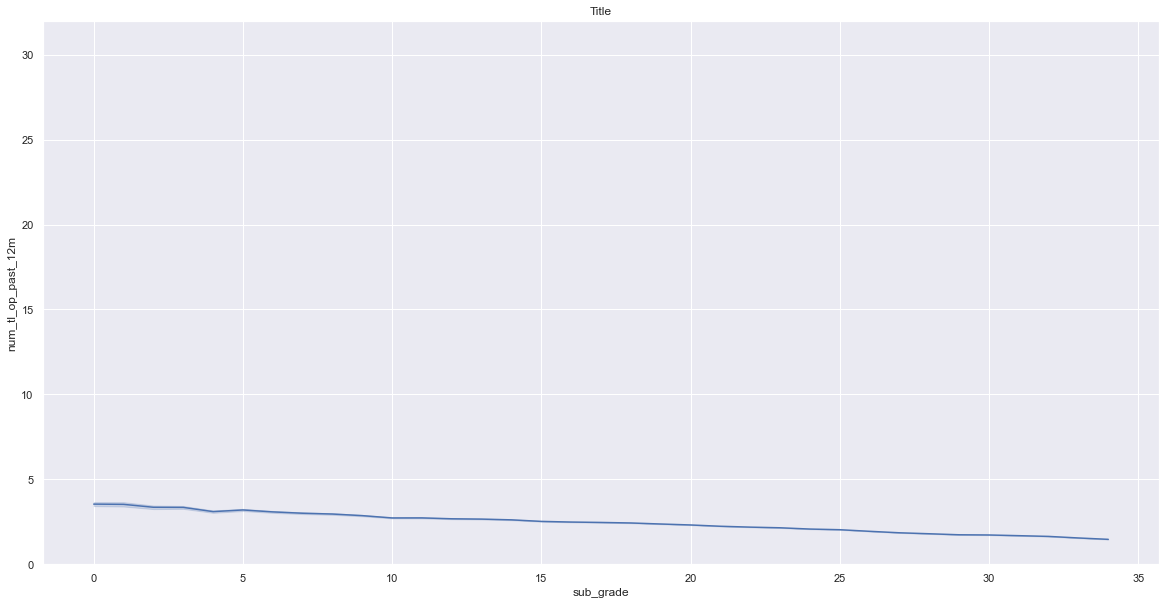

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="num_tl_op_past_12m",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["num_tl_op_past_12m"].min(), df["num_tl_op_past_12m"].max()])
plt.show()

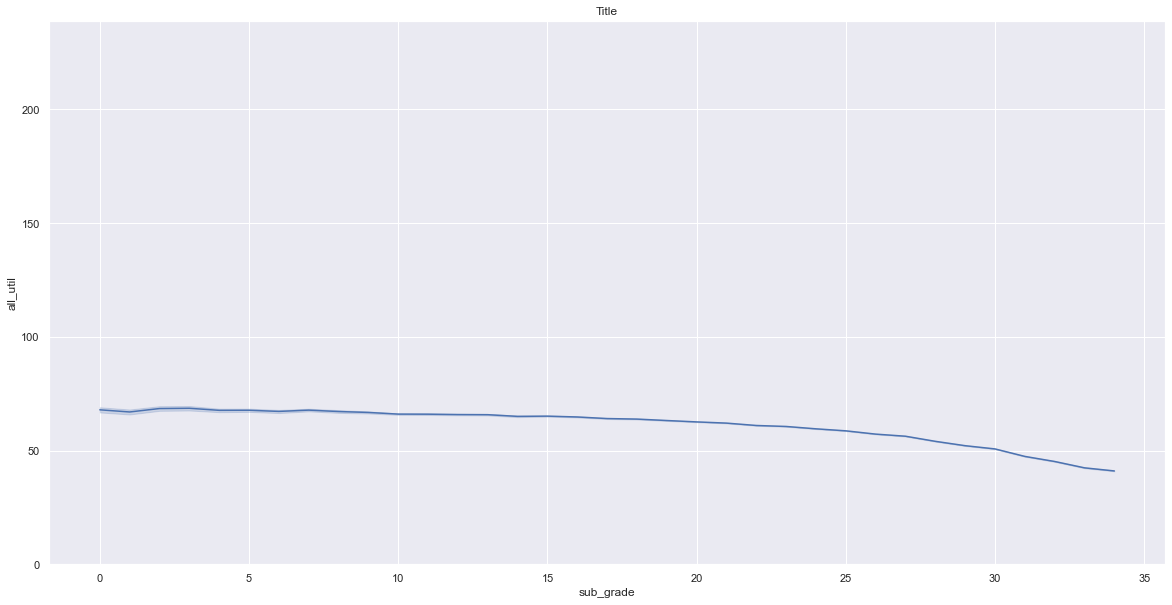

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="all_util",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["all_util"].min(), df["all_util"].max()])
plt.show()

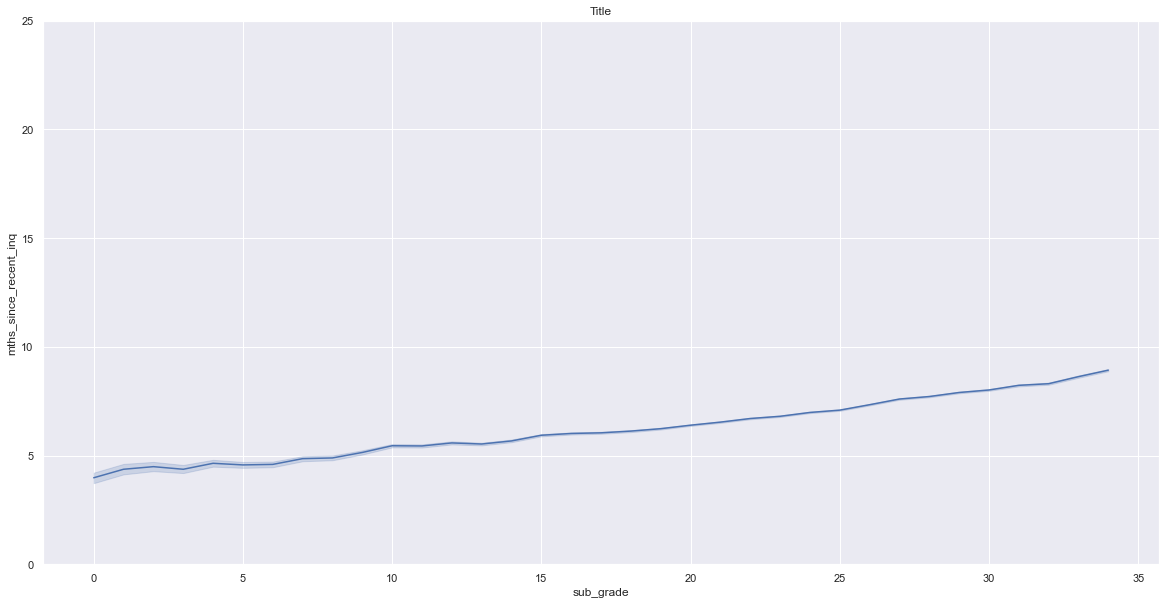

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="mths_since_recent_inq",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["mths_since_recent_inq"].min(), df["mths_since_recent_inq"].max()])
plt.show()

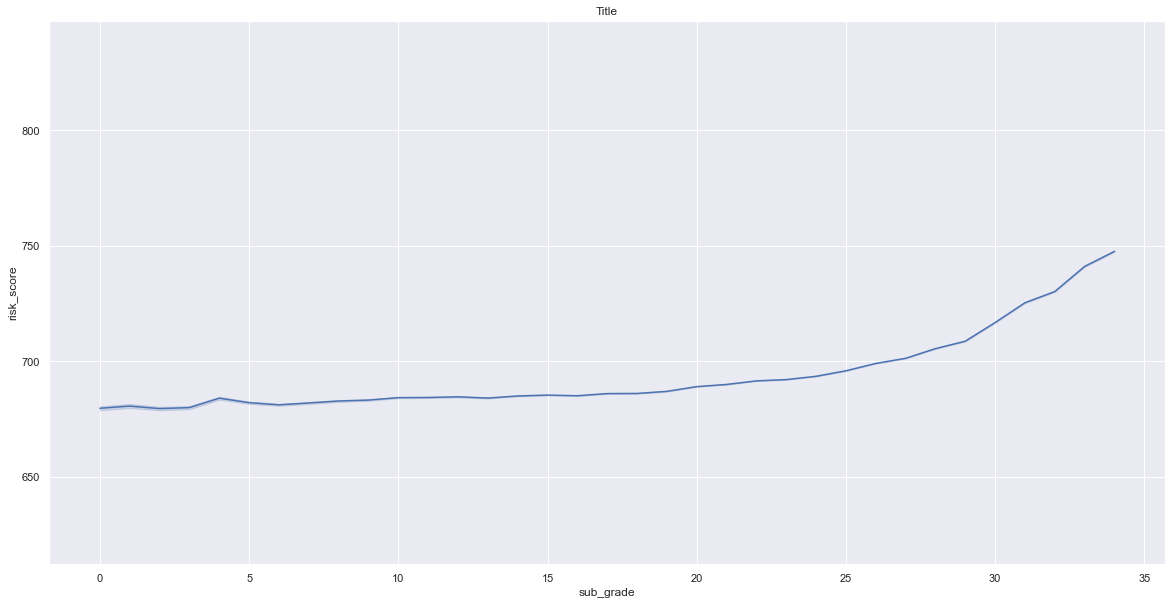

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="risk_score",
    markers=True
)
ax.set_title("Title")
ax.set_ylim([df["risk_score"].min(), df["risk_score"].max()])
plt.show()

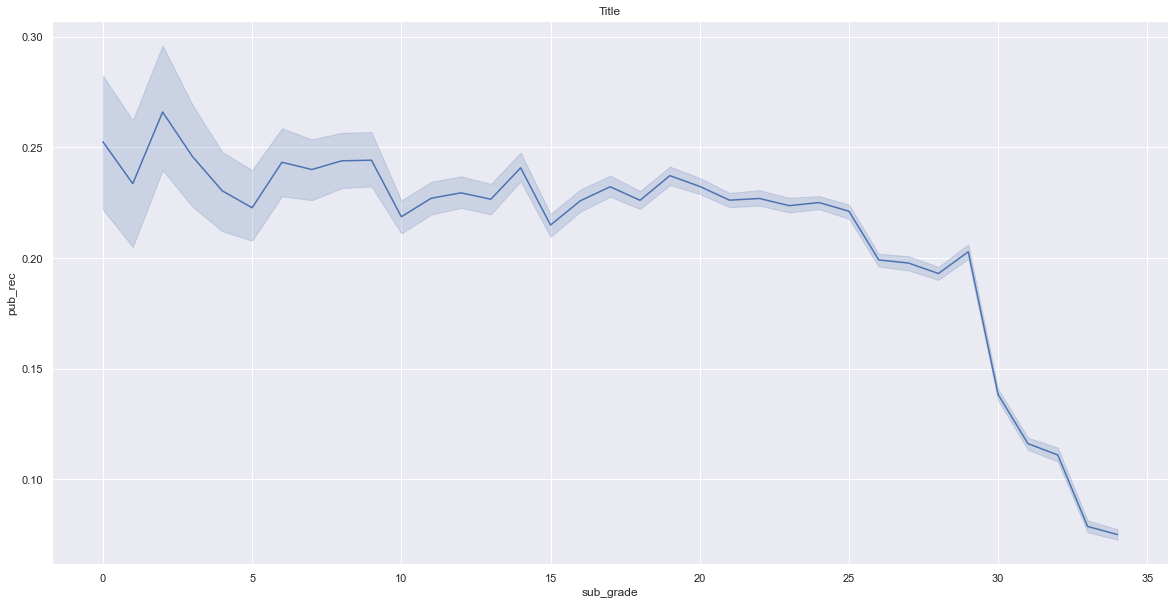

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="pub_rec",
    markers=True
)
ax.set_title("Title")
plt.show()

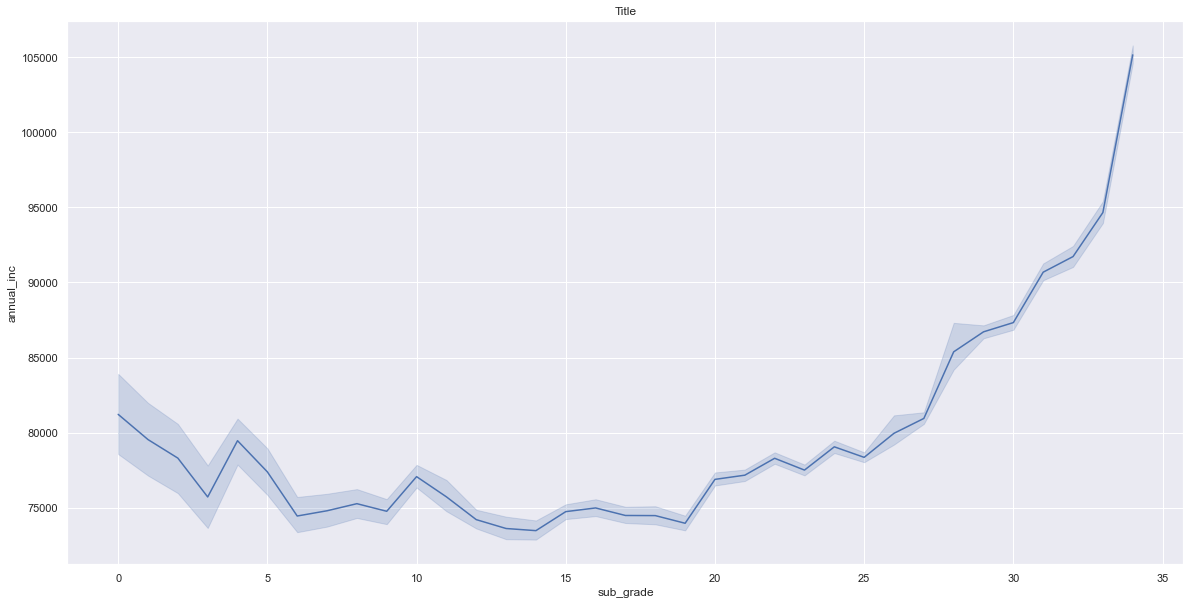

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(
    data=df,
    x="sub_grade",
    y="annual_inc",
    markers=True
)
ax.set_title("Title")
plt.show()

In [8]:
def clean_data_2_1(df):
    """
    Function 1 of 2 for cleaning data for second task - transforming data into correct format, dropping columns with too little variability, etc.
    """
    df = df.drop(df[df.isna().all(axis=1)].index, axis=0)
    
    df["risk_score"] = (df["fico_range_high"] + df["fico_range_low"])/2
    df["sec_risk_score"] = (df["sec_app_fico_range_high"] + df["sec_app_fico_range_low"])/2
    df = df.drop(["fico_range_high", "fico_range_low", "sec_app_fico_range_high", "sec_app_fico_range_low", "title", "url", "funded_amnt"], axis=1)
    
    df["emp_length"] = df["emp_length"].replace({"10+ years":"15", "< 1 year":"0"})
    df["emp_length"] = df["emp_length"].str.extract(r"([0-9]+)").astype("float")
    df = df.rename(columns={"emp_length" : "emp_length_years"})
    
    df["home_ownership"] = df["home_ownership"].str.lower()
    df = df.rename(columns={"addr_state":"state"})
    
    sub_grade = pd.Series(df["sub_grade"].dropna().unique()).sort_values(ascending=False).tolist()
    sub_grade_dict = {}
    grade_dict = {}
    num = 0
    grade_num = 7
    for grade in sub_grade:
        sub_grade_dict[grade] = num
        if ((num == 5) | (num%5 == 0)):
            grade_dict[grade[0]] = grade_num
            grade_num -= 1
        num += 1
    
    df["sub_grade"] = df["sub_grade"].replace(sub_grade_dict)
    df["grade"] = df["grade"].replace(grade_dict)
    
    df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]] = df.loc[:, ["earliest_cr_line", "issue_d", "sec_app_earliest_cr_line"]].astype("datetime64[D]")
    df["mths_since_earliest_cr_line"] = ((df["issue_d"] - df["earliest_cr_line"])/np.timedelta64(1, 'M')).round()
    df = df.drop("earliest_cr_line", axis=1)
    
    top_value_percentage = (df.loc[:, df.columns[~(df.dtypes == "string")]].apply(lambda x: x.value_counts().max(), axis=0)*100/df.shape[0]).fillna(100)
    df = df.drop(top_value_percentage[top_value_percentage>98].index, axis=1)
    
    
    return df

In [9]:
def columns_to_drop_due_multicoll(df):
    """
    Function that calculates which between two features with correlation value over 0.7 is higher correlated with the target column. Returns a list with all the columns that should be dropped to avoid multicollinearity.
    """
    columns_to_drop = []
    corr_df = pd.DataFrame(columns = ["col1", "col2", "corr"])
    numeric_cols = df.columns[((df.dtypes == "float") | (df.dtypes == "int")) & (~df.columns.isin(["sub_grade", "int_rate", "grade"]))]
    for column in numeric_cols:
        if column in df.columns:
            col_corr = df.corrwith(df[column])
            multicoll_list = col_corr[(col_corr > 0.7) & (col_corr.index != column)].index.tolist()
            if multicoll_list:
                for corr in multicoll_list:
                    if np.abs(df[corr].corr(df["sub_grade"])) < np.abs(df[column].corr(df["sub_grade"])):
                        columns_to_drop.append(corr)
                    else:
                        columns_to_drop.append(column)
                        break
    return columns_to_drop

In [10]:
def get_best_corrs_missing_cols(df_input, months_columns, columns_to_drop):
    """
    A function that calculates the most correlated features for columns with missing data. Also calculates mean missing column values for each binned correlated column interval for imputation.
    
    Parameters:
        df_input(pd.DataFrame): All data
        months_columns(list): A list containing features that contain "number_of_months_since_X" data
        columns_to_drop(list): A list containing features to drop to avoid multicollinearity
        
    Returns:
        best_corrs_means_dict({str:pd.Series}): A dictionary containing series with missing_col mean values for each corr_col interval for each feature pair in max_corr_pairs.
        max_corr_pairs(pd.Series): A series containing missing_col and corr_col pairs.
    """
    df = df_input.copy()
    missing_values = df.columns[((df.isna().sum()*100/df.shape[0])>1) & (~df.columns.isin(columns_to_drop)) & (df.dtypes == "float") & (~df.columns.isin(months_columns))]
    
    corr_df = pd.DataFrame()
    for column in missing_values:
        corr_df[column] = df.loc[:, df.columns[df.dtypes == "float"]].corrwith(df[column].astype("float"))
    corr_df[corr_df> 0.99] = np.nan
    corr_df[np.abs(corr_df)<0.1] = np.nan
    
    max_corr_pairs = np.abs(corr_df).idxmax()
    max_corr_pairs = max_corr_pairs.dropna(axis=0)
    best_corrs_means_dict = {}
    
    for column in max_corr_pairs.index:
        df.loc[:, "temp_column"] = pd.cut(df[max_corr_pairs[column]], 10)
        best_corrs_means_dict[column] = df.groupby("temp_column")[column].median().to_frame().reset_index().rename(columns={"temp_column":"bin_column", column:"medians"})
    return best_corrs_means_dict, max_corr_pairs
 

In [11]:
def get_positive_negative_careers(df_input):
    """
    A function that calculates which carrer names in the "emp_title" column correlate positively and which negatively with target column.
    
    Returns:
        negative_corr_careers(list): List containing 20 careers that negatively correlate with target column
        positive_corr_careers(list): List containing 20 careers that positively correlate with target column
    """
    df = df_input.copy()
    df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
    prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")

    corr_words = pd.Series(name = "correlation")
    for word in prof_df.head(400).index.tolist():
        words_one_hot = df.loc[:, ["emp_title", "sub_grade"]]

        words_one_hot.loc[words_one_hot["emp_title"].str.contains(fr"(?:^|\W){word}(?:$|\W)").fillna(False), "word"] = 1
        words_one_hot.loc[:, "word"] = words_one_hot.loc[:, "word"].fillna(0).astype(int)
        corr_words[word] = words_one_hot["word"].corr(words_one_hot["sub_grade"].astype("float"))

    negative_corr_careers = corr_words.sort_values().head(20).index.tolist()
    positive_corr_careers = corr_words.sort_values(ascending=False).head(20).index.tolist()
    
    return negative_corr_careers, positive_corr_careers

In [8]:
def clean_data_2_3(df):
    
    corr_df = pd.DataFrame(columns = ["col1", "col2", "corr"])
    numeric_cols = df.columns[((df.dtypes == "float") | (df.dtypes == "int")) & (~df.columns.isin(["sub_grade", "int_rate", "grade"]))]
    for column in numeric_cols:
        if column in df.columns:
            col_corr = df.corrwith(df[column])
            multicoll_list = col_corr[(col_corr > 0.7) & (col_corr.index != column)].index.tolist()
            if multicoll_list:
                for corr in multicoll_list:
                    if np.abs(df[corr].corr(df["sub_grade"])) < np.abs(df[column].corr(df["sub_grade"])):
                        df = df.drop(corr, axis=1)
                    else:
                        df = df.drop(column, axis=1)
                        break
    
    df = df.convert_dtypes()
    
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    
    return df

## Data cleaning and engineering

Now let's see what we can do about the missing data. Since during EDA we dropped some columns that might be useful for us, we'll reload our data. We'll also set aside sub_grade and int_rate columns - we'll need those for the third task.

In [12]:
df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

sub_grade = df["sub_grade"]
int_rate = df["int_rate"]

df = df.loc[:, original_columns + ["disbursement_method"]]
df = clean_data_2_1(df)

df = df.drop(df.columns[df.columns.str.contains("joint") | df.columns.str.contains("sec_")], axis=1)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2851496577.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


There are a lot of columns in the dataset - it's possible that at least some of them have been introduced to the dataset later and that could explain at least some of our missing data.

In [184]:
earliest_values = pd.Series()
for column in df.columns:
    earliest_values[column] = df.loc[~df[column].isna(), "issue_d"].min()
earliest_values = earliest_values.to_frame()

earliest_values["missing_data"] = df.isna().sum()
earliest_values = earliest_values.rename(columns={0:"earliest_value"}).sort_values(["earliest_value", "missing_data"])

for column in df.columns:
    earliest_values.loc[column, "missing_after"] = df.loc[df["issue_d"]>earliest_values.loc[column, "earliest_value"],column].isna().sum()

earliest_values[earliest_values["missing_data"]> earliest_values["missing_after"]*3].shape[0]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13216\3898038055.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  earliest_values = pd.Series()


52

We can see that for 52 columns the majority of their missing data is in applications originating before they were introduced. Let's take a look at some of them!

In [187]:
earliest_values["missing_after_2015"] = df.loc[df["issue_d"]> pd.to_datetime("2015-12")].isna().sum() 
(earliest_values["missing_after_2015"].sum()*100/earliest_values["missing_data"].sum()).round(2)

22.36

If we decide to drop applications that originate before the end of 2015, only 22 % of the missing values remain. 

In [188]:
earliest_values.sort_values("missing_after", ascending=False).head(10)

earliest_value  missing_data  missing_after  \
mths_since_last_record             2007-06-01       1797698      1797677.0   
mths_since_recent_bc_dlq           2012-08-01       1643724      1572810.0   
mths_since_last_major_derog        2012-08-01       1584293      1513337.0   
mths_since_recent_revol_delinq     2012-03-01       1434092      1383621.0   
mths_since_last_delinq             2007-06-01       1091165      1091144.0   
mths_since_recent_inq              2012-03-01        279318       229251.0   
il_util                            2015-12-01       1048237       179784.0   
emp_title                          2007-06-01        148559       148554.0   
emp_length_years                   2007-06-01        130357       130357.0   
num_tl_120dpd_2m                   2012-08-01        153656        83460.0   

                                missing_after_2015  
mths_since_last_record                     1047717  
mths_since_recent_bc_dlq                    964289  
mths_since_last_major_derog                 918940  
mths_since_recent_revol_delinq              837925  
mths_since_last_delinq                      637055  
mths_since_recent_inq                       142663  
il_util                                     179784  
emp_title                                    97147  
emp_length_years                             85583  
num_tl_120dpd_2m                             56034

And if we look at the features with the highest remaining missing value count in these 22%, we can see that a lot of them are features with "amount_of_months_since_X" values. For these features the presence of missing values is easily explainable - If you've never had a public record, value in mths_since_last_record column will be missing for you. We'll deal with these features by either binarizing them on whether the value is missing or not, or by imputing the missing values with an extremely large value.

In [13]:
months_columns = df.columns[df.columns.str.contains("mths_since_") | df.columns.str.contains("mo_sin_")]
other_columns = df.columns[~df.columns.isin(months_columns)]

In [191]:
(df.loc[:,months_columns].isna().sum()*100/df.shape[0]).sort_values(ascending=False)

mths_since_last_record            84.006228
mths_since_recent_bc_dlq          76.811040
mths_since_last_major_derog       74.033836
mths_since_recent_revol_delinq    67.014960
mths_since_last_delinq            50.990019
mths_since_rcnt_il                42.308774
mths_since_recent_inq             13.052499
mo_sin_old_il_acct                 6.302881
mths_since_recent_bc               3.301934
mo_sin_old_rev_tl_op               3.284036
mo_sin_rcnt_rev_tl_op              3.284036
mo_sin_rcnt_tl                     3.283990
mths_since_earliest_cr_line        0.001355
dtype: float64

In [192]:
(earliest_values.loc[other_columns,"missing_after_2015"].sum()*100/earliest_values.loc[other_columns,"missing_data"].sum()).round(2)

3.39

We can see that if we exclude the mths_since columns, the missing data amount is only 3.3% of the original number - a huge decrease. We'll be dropping the applications that are before the december of 2015.

In [195]:
df = df.loc[df["issue_d"]> pd.to_datetime("2015-12")]
df = df.drop("issue_d", axis=1)
df = df.drop(df[df["zip_code"].isna()].index)

(df.loc[:,other_columns].isna().sum()*100/df.shape[0]).sort_values(ascending=False).head(10)

il_util             14.347952
emp_title            7.752973
emp_length_years     6.830089
num_tl_120dpd_2m     4.471884
bc_util              1.168608
percent_bc_gt_75     1.128466
bc_open_to_buy       1.124236
revol_util           0.083797
all_util             0.017158
total_cu_tl          0.004948
dtype: float64

There are still some values missing that we have to deal with. For the columns with a lot of missing data, we will check whether they have a high correlation with any of the other columns, including the ones we are dropping to avoid multicollinearity, and impute the values using those. We will fill the rest of the missing values with column median.

Now that the missing data has been dealt with, let's get to training!

In [184]:
df2 = df.copy()
df = df2.sample(frac = 0.1, random_state=42)

We will once again be using a sample from the whole dataset to speed up the preliminary training.

In [185]:
train_set, test_set, train_grade, test_grade = train_test_split(
    df.loc[:, df.columns[df.columns != "grade"]],
    df["grade"],
    test_size=0.2,
    random_state=42,
    stratify=df["grade"],
)

In [186]:
columns_to_drop = columns_to_drop_due_multicoll(train_set)
best_corrs_means_dict, max_corr_pairs = get_best_corrs_missing_cols(train_set, months_columns, columns_to_drop)
negative_corr_careers, positive_corr_careers = get_positive_negative_careers(train_set)
train_set = train_set.drop("sub_grade", axis=1)

desc = train_set.describe()
skewed_columns = train_set.loc[:, ~(train_set.dtypes=="object")].columns[train_set.skew()> 1]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\503426307.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\503426307.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\503426307.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_words = pd.Series(name = "correlation")


I've made several utility functions that calculate values to be fed into pipeline. Columns_to_drop calculates which columns correlate too highly with each other and chooses the one that has a better correlation with the target column, get_best_corrs_missing_cols calculates best correlated features for each of the columns with a lot of missing data and also calculates values to impute, get_positive_negative_careers calculates which careers in "emp_title" column correlate positevily and negatively with the target column.

Preprocessing pipeline consists of:
    ZipStateToCoordinates - converts zip_code and state features into coordinates
    FilterCareers - Adds columns negative_corr_careers and positive_corr_careers based on whether the applicants career positively or negatively impacts loan grade
    SmallValuesToOther - Converts values in categorical features that have too small representation into a combined "other" feature
    FillMissingDataAccepted - Fills the missing data using the strategy I previously outlined
    TransformToLog - Transforms to log scale columns that are skewed
    OneHotPipeline - One hot encodes the remaining categorical features

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\317725514.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.median_impute = X1.loc[:, X1.columns[(~X1.columns.isin(self.columns_to_drop))]].median()


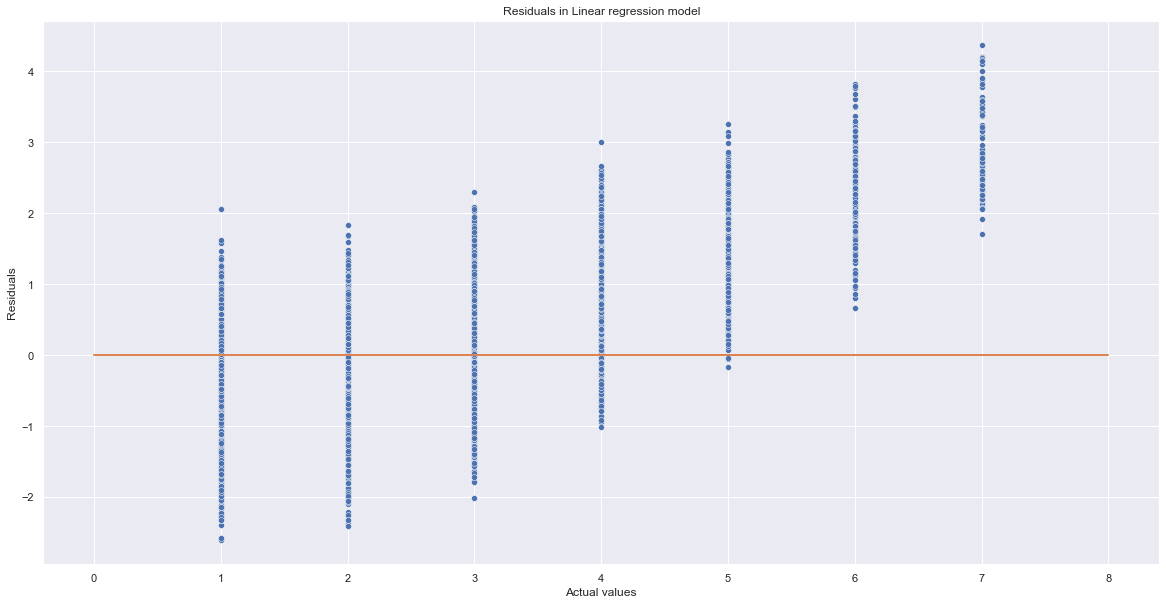

In [188]:
one_hot_columns = ["term", "verification_status", "initial_list_status", "disbursement_method", "purpose", "home_ownership", "application_type"]

OneHotPipeline = ColumnTransformer(
    [
        ("one_hot_columns",OneHotEncoder(drop="first", handle_unknown="ignore"), one_hot_columns)
    ], remainder="passthrough"
)

Preprocessor = Pipeline(
    [
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
        ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
        ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop)),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline)
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", MinMaxScaler()),
        ("linear_reg", LinearRegression()),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    train_set, train_grade, test_size=0.2, random_state=42, stratify=train_grade
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([0, 8], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [136]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5008934478165001

The r2 value is 0.50 - not great, not terrible. However, since we are predicting discrete data, we need to round the fractions to integers.

In [144]:
predictions = full_pipe.predict(test_set_val)
predictions = np.round(predictions)
predictions[predictions<1] = 1
predictions[predictions>7] = 7

r2_score(test_grade_val, predictions)

0.4480893631699713

And after doing that, the r2 score is a bit worse. 

Next let's check which features were the most important for the model.

In [44]:
temp = Preprocessor.steps[3][1].column_names
column_names = np.concatenate(
    [
        Preprocessor.steps[4][1].transformers_[0][1].get_feature_names_out(),
        temp[~temp.isin(Preprocessor.steps[4][1].transformers_[0][2])]
    ]
)

coefficients = pd.Series(full_pipe[-1].coef_, index=column_names)
coefficients = coefficients.loc[np.abs(coefficients).sort_values(ascending=False).index]

coefficients[:15]

max_bal_bc           -3.104222
tot_hi_cred_lim      -2.059334
annual_inc           -1.910959
mths_since_rcnt_il    1.881905
risk_score           -1.819834
delinq_2yrs           1.715886
num_tl_op_past_12m    1.521810
mo_sin_old_il_acct   -1.468609
dti                   1.390759
num_tl_90g_dpd_24m   -1.141421
open_act_il          -1.109952
il_util               1.094384
total_bal_il         -1.061800
term_ 60 months       0.982145
pub_rec               0.933784
dtype: float64

[17:52:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




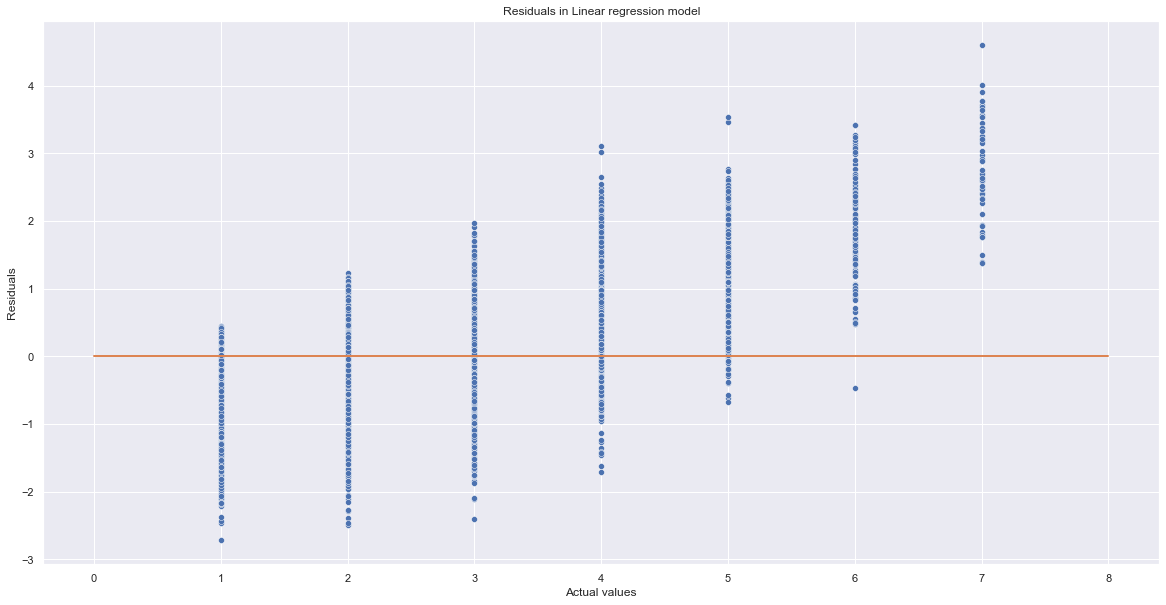

In [47]:
Preprocessor = Pipeline(
    [
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
        ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
        ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize="all")),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline)
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", RobustScaler()),
        ("model", xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 227, seed = 42, max_depth=6, learning_rate=0.13397, min_impurity_decrease=0.054034)),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    train_set, train_grade, test_size=0.2, random_state=42, stratify=train_grade
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([0, 8], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [48]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5457846786403132

In [50]:
predictions = full_pipe.predict(test_set_val)
predictions = np.round(predictions)
predictions[predictions<1] = 1
predictions[predictions>7] = 7

r2_score(test_grade_val, predictions)

0.49203088034845066

Using XGBoost we get slightly better values. Let's try tuning the hyperparameters.

In [44]:
def objective_booster(trial, X: pd.DataFrame, y: pd.Series):
    

    
    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
        
    state = trial.suggest_categorical("state", [True, False])
    binarize = trial.suggest_categorical("binarize", ["none", "some", "all"])

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.7)
    n_estimators = trial.suggest_int("n_estimators", 10, 300)
    max_depth = trial.suggest_int("max_depth", 2, 6, log=True)
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-10, 0.1
    )
    
    one_hot_columns = ["term", "verification_status", "initial_list_status", "disbursement_method", "purpose", "home_ownership", "application_type"]
    
    
    OneHotPipeline = ColumnTransformer(
        [
            ("one_hot_columns",OneHotEncoder(drop="first", handle_unknown="ignore"), one_hot_columns)
        ], remainder="passthrough"
    )

    Preprocessor = Pipeline(
        [
            ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=state)),
            ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
            ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
            ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize=binarize)),
            ("log_transform", TransformToLog(skewed_columns)),
            ("one_hot_encode", OneHotPipeline)
        ]
    )
    
    full_pipe = Pipeline(
        [
            ("preprocessor", Preprocessor),
            ("scaler", scaler),
            (
                "model", 
                 xg.XGBRegressor(
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_impurity_decrease=min_impurity_decrease,
                    tree_method='gpu_hist',
                ),
            ),
        ]
    )

    models[trial.number] = full_pipe
    score = cross_val_score(
        full_pipe,
        X,
        y,
        n_jobs=-1,
        cv=5,
        scoring="r2",
        verbose=30,
    )
    print(score)
    r2 = score.mean()
    return r2

In [46]:
models = {}
grade_wrapper = lambda trial: objective_booster(
    trial, train_set, train_grade
)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(grade_wrapper, n_trials=50)

[I 2022-10-13 17:23:44,994] A new study created in memory with name: no-name-d0ef9554-ec9c-4d6d-b1e3-032a964ad48f
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.7s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[I 2022-10-13 17:24:05,016] Trial 0 finished with value: 0.5250603812419861 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.6467983427883909, 'n_estimators': 165, 'max_depth': 3, 'min_impurity_decrease': 0.001029442247180305}. Best is trial 0 with value: 0.5250603812419861.


[0.53107821 0.52451951 0.52121762 0.52465403 0.52383253]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished
[I 2022-10-13 17:24:26,148] Trial 1 finished with value: 0.5414549247425882 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.31341778089371974, 'n_estimators': 247, 'max_depth': 3, 'min_impurity_decrease': 0.07044228061485733}. Best is trial 1 with value: 0.5414549247425882.


[0.54229093 0.53918698 0.54072214 0.54231711 0.54275746]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished
[I 2022-10-13 17:24:43,642] Trial 2 finished with value: 0.4982805184560755 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.2778234678745222, 'n_estimators': 15, 'max_depth': 6, 'min_impurity_decrease': 0.08237619846875952}. Best is trial 1 with value: 0.5414549247425882.


[0.49685835 0.49788607 0.50159677 0.49660585 0.49845554]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.5s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished
[I 2022-10-13 17:25:06,422] Trial 3 finished with value: 0.48303567403968745 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.6619475112627794, 'n_estimators': 276, 'max_depth': 4, 'min_impurity_decrease': 0.005874597338280869}. Best is trial 1 with value: 0.5414549247425882.


[0.47820115 0.49119689 0.48025075 0.48216992 0.48335966]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.4s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished
[I 2022-10-13 17:25:32,939] Trial 4 finished with value: 0.42535135747349145 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.5825500442519299, 'n_estimators': 296, 'max_depth': 5, 'min_impurity_decrease': 0.0699009158406151}. Best is trial 1 with value: 0.5414549247425882.


[0.42405587 0.41854638 0.4281702  0.43180553 0.42417881]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.9s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished
[I 2022-10-13 17:25:53,474] Trial 5 finished with value: 0.5280934591166566 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.13730512944308956, 'n_estimators': 177, 'max_depth': 3, 'min_impurity_decrease': 0.024954098572785768}. Best is trial 1 with value: 0.5414549247425882.


[0.52542694 0.52818239 0.53171138 0.52936152 0.52578506]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished
[I 2022-10-13 17:26:13,047] Trial 6 finished with value: 0.4647032565781003 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.11843529512842875, 'n_estimators': 41, 'max_depth': 3, 'min_impurity_decrease': 0.05409507962859634}. Best is trial 1 with value: 0.5414549247425882.


[0.46187688 0.46503957 0.46985154 0.46496095 0.46178734]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.3s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished
[I 2022-10-13 17:26:31,428] Trial 7 finished with value: 0.5368573401496969 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.3048192730680116, 'n_estimators': 167, 'max_depth': 3, 'min_impurity_decrease': 0.06287878492323966}. Best is trial 1 with value: 0.5414549247425882.


[0.53717298 0.53760274 0.53820731 0.53651342 0.53479025]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.8s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished
[I 2022-10-13 17:26:50,823] Trial 8 finished with value: 0.5227333689578924 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.6293311159400791, 'n_estimators': 149, 'max_depth': 2, 'min_impurity_decrease': 0.09262675974763963}. Best is trial 1 with value: 0.5414549247425882.


[0.52444128 0.52108043 0.5228875  0.52408866 0.52116897]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished
[I 2022-10-13 17:27:09,767] Trial 9 finished with value: 0.5308427342695291 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1975560958866129, 'n_estimators': 128, 'max_depth': 3, 'min_impurity_decrease': 0.08719004560253113}. Best is trial 1 with value: 0.5414549247425882.


[0.53104191 0.53110454 0.53148858 0.5322562  0.52832244]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.2s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished
[I 2022-10-13 17:27:30,625] Trial 10 finished with value: 0.5345263448534203 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.45350156417704623, 'n_estimators': 230, 'max_depth': 2, 'min_impurity_decrease': 0.03445616755774491}. Best is trial 1 with value: 0.5414549247425882.


[0.53472308 0.53288289 0.53315544 0.53781859 0.53405173]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.8s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished
[I 2022-10-13 17:27:50,919] Trial 11 finished with value: 0.5316907610182569 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.395303489603093, 'n_estimators': 231, 'max_depth': 4, 'min_impurity_decrease': 0.06046817906172694}. Best is trial 1 with value: 0.5414549247425882.


[0.53363592 0.5337389  0.52992243 0.53511398 0.52604258]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished
[I 2022-10-13 17:28:09,316] Trial 12 finished with value: 0.5366795490943209 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.2951261480111082, 'n_estimators': 102, 'max_depth': 4, 'min_impurity_decrease': 0.07152653032734176}. Best is trial 1 with value: 0.5414549247425882.


[0.5375742  0.53747319 0.53631719 0.53680778 0.53522539]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.4s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished
[I 2022-10-13 17:28:28,067] Trial 13 finished with value: 0.45120207233794263 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.02961076350624442, 'n_estimators': 220, 'max_depth': 2, 'min_impurity_decrease': 0.04833733746151257}. Best is trial 1 with value: 0.5414549247425882.


[0.44762613 0.45078909 0.45669236 0.45121894 0.44968385]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.2s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished
[I 2022-10-13 17:28:49,205] Trial 14 finished with value: 0.5190722193424516 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.4978274865429186, 'n_estimators': 196, 'max_depth': 4, 'min_impurity_decrease': 0.09927562513090135}. Best is trial 1 with value: 0.5414549247425882.


[0.52074163 0.52084913 0.5132858  0.51947768 0.52100687]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.1s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished
[I 2022-10-13 17:29:16,185] Trial 15 finished with value: 0.4990533098720258 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'some', 'learning_rate': 0.34840475076978494, 'n_estimators': 267, 'max_depth': 5, 'min_impurity_decrease': 0.04035053778713026}. Best is trial 1 with value: 0.5414549247425882.


[0.49168917 0.49608004 0.50570536 0.49997225 0.50181973]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
[I 2022-10-13 17:29:34,387] Trial 16 finished with value: 0.5259293876268922 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.23849520640389582, 'n_estimators': 91, 'max_depth': 3, 'min_impurity_decrease': 0.073369789524139}. Best is trial 1 with value: 0.5414549247425882.


[0.52475414 0.52634958 0.52744857 0.52669034 0.5244043 ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.8s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished
[I 2022-10-13 17:29:53,217] Trial 17 finished with value: 0.5319397178507307 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.4022464728988483, 'n_estimators': 200, 'max_depth': 2, 'min_impurity_decrease': 0.05982880182999847}. Best is trial 1 with value: 0.5414549247425882.


[0.53081839 0.53352038 0.53125424 0.53207332 0.53203226]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.7s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.9s finished
[I 2022-10-13 17:30:16,462] Trial 18 finished with value: 0.5222358443487934 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.3192158043773084, 'n_estimators': 257, 'max_depth': 4, 'min_impurity_decrease': 0.021957989759508474}. Best is trial 1 with value: 0.5414549247425882.


[0.52283765 0.5195012  0.523484   0.52276906 0.52258731]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.1s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.5s finished
[I 2022-10-13 17:30:36,316] Trial 19 finished with value: 0.51146690020407 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.524069312977512, 'n_estimators': 78, 'max_depth': 5, 'min_impurity_decrease': 0.07579010689116134}. Best is trial 1 with value: 0.5414549247425882.


[0.51254496 0.5083589  0.51242672 0.51590453 0.50809939]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished
[I 2022-10-13 17:30:53,988] Trial 20 finished with value: 0.5287765299659937 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.1822292408608764, 'n_estimators': 123, 'max_depth': 3, 'min_impurity_decrease': 0.06330102453284958}. Best is trial 1 with value: 0.5414549247425882.


[0.52795401 0.53040228 0.53090678 0.52701868 0.5276009 ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished
[I 2022-10-13 17:31:12,450] Trial 21 finished with value: 0.5367991299475344 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.30132774225549597, 'n_estimators': 99, 'max_depth': 4, 'min_impurity_decrease': 0.08013433008936151}. Best is trial 1 with value: 0.5414549247425882.


[0.53533643 0.53782043 0.540009   0.53664855 0.53418124]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished
[I 2022-10-13 17:31:32,762] Trial 22 finished with value: 0.5165875188911206 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.40285912684641445, 'n_estimators': 57, 'max_depth': 6, 'min_impurity_decrease': 0.08010109525064468}. Best is trial 1 with value: 0.5414549247425882.


[0.51813306 0.52026115 0.51242272 0.5148655  0.51725517]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
[I 2022-10-13 17:31:51,042] Trial 23 finished with value: 0.5406016667160406 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.2291136160324484, 'n_estimators': 130, 'max_depth': 4, 'min_impurity_decrease': 0.08964458202890822}. Best is trial 1 with value: 0.5414549247425882.


[0.53913213 0.53983134 0.54174809 0.54066708 0.54162969]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.2s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished
[I 2022-10-13 17:32:12,006] Trial 24 finished with value: 0.5425332021452757 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.23290706702233466, 'n_estimators': 141, 'max_depth': 5, 'min_impurity_decrease': 0.09925381495510884}. Best is trial 24 with value: 0.5425332021452757.


[0.5416529  0.53895751 0.53972121 0.54651319 0.54582119]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.6s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished
[I 2022-10-13 17:32:33,543] Trial 25 finished with value: 0.5211736749903073 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.05283128780558463, 'n_estimators': 133, 'max_depth': 5, 'min_impurity_decrease': 0.0993418200354743}. Best is trial 24 with value: 0.5425332021452757.


[0.52209988 0.51917839 0.52225955 0.52265969 0.51967086]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished
[I 2022-10-13 17:33:00,571] Trial 26 finished with value: 0.5155354730846862 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.2391404108807803, 'n_estimators': 195, 'max_depth': 6, 'min_impurity_decrease': 0.08927067697364793}. Best is trial 24 with value: 0.5425332021452757.


[0.51696927 0.51151601 0.51351546 0.51960142 0.51607521]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.2s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished
[I 2022-10-13 17:33:24,323] Trial 27 finished with value: 0.5433867099455785 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.11598957725580403, 'n_estimators': 149, 'max_depth': 5, 'min_impurity_decrease': 0.09301501755996368}. Best is trial 27 with value: 0.5433867099455785.


[0.54238288 0.54300735 0.54378088 0.54460045 0.543162  ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.7s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished
[I 2022-10-13 17:33:49,181] Trial 28 finished with value: 0.5454522524393809 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.10544476742709986, 'n_estimators': 185, 'max_depth': 5, 'min_impurity_decrease': 0.09621837503480271}. Best is trial 28 with value: 0.5454522524393809.


[0.54425935 0.54543655 0.5438878  0.54781656 0.54586099]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.3s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished
[I 2022-10-13 17:34:11,717] Trial 29 finished with value: 0.5375538586722599 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.08475112741413401, 'n_estimators': 148, 'max_depth': 5, 'min_impurity_decrease': 0.0948970916120505}. Best is trial 28 with value: 0.5454522524393809.


[0.53722291 0.53698257 0.53824018 0.53805375 0.53726989]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.7s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished
[I 2022-10-13 17:34:42,619] Trial 30 finished with value: 0.5474176957291659 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.14377596872386425, 'n_estimators': 178, 'max_depth': 6, 'min_impurity_decrease': 0.0849619020486925}. Best is trial 30 with value: 0.5474176957291659.


[0.54896475 0.54508978 0.54681523 0.54693306 0.54928566]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.6s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished
[I 2022-10-13 17:35:10,998] Trial 31 finished with value: 0.5480954294190923 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.15768891322974804, 'n_estimators': 183, 'max_depth': 6, 'min_impurity_decrease': 0.08599888718803746}. Best is trial 31 with value: 0.5480954294190923.


[0.55012696 0.54782995 0.54783048 0.54449889 0.55019086]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.6s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished
[I 2022-10-13 17:35:41,152] Trial 32 finished with value: 0.5471751072695606 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.1251658818906502, 'n_estimators': 179, 'max_depth': 6, 'min_impurity_decrease': 0.08439164673401932}. Best is trial 31 with value: 0.5480954294190923.


[0.54728031 0.54552704 0.54761845 0.54709797 0.54835175]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.4s finished
[I 2022-10-13 17:36:09,014] Trial 33 finished with value: 0.5467936285691387 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.16163023237065932, 'n_estimators': 176, 'max_depth': 6, 'min_impurity_decrease': 0.08483866815685669}. Best is trial 31 with value: 0.5480954294190923.


[0.54937704 0.54487014 0.54706483 0.54470889 0.54794723]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.1s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.5s finished
[I 2022-10-13 17:36:39,845] Trial 34 finished with value: -1.405617150095682 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.0014867962651676503, 'n_estimators': 207, 'max_depth': 6, 'min_impurity_decrease': 0.08382718006255103}. Best is trial 31 with value: 0.5480954294190923.


[-1.38395994 -1.39204308 -1.40765746 -1.41730562 -1.42711965]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.9s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.0s finished
[I 2022-10-13 17:37:07,185] Trial 35 finished with value: 0.5464623985676627 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.1668015800363189, 'n_estimators': 165, 'max_depth': 6, 'min_impurity_decrease': 0.07793266290363088}. Best is trial 31 with value: 0.5480954294190923.


[0.54876065 0.54433378 0.54641605 0.5470892  0.54571232]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished
[I 2022-10-13 17:37:36,528] Trial 36 finished with value: 0.5439493332338721 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.06846885635198585, 'n_estimators': 177, 'max_depth': 6, 'min_impurity_decrease': 0.08569048857595228}. Best is trial 31 with value: 0.5480954294190923.


[0.54292149 0.54228614 0.54469073 0.54623031 0.543618  ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.9s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished
[I 2022-10-13 17:38:07,477] Trial 37 finished with value: 0.532181769862429 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.1462405831078259, 'n_estimators': 214, 'max_depth': 6, 'min_impurity_decrease': 0.06916713060395209}. Best is trial 31 with value: 0.5480954294190923.


[0.53209996 0.52961475 0.53228427 0.53289336 0.5340165 ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.2s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s finished
[I 2022-10-13 17:38:39,015] Trial 38 finished with value: 0.5419492415563231 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.1920710715244055, 'n_estimators': 244, 'max_depth': 6, 'min_impurity_decrease': 0.06670543057392656}. Best is trial 31 with value: 0.5480954294190923.


[0.54432883 0.54469206 0.5387716  0.54271474 0.53923897]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.2s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.4s finished
[I 2022-10-13 17:39:06,739] Trial 39 finished with value: 0.5485934221368785 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.14218883124569023, 'n_estimators': 165, 'max_depth': 6, 'min_impurity_decrease': 0.0828829780632661}. Best is trial 39 with value: 0.5485934221368785.


[0.54809556 0.54900079 0.54724943 0.54777986 0.55084147]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.0s finished
[I 2022-10-13 17:39:34,127] Trial 40 finished with value: 0.5314918449270066 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.03818940566484792, 'n_estimators': 291, 'max_depth': 5, 'min_impurity_decrease': 0.07531563918597504}. Best is trial 39 with value: 0.5485934221368785.


[0.53035606 0.53001921 0.53371299 0.53324334 0.53012762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.6s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished
[I 2022-10-13 17:40:01,718] Trial 41 finished with value: 0.5470736285028248 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.14964370608808122, 'n_estimators': 165, 'max_depth': 6, 'min_impurity_decrease': 0.08353471842193866}. Best is trial 39 with value: 0.5485934221368785.


[0.54687871 0.54718774 0.54478023 0.54964685 0.54687461]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished
[I 2022-10-13 17:40:29,284] Trial 42 finished with value: 0.5453331980471751 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.09130517709547284, 'n_estimators': 163, 'max_depth': 6, 'min_impurity_decrease': 0.08208248864473916}. Best is trial 39 with value: 0.5485934221368785.


[0.54487078 0.54457345 0.54463014 0.54726622 0.5453254 ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished
[I 2022-10-13 17:40:53,651] Trial 43 finished with value: 0.5402793178500607 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.20695152012747042, 'n_estimators': 115, 'max_depth': 6, 'min_impurity_decrease': 0.001547406291719615}. Best is trial 39 with value: 0.5485934221368785.


[0.53940124 0.53789769 0.5376237  0.5413247  0.54514928]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished
[I 2022-10-13 17:41:19,785] Trial 44 finished with value: 0.5466588428356303 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.13410137079315396, 'n_estimators': 186, 'max_depth': 5, 'min_impurity_decrease': 0.08948191406373687}. Best is trial 39 with value: 0.5485934221368785.


[0.54639293 0.54411871 0.54674431 0.54874191 0.54729636]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.3s finished
[I 2022-10-13 17:41:48,392] Trial 45 finished with value: 0.5318404593089826 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.27615321634907375, 'n_estimators': 161, 'max_depth': 6, 'min_impurity_decrease': 0.014860295100362526}. Best is trial 39 with value: 0.5485934221368785.


[0.53395951 0.53140772 0.52971884 0.53310242 0.53101381]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.1s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished
[I 2022-10-13 17:42:19,627] Trial 46 finished with value: 0.5490109058678451 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.13397084640020857, 'n_estimators': 227, 'max_depth': 6, 'min_impurity_decrease': 0.05403435766435981}. Best is trial 46 with value: 0.5490109058678451.


[0.55195837 0.54824935 0.5462654  0.5484596  0.55012181]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   24.6s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s finished
[I 2022-10-13 17:42:54,259] Trial 47 finished with value: 0.19708437765102862 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.005697746026120387, 'n_estimators': 234, 'max_depth': 6, 'min_impurity_decrease': 0.055317422651915}. Best is trial 46 with value: 0.5490109058678451.


[0.19413499 0.2063903  0.19879751 0.19238267 0.19371643]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.4s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished
[I 2022-10-13 17:43:19,637] Trial 48 finished with value: 0.5443450536999999 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.07931880715000669, 'n_estimators': 221, 'max_depth': 5, 'min_impurity_decrease': 0.044643402821790655}. Best is trial 46 with value: 0.5490109058678451.


[0.54270922 0.54593027 0.54444348 0.54557688 0.54306542]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-13 17:43:38,733] Trial 49 finished with value: 0.47312784655449214 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.2631122326038082, 'n_estimators': 11, 'max_depth': 6, 'min_impurity_decrease': 0.02986628098932793}. Best is trial 46 with value: 0.5490109058678451.


[0.47127655 0.4743132  0.48068673 0.4703267  0.46903605]


We get an even better value - 0.5490. Let's train it on the whole dataset.

In [36]:
df = df2.copy()

In [37]:
train_set, test_set, train_grade, test_grade = train_test_split(
    df.loc[:, df.columns[df.columns != "grade"]],
    df["grade"],
    test_size=0.2,
    random_state=42,
    stratify=df["grade"],
)

In [38]:
columns_to_drop = columns_to_drop_due_multicoll(train_set)
best_corrs_means_dict, max_corr_pairs = get_best_corrs_missing_cols(train_set, months_columns, columns_to_drop)
negative_corr_careers, positive_corr_careers = get_positive_negative_careers(train_set)
train_set = train_set.drop("sub_grade", axis=1)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3312\503426307.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3312\503426307.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3312\503426307.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_words = pd.Series(name = "correlation")


C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[18:19:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




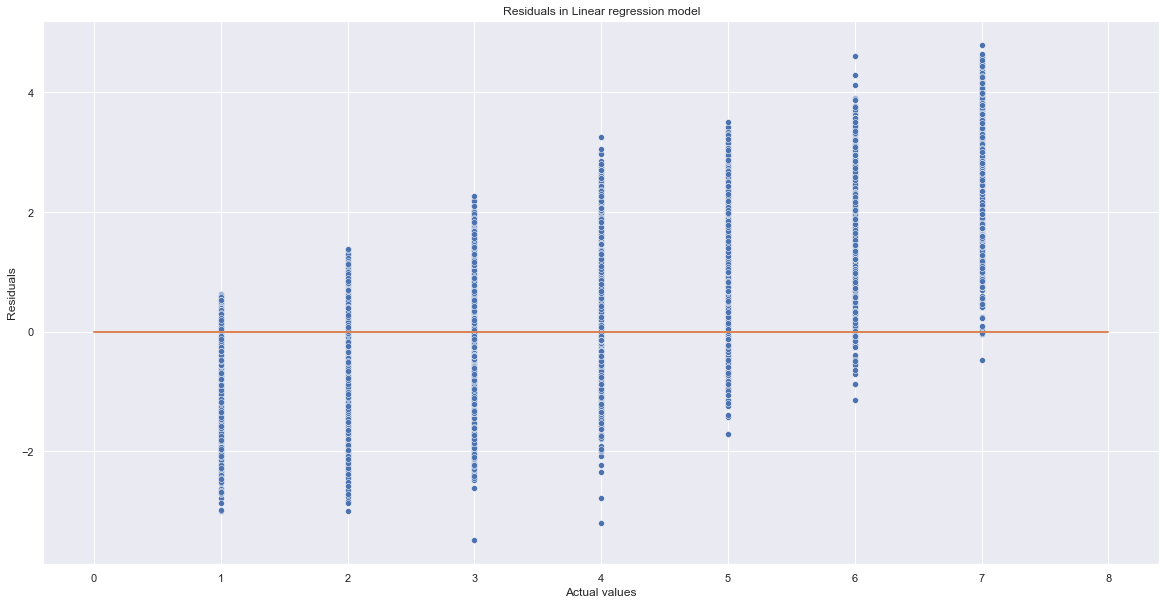

In [62]:
Preprocessor = Pipeline(
    [
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
        ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
        ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize="all")),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline)
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", RobustScaler()),
        ("model", xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 227, seed = 42, max_depth=6, learning_rate=0.13397, min_impurity_decrease=0.054034)),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    train_set, train_grade, test_size=0.2, random_state=42, stratify=train_grade
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([0, 8], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [64]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5852352578000566

In [65]:
predictions = full_pipe.predict(test_set_val)
predictions = np.round(predictions)
predictions[predictions<1] = 1
predictions[predictions>7] = 7

r2_score(test_grade_val, predictions)

0.530366948778006

After training on the whole dataset we get 4 % more on both the original r2 score and the r2 score after the predictions were rounded to ints.

In [82]:
joblib.dump(full_pipe, "grade_model_tuned.pkl")

['grade_model_tuned.pkl']

Our third task is to predict the subgrade and the interest rate for each application. Since we will be using the same data as for the second task, no additional EDA and Data cleaning is necesarry.

We'll start with the subgrade. To allow the model to concentrate on local differences, not differences between grades, we will be training a seperate model for each grade.

In [43]:
df = df2.copy()

In [44]:
train_set, test_set = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["sub_grade"],
)

In [18]:
columns_to_drop = columns_to_drop_due_multicoll(train_set)
best_corrs_means_dict, max_corr_pairs = get_best_corrs_missing_cols(train_set, months_columns, columns_to_drop)
negative_corr_careers, positive_corr_careers = get_positive_negative_careers(train_set)

desc = train_set.describe()
skewed_columns = train_set.loc[:, (train_set.dtypes=="float")].columns[train_set.loc[:, (train_set.dtypes=="float")].skew()> 1]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\3112635031.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\3112635031.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\3112635031.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_words = pd.Series(name = "correlation")


In [49]:
pd.options.mode.chained_assignment = None

To speed up the training process, we will again take samples of the data in cases where the data count is large.

In [53]:
for grade in train_set["grade"].unique():
    
    temp_df = train_set.loc[train_set["grade"]==grade]
    
    if temp_df.shape[0] > 60000:
        temp_df = temp_df.sample(60000)
    
    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
    
    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)
    
    
    models = {}
    grade_wrapper = lambda trial: objective_booster(
        trial, temp_df, temp_df_target
    )
    optuna_booster = optuna.create_study(direction="maximize")
    optuna_booster.optimize(grade_wrapper, n_trials=50)
    joblib.dump(optuna_booster, f"optuna_{grade}_sub_grades.pkl")
    best_model = models[optuna_booster.best_trial.number]
    joblib.dump(best_model, f"best_optuna_{grade}_sub_grades.pkl")

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\3040326065.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
[I 2022-10-14 15:38:33,064] A new study created in memory with name: no-name-47d15499-a2c9-44bf-b0be-48cbdaecb6f3
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   24.8s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.4s finished
[I 2022-10-14 15:39:13,817] Trial 0 finished with value: -0.09465321417586794 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.5200695625250863, 'n_estimators': 2

0   -0.093990
1   -0.095427
2   -0.110729
3   -0.077836
4   -0.095284
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   38.2s remaining:   25.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.6s finished
[I 2022-10-14 15:40:04,777] Trial 1 finished with value: 0.023651978906978476 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.25233704437226434, 'n_estimators': 130, 'max_depth': 6, 'min_impurity_decrease': 0.012321796602626407}. Best is trial 1 with value: 0.023651978906978476.


0    0.030692
1    0.019809
2    0.020355
3    0.031142
4    0.016260
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   28.8s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished
[I 2022-10-14 15:40:43,968] Trial 2 finished with value: 0.022930081150065895 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.46575398377794985, 'n_estimators': 87, 'max_depth': 4, 'min_impurity_decrease': 0.024842290104847165}. Best is trial 1 with value: 0.023651978906978476.


0    0.026643
1    0.023445
2    0.024947
3    0.025876
4    0.013739
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   36.3s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.7s finished
[I 2022-10-14 15:41:38,988] Trial 3 finished with value: -0.025794965912347444 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.5077473885420694, 'n_estimators': 298, 'max_depth': 4, 'min_impurity_decrease': 0.06579015266284344}. Best is trial 1 with value: 0.023651978906978476.


0   -0.015794
1   -0.030903
2   -0.026988
3   -0.017365
4   -0.037925
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   35.5s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.3s finished
[I 2022-10-14 15:42:30,606] Trial 4 finished with value: 0.046086168155990245 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.49095114969703435, 'n_estimators': 145, 'max_depth': 2, 'min_impurity_decrease': 0.011677279012655101}. Best is trial 4 with value: 0.046086168155990245.


0    0.053572
1    0.048397
2    0.041207
3    0.049361
4    0.037894
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   31.5s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.6s finished
[I 2022-10-14 15:43:15,537] Trial 5 finished with value: -0.1370714236452756 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.5851486303807014, 'n_estimators': 142, 'max_depth': 6, 'min_impurity_decrease': 0.07095111952012848}. Best is trial 4 with value: 0.046086168155990245.


0   -0.121011
1   -0.130287
2   -0.148090
3   -0.138789
4   -0.147180
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.8s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished
[I 2022-10-14 15:43:40,444] Trial 6 finished with value: 0.05757802905910188 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.1481484347737815, 'n_estimators': 107, 'max_depth': 4, 'min_impurity_decrease': 0.08746754950587576}. Best is trial 6 with value: 0.05757802905910188.


0    0.064068
1    0.056108
2    0.056515
3    0.060640
4    0.050559
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.7s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s finished
[I 2022-10-14 15:44:06,057] Trial 7 finished with value: 0.03983448448611713 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.016490428713735204, 'n_estimators': 212, 'max_depth': 4, 'min_impurity_decrease': 0.0519138402070003}. Best is trial 6 with value: 0.05757802905910188.


0    0.043493
1    0.040199
2    0.037923
3    0.041210
4    0.036348
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.7s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished
[I 2022-10-14 15:44:29,167] Trial 8 finished with value: 0.04887073492776213 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.3830346740199055, 'n_estimators': 96, 'max_depth': 2, 'min_impurity_decrease': 0.04920767305566992}. Best is trial 6 with value: 0.05757802905910188.


0    0.053947
1    0.049435
2    0.044316
3    0.051784
4    0.044871
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.7s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished
[I 2022-10-14 15:44:52,351] Trial 9 finished with value: -0.07235321035154314 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.6809926809848161, 'n_estimators': 45, 'max_depth': 6, 'min_impurity_decrease': 0.062901772419463}. Best is trial 6 with value: 0.05757802905910188.


0   -0.071044
1   -0.077915
2   -0.067942
3   -0.064985
4   -0.079881
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.3s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished
[I 2022-10-14 15:45:11,302] Trial 10 finished with value: -0.06843432625120024 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.1565833711347828, 'n_estimators': 10, 'max_depth': 3, 'min_impurity_decrease': 0.09876588574987963}. Best is trial 6 with value: 0.05757802905910188.


0   -0.065158
1   -0.063983
2   -0.069621
3   -0.073546
4   -0.069864
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.8s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished
[I 2022-10-14 15:45:33,537] Trial 11 finished with value: 0.047458082530803435 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.31196624803651374, 'n_estimators': 74, 'max_depth': 2, 'min_impurity_decrease': 0.09805299273838113}. Best is trial 6 with value: 0.05757802905910188.


0    0.051984
1    0.047932
2    0.043704
3    0.051223
4    0.042448
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.8s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished
[I 2022-10-14 15:45:56,693] Trial 12 finished with value: 0.05288130273299958 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.14144642999478274, 'n_estimators': 102, 'max_depth': 3, 'min_impurity_decrease': 0.03424558370996332}. Best is trial 6 with value: 0.05757802905910188.


0    0.055498
1    0.052284
2    0.051984
3    0.055858
4    0.048782
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.4s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.1s finished
[I 2022-10-14 15:46:23,119] Trial 13 finished with value: 0.054477403150641736 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.08456372831582395, 'n_estimators': 191, 'max_depth': 3, 'min_impurity_decrease': 0.03169439736617803}. Best is trial 6 with value: 0.05757802905910188.


0    0.057275
1    0.053074
2    0.053790
3    0.058585
4    0.049662
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.5s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished
[I 2022-10-14 15:46:47,585] Trial 14 finished with value: -2.3810657468617156 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.0004386462567088911, 'n_estimators': 205, 'max_depth': 3, 'min_impurity_decrease': 0.08068246164185923}. Best is trial 6 with value: 0.05757802905910188.


0   -2.391336
1   -2.356676
2   -2.385168
3   -2.412403
4   -2.359746
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished
[I 2022-10-14 15:47:14,658] Trial 15 finished with value: 0.05697848216576249 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.1357772470525179, 'n_estimators': 240, 'max_depth': 4, 'min_impurity_decrease': 0.03267590650937871}. Best is trial 6 with value: 0.05757802905910188.


0    0.062956
1    0.054916
2    0.054765
3    0.062362
4    0.049894
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   24.5s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.2s finished
[I 2022-10-14 15:47:48,233] Trial 16 finished with value: 0.032525495033921256 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.21458377381356963, 'n_estimators': 260, 'max_depth': 5, 'min_impurity_decrease': 0.08412189742911218}. Best is trial 6 with value: 0.05757802905910188.


0    0.039451
1    0.030140
2    0.029701
3    0.041229
4    0.022107
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished
[I 2022-10-14 15:48:13,739] Trial 17 finished with value: 0.024358779395216423 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.3461386616450931, 'n_estimators': 252, 'max_depth': 4, 'min_impurity_decrease': 0.0006135758802510993}. Best is trial 6 with value: 0.05757802905910188.


0    0.033020
1    0.019528
2    0.026267
3    0.027157
4    0.015822
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.4s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.8s finished
[I 2022-10-14 15:48:41,895] Trial 18 finished with value: 0.058261940596310804 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.09932807863805775, 'n_estimators': 174, 'max_depth': 5, 'min_impurity_decrease': 0.04276238173871383}. Best is trial 18 with value: 0.058261940596310804.


0    0.064350
1    0.056892
2    0.056811
3    0.062385
4    0.050872
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.6s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished
[I 2022-10-14 15:49:13,657] Trial 19 finished with value: 0.0404578381466957 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.22058732613296067, 'n_estimators': 166, 'max_depth': 5, 'min_impurity_decrease': 0.07940191596546677}. Best is trial 18 with value: 0.058261940596310804.


0    0.044528
1    0.036569
2    0.044204
3    0.045549
4    0.031438
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished
[I 2022-10-14 15:49:40,708] Trial 20 finished with value: 0.03661912199527737 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.2838431854702559, 'n_estimators': 114, 'max_depth': 5, 'min_impurity_decrease': 0.04555967421235977}. Best is trial 18 with value: 0.058261940596310804.


0    0.045481
1    0.038320
2    0.033496
3    0.037435
4    0.028364
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.4s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.1s finished
[I 2022-10-14 15:50:07,120] Trial 21 finished with value: 0.058243754854547844 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.09064065032953736, 'n_estimators': 173, 'max_depth': 4, 'min_impurity_decrease': 0.041399969285271024}. Best is trial 18 with value: 0.058261940596310804.


0    0.063221
1    0.058162
2    0.055053
3    0.062750
4    0.052033
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.6s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s finished
[I 2022-10-14 15:50:35,546] Trial 22 finished with value: 0.058462819035600536 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.07151791030355271, 'n_estimators': 183, 'max_depth': 5, 'min_impurity_decrease': 0.04157494902204087}. Best is trial 22 with value: 0.058462819035600536.


0    0.061649
1    0.057556
2    0.056431
3    0.063936
4    0.052742
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s finished
[I 2022-10-14 15:51:04,051] Trial 23 finished with value: 0.05899463191439478 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.07281519004244735, 'n_estimators': 172, 'max_depth': 5, 'min_impurity_decrease': 0.0418244191366603}. Best is trial 23 with value: 0.05899463191439478.


0    0.064344
1    0.056985
2    0.058260
3    0.064034
4    0.051351
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.2s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s finished
[I 2022-10-14 15:51:31,956] Trial 24 finished with value: 0.05915316143138984 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.07020090903826379, 'n_estimators': 172, 'max_depth': 5, 'min_impurity_decrease': 0.021315830841372303}. Best is trial 24 with value: 0.05915316143138984.


0    0.063788
1    0.057924
2    0.058213
3    0.063619
4    0.052222
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   27.6s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s finished
[I 2022-10-14 15:52:08,785] Trial 25 finished with value: 0.059160483510382146 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.04100337365807802, 'n_estimators': 230, 'max_depth': 6, 'min_impurity_decrease': 0.026239114779212123}. Best is trial 25 with value: 0.059160483510382146.


0    0.063007
1    0.057767
2    0.057684
3    0.064149
4    0.053195
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   27.0s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.5s finished
[I 2022-10-14 15:52:46,633] Trial 26 finished with value: 0.05878969524489328 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.03726624911803405, 'n_estimators': 229, 'max_depth': 6, 'min_impurity_decrease': 0.02064124069626378}. Best is trial 25 with value: 0.059160483510382146.


0    0.061912
1    0.058297
2    0.058490
3    0.062200
4    0.053050
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   32.1s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.7s finished
[I 2022-10-14 15:53:28,686] Trial 27 finished with value: 0.017907027989575264 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.1990947127886837, 'n_estimators': 266, 'max_depth': 6, 'min_impurity_decrease': 0.018411168589104788}. Best is trial 25 with value: 0.059160483510382146.


0    0.023402
1    0.016096
2    0.016490
3    0.023145
4    0.010401
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.5s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished
[I 2022-10-14 15:53:55,608] Trial 28 finished with value: 0.05810512241170056 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.041568385234240994, 'n_estimators': 223, 'max_depth': 5, 'min_impurity_decrease': 0.007958758798873446}. Best is trial 25 with value: 0.059160483510382146.


0    0.062640
1    0.056599
2    0.056015
3    0.061694
4    0.053578
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   29.8s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.5s finished
[I 2022-10-14 15:54:37,474] Trial 29 finished with value: -0.1346178365304108 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.4363111709236004, 'n_estimators': 283, 'max_depth': 6, 'min_impurity_decrease': 0.024840749727368307}. Best is trial 25 with value: 0.059160483510382146.


0   -0.132075
1   -0.131914
2   -0.133873
3   -0.117223
4   -0.158005
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished
[I 2022-10-14 15:55:06,873] Trial 30 finished with value: 0.046980603660915075 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.17935770925643535, 'n_estimators': 196, 'max_depth': 5, 'min_impurity_decrease': 0.060030433350286364}. Best is trial 25 with value: 0.059160483510382146.


0    0.053412
1    0.046538
2    0.040636
3    0.053643
4    0.040674
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   27.5s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s finished
[I 2022-10-14 15:55:43,770] Trial 31 finished with value: 0.058193201654168566 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.034326183082923574, 'n_estimators': 227, 'max_depth': 6, 'min_impurity_decrease': 0.025672495155394236}. Best is trial 25 with value: 0.059160483510382146.


0    0.060582
1    0.057228
2    0.056100
3    0.063713
4    0.053343
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.3s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished
[I 2022-10-14 15:56:15,645] Trial 32 finished with value: 0.05409372717954823 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.11133225942820638, 'n_estimators': 154, 'max_depth': 6, 'min_impurity_decrease': 0.016972542194239718}. Best is trial 25 with value: 0.059160483510382146.


0    0.058616
1    0.051693
2    0.055192
3    0.059636
4    0.045330
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   27.4s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.3s finished
[I 2022-10-14 15:56:52,278] Trial 33 finished with value: 0.05831754586250417 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.054627891546607646, 'n_estimators': 241, 'max_depth': 6, 'min_impurity_decrease': 0.0205428428536495}. Best is trial 25 with value: 0.059160483510382146.


0    0.064023
1    0.057169
2    0.056652
3    0.062872
4    0.050872
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   29.1s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.1s finished
[I 2022-10-14 15:57:31,692] Trial 34 finished with value: 0.00610340406722476 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.24406232741362854, 'n_estimators': 216, 'max_depth': 6, 'min_impurity_decrease': 0.006637384403099357}. Best is trial 25 with value: 0.059160483510382146.


0    0.013671
1    0.006042
2    0.006456
3    0.013483
4   -0.009135
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.7s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s finished
[I 2022-10-14 15:57:57,393] Trial 35 finished with value: -0.07483826037060788 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.01314146183261945, 'n_estimators': 123, 'max_depth': 5, 'min_impurity_decrease': 0.03664661509408405}. Best is trial 25 with value: 0.059160483510382146.


0   -0.070773
1   -0.068395
2   -0.078101
3   -0.080161
4   -0.076761
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.1s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.3s finished
[I 2022-10-14 15:58:27,077] Trial 36 finished with value: 0.049260849279159455 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.0625346302422374, 'n_estimators': 234, 'max_depth': 5, 'min_impurity_decrease': 0.027623757709665936}. Best is trial 25 with value: 0.059160483510382146.


0    0.055366
1    0.050284
2    0.046325
3    0.052725
4    0.041605
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.3s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished
[I 2022-10-14 15:58:56,442] Trial 37 finished with value: 0.05388328034949279 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.10939316878771149, 'n_estimators': 138, 'max_depth': 6, 'min_impurity_decrease': 0.014694702231724983}. Best is trial 25 with value: 0.059160483510382146.


0    0.054854
1    0.053011
2    0.052653
3    0.061293
4    0.047605
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.7s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.9s finished
[I 2022-10-14 15:59:24,714] Trial 38 finished with value: 0.05125490173815852 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.1796104634492373, 'n_estimators': 293, 'max_depth': 4, 'min_impurity_decrease': 0.054715427894322044}. Best is trial 25 with value: 0.059160483510382146.


0    0.055767
1    0.048140
2    0.053360
3    0.055148
4    0.043860
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.7s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished
[I 2022-10-14 15:59:51,228] Trial 39 finished with value: -0.5977199456975784 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.0049090122279600995, 'n_estimators': 155, 'max_depth': 5, 'min_impurity_decrease': 0.02270337630350593}. Best is trial 25 with value: 0.059160483510382146.


0   -0.596375
1   -0.583826
2   -0.602029
3   -0.612998
4   -0.593371
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   29.6s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished
[I 2022-10-14 16:00:30,019] Trial 40 finished with value: -0.23230957817025835 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.6169620331724255, 'n_estimators': 270, 'max_depth': 6, 'min_impurity_decrease': 0.010417365427937506}. Best is trial 25 with value: 0.059160483510382146.


0   -0.222142
1   -0.249254
2   -0.236787
3   -0.222887
4   -0.230477
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.5s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.4s finished
[I 2022-10-14 16:00:55,780] Trial 41 finished with value: 0.05854691159346008 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.06447945124310994, 'n_estimators': 185, 'max_depth': 5, 'min_impurity_decrease': 0.03864149344911476}. Best is trial 25 with value: 0.059160483510382146.


0    0.065097
1    0.057630
2    0.055955
3    0.062697
4    0.051355
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.8s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.1s finished
[I 2022-10-14 16:01:19,247] Trial 42 finished with value: 0.058556615685503764 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.04936730337735935, 'n_estimators': 201, 'max_depth': 5, 'min_impurity_decrease': 0.029500895339074747}. Best is trial 25 with value: 0.059160483510382146.


0    0.062507
1    0.058268
2    0.056858
3    0.062540
4    0.052611
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.0s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished
[I 2022-10-14 16:01:46,696] Trial 43 finished with value: 0.04737562678675209 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.1256619834852191, 'n_estimators': 209, 'max_depth': 6, 'min_impurity_decrease': 0.030536041944188044}. Best is trial 25 with value: 0.059160483510382146.


0    0.054564
1    0.043341
2    0.047595
3    0.053948
4    0.037430
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.9s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished
[I 2022-10-14 16:02:07,365] Trial 44 finished with value: 0.0518034873952268 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.03564856156976043, 'n_estimators': 194, 'max_depth': 4, 'min_impurity_decrease': 0.029367222619993222}. Best is trial 25 with value: 0.059160483510382146.


0    0.054823
1    0.051020
2    0.050803
3    0.055307
4    0.047064
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished
[I 2022-10-14 16:02:31,957] Trial 45 finished with value: 0.04099198333524825 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.16343298752808977, 'n_estimators': 164, 'max_depth': 6, 'min_impurity_decrease': 0.04859539637579558}. Best is trial 25 with value: 0.059160483510382146.


0    0.047315
1    0.040231
2    0.039527
3    0.045514
4    0.032373
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.1s finished
[I 2022-10-14 16:02:55,397] Trial 46 finished with value: 0.04772037366463513 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.08826810793190834, 'n_estimators': 202, 'max_depth': 5, 'min_impurity_decrease': 0.021744034212410633}. Best is trial 25 with value: 0.059160483510382146.


0    0.051298
1    0.048792
2    0.043350
3    0.052317
4    0.042844
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.0s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished
[I 2022-10-14 16:03:26,519] Trial 47 finished with value: 0.059181363342189375 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.03664191191313193, 'n_estimators': 248, 'max_depth': 6, 'min_impurity_decrease': 0.037014944703599055}. Best is trial 47 with value: 0.059181363342189375.


0    0.062273
1    0.059268
2    0.057864
3    0.063160
4    0.053341
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.9s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s finished
[I 2022-10-14 16:03:56,308] Trial 48 finished with value: 0.04063758109952533 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.13200967482080503, 'n_estimators': 250, 'max_depth': 6, 'min_impurity_decrease': 0.03731565968879025}. Best is trial 47 with value: 0.059181363342189375.


0    0.044535
1    0.041292
2    0.040375
3    0.049665
4    0.027321
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.3s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished
[I 2022-10-14 16:04:28,361] Trial 49 finished with value: -0.17955496109229935 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.5377220937518052, 'n_estimators': 279, 'max_depth': 6, 'min_impurity_decrease': 0.05709056747911036}. Best is trial 47 with value: 0.059181363342189375.


0   -0.187093
1   -0.179165
2   -0.179186
3   -0.174384
4   -0.177946
dtype: float64


C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\3040326065.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
[I 2022-10-14 16:04:30,744] A new study created in memory with name: no-name-cac2a6ab-27e4-4839-b9d8-93a2a77ee871
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
[I 2022-10-14 16:04:48,952] Trial 0 finished with value: 0.10330987218172667 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.39400692943956117, 'n_estimators': 16

0    0.100948
1    0.106084
2    0.104518
3    0.101368
4    0.103633
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished
[I 2022-10-14 16:05:06,726] Trial 1 finished with value: 0.06496066794424604 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.05897593935127171, 'n_estimators': 81, 'max_depth': 2, 'min_impurity_decrease': 0.03290869749136851}. Best is trial 0 with value: 0.10330987218172667.


0    0.061802
1    0.068101
2    0.065880
3    0.063928
4    0.065092
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished
[I 2022-10-14 16:05:23,718] Trial 2 finished with value: 0.10262017616031652 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.44890597962791545, 'n_estimators': 97, 'max_depth': 3, 'min_impurity_decrease': 0.015026258152403686}. Best is trial 0 with value: 0.10330987218172667.


0    0.101959
1    0.102960
2    0.105015
3    0.103733
4    0.099434
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished
[I 2022-10-14 16:05:41,371] Trial 3 finished with value: 0.0880474564415096 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.5138598025203314, 'n_estimators': 45, 'max_depth': 4, 'min_impurity_decrease': 0.028520724097639165}. Best is trial 0 with value: 0.10330987218172667.


0    0.085986
1    0.085359
2    0.093066
3    0.090071
4    0.085755
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:06:00,450] Trial 4 finished with value: 0.09395320597936223 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.4528999720142695, 'n_estimators': 222, 'max_depth': 3, 'min_impurity_decrease': 0.01512569087588779}. Best is trial 0 with value: 0.10330987218172667.


0    0.089305
1    0.093831
2    0.095728
3    0.094585
4    0.096317
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[I 2022-10-14 16:06:20,244] Trial 5 finished with value: 0.0753477973796444 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.012565283482382495, 'n_estimators': 264, 'max_depth': 4, 'min_impurity_decrease': 0.02063904893638528}. Best is trial 0 with value: 0.10330987218172667.


0    0.070838
1    0.080622
2    0.076178
3    0.074419
4    0.074681
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished
[I 2022-10-14 16:06:36,806] Trial 6 finished with value: 0.09017663838791909 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.30425067979349724, 'n_estimators': 48, 'max_depth': 2, 'min_impurity_decrease': 0.09683165119024555}. Best is trial 0 with value: 0.10330987218172667.


0    0.088160
1    0.092856
2    0.091294
3    0.090758
4    0.087815
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
[I 2022-10-14 16:06:54,965] Trial 7 finished with value: 0.07187517662585137 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.031459482679303014, 'n_estimators': 205, 'max_depth': 2, 'min_impurity_decrease': 0.021847863280760115}. Best is trial 0 with value: 0.10330987218172667.


0    0.068174
1    0.074929
2    0.073129
3    0.071268
4    0.071876
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished
[I 2022-10-14 16:07:17,299] Trial 8 finished with value: 0.09645252112343705 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.29064070417479454, 'n_estimators': 235, 'max_depth': 4, 'min_impurity_decrease': 0.06286454409178568}. Best is trial 0 with value: 0.10330987218172667.


0    0.092964
1    0.102213
2    0.096305
3    0.096673
4    0.094109
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.5s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished
[I 2022-10-14 16:07:39,396] Trial 9 finished with value: 0.0836064200627143 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.3089190805171802, 'n_estimators': 166, 'max_depth': 5, 'min_impurity_decrease': 0.05048875283967733}. Best is trial 0 with value: 0.10330987218172667.


0    0.084149
1    0.085400
2    0.089991
3    0.082267
4    0.076225
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.9s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished
[I 2022-10-14 16:08:02,202] Trial 10 finished with value: -0.0930911161736128 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.6491606704925843, 'n_estimators': 137, 'max_depth': 6, 'min_impurity_decrease': 0.09015038587588053}. Best is trial 0 with value: 0.10330987218172667.


0   -0.093386
1   -0.098130
2   -0.101860
3   -0.077595
4   -0.094484
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished
[I 2022-10-14 16:08:19,211] Trial 11 finished with value: 0.10066266415463845 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.43861012851229036, 'n_estimators': 114, 'max_depth': 3, 'min_impurity_decrease': 0.0727815565622698}. Best is trial 0 with value: 0.10330987218172667.


0    0.097961
1    0.104504
2    0.100821
3    0.101804
4    0.098224
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished
[I 2022-10-14 16:08:36,593] Trial 12 finished with value: 0.11060097280876398 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.17560349004056733, 'n_estimators': 167, 'max_depth': 3, 'min_impurity_decrease': 0.07733129064335785}. Best is trial 12 with value: 0.11060097280876398.


0    0.108527
1    0.112245
2    0.112099
3    0.109931
4    0.110203
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished
[I 2022-10-14 16:08:53,576] Trial 13 finished with value: 0.11084580059505167 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.15470619770718985, 'n_estimators': 174, 'max_depth': 3, 'min_impurity_decrease': 0.0838165729813189}. Best is trial 13 with value: 0.11084580059505167.


0    0.108300
1    0.113334
2    0.111161
3    0.112663
4    0.108771
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished
[I 2022-10-14 16:09:11,526] Trial 14 finished with value: 0.11321190871927544 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.16458053513804125, 'n_estimators': 179, 'max_depth': 4, 'min_impurity_decrease': 0.07332501038007043}. Best is trial 14 with value: 0.11321190871927544.


0    0.111381
1    0.114593
2    0.113054
3    0.115144
4    0.111887
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.5s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished
[I 2022-10-14 16:09:35,680] Trial 15 finished with value: 0.10450533389732033 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.16526692841082288, 'n_estimators': 287, 'max_depth': 5, 'min_impurity_decrease': 0.06057488299359291}. Best is trial 14 with value: 0.11321190871927544.


0    0.105801
1    0.103467
2    0.105229
3    0.107770
4    0.100259
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:09:54,760] Trial 16 finished with value: 0.11235874080302868 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.17912739429919167, 'n_estimators': 195, 'max_depth': 4, 'min_impurity_decrease': 0.042118460690446655}. Best is trial 14 with value: 0.11321190871927544.


0    0.112416
1    0.114232
2    0.113697
3    0.111042
4    0.110406
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.3s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished
[I 2022-10-14 16:10:17,693] Trial 17 finished with value: 0.09993549423101947 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.20903524480122598, 'n_estimators': 196, 'max_depth': 5, 'min_impurity_decrease': 0.041068512513533655}. Best is trial 14 with value: 0.11321190871927544.


0    0.099312
1    0.104083
2    0.099561
3    0.098531
4    0.098191
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.9s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished
[I 2022-10-14 16:10:38,465] Trial 18 finished with value: 0.10581581764385006 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.09889661205171815, 'n_estimators': 258, 'max_depth': 4, 'min_impurity_decrease': 0.0533872571776896}. Best is trial 14 with value: 0.11321190871927544.


0    0.102036
1    0.107375
2    0.107009
3    0.107737
4    0.104922
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.4s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished
[I 2022-10-14 16:10:53,472] Trial 19 finished with value: 0.0881554179968386 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.24621369522296893, 'n_estimators': 13, 'max_depth': 6, 'min_impurity_decrease': 0.0029860499829065384}. Best is trial 14 with value: 0.11321190871927544.


0    0.083818
1    0.093714
2    0.088030
3    0.087622
4    0.087593
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.3s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:11:12,537] Trial 20 finished with value: 0.11386499674495523 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.09544802737407021, 'n_estimators': 133, 'max_depth': 5, 'min_impurity_decrease': 0.040552860790799686}. Best is trial 20 with value: 0.11386499674495523.


0    0.112021
1    0.116212
2    0.115856
3    0.112790
4    0.112447
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished
[I 2022-10-14 16:11:31,425] Trial 21 finished with value: 0.11422040958507262 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.12269745881095867, 'n_estimators': 137, 'max_depth': 5, 'min_impurity_decrease': 0.04179427776039555}. Best is trial 21 with value: 0.11422040958507262.


0    0.112924
1    0.116418
2    0.114191
3    0.115053
4    0.112515
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished
[I 2022-10-14 16:11:50,620] Trial 22 finished with value: 0.11339494368242971 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.0966026001088764, 'n_estimators': 135, 'max_depth': 5, 'min_impurity_decrease': 0.06528371586408864}. Best is trial 21 with value: 0.11422040958507262.


0    0.111258
1    0.116564
2    0.116125
3    0.111577
4    0.111452
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:12:09,640] Trial 23 finished with value: 0.11348465409787936 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.10095072634118431, 'n_estimators': 138, 'max_depth': 5, 'min_impurity_decrease': 0.04161992372165009}. Best is trial 21 with value: 0.11422040958507262.


0    0.112622
1    0.115197
2    0.115074
3    0.113373
4    0.111158
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.2s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished
[I 2022-10-14 16:12:31,693] Trial 24 finished with value: 0.11265403612398901 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.09107429596171085, 'n_estimators': 136, 'max_depth': 6, 'min_impurity_decrease': 0.03905365739364115}. Best is trial 21 with value: 0.11422040958507262.


0    0.110474
1    0.113276
2    0.113820
3    0.115626
4    0.110074
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished
[I 2022-10-14 16:12:51,181] Trial 25 finished with value: 0.1014112845338816 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.25134867508993225, 'n_estimators': 113, 'max_depth': 5, 'min_impurity_decrease': 0.0473976259396742}. Best is trial 21 with value: 0.11422040958507262.


0    0.101238
1    0.103147
2    0.100822
3    0.103325
4    0.098523
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished
[I 2022-10-14 16:13:09,279] Trial 26 finished with value: 0.10097036176413313 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.1132891328280805, 'n_estimators': 71, 'max_depth': 6, 'min_impurity_decrease': 0.0341936471331615}. Best is trial 21 with value: 0.11422040958507262.


0    0.097752
1    0.103156
2    0.102246
3    0.100554
4    0.101145
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished
[I 2022-10-14 16:13:28,947] Trial 27 finished with value: 0.07566228767217772 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.020578262271882086, 'n_estimators': 141, 'max_depth': 5, 'min_impurity_decrease': 0.05620206028300859}. Best is trial 21 with value: 0.11422040958507262.


0    0.073394
1    0.081904
2    0.075059
3    0.073614
4    0.074339
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[I 2022-10-14 16:13:48,939] Trial 28 finished with value: -0.039510995294804195 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.5910872731901118, 'n_estimators': 112, 'max_depth': 6, 'min_impurity_decrease': 0.04514114215029597}. Best is trial 21 with value: 0.11422040958507262.


0   -0.047207
1   -0.037503
2   -0.030211
3   -0.042343
4   -0.040290
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.7s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished
[I 2022-10-14 16:14:09,434] Trial 29 finished with value: 0.07133660643041584 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.37041751529791317, 'n_estimators': 153, 'max_depth': 5, 'min_impurity_decrease': 0.02727893681376537}. Best is trial 21 with value: 0.11422040958507262.


0    0.066142
1    0.074830
2    0.069601
3    0.075400
4    0.070710
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished
[I 2022-10-14 16:14:25,810] Trial 30 finished with value: 0.10984451592713043 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.22031975361401646, 'n_estimators': 89, 'max_depth': 4, 'min_impurity_decrease': 0.0031053303739947136}. Best is trial 21 with value: 0.11422040958507262.


0    0.107666
1    0.115685
2    0.109128
3    0.110038
4    0.106706
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished
[I 2022-10-14 16:14:44,129] Trial 31 finished with value: 0.11303987086763785 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.11491049036907254, 'n_estimators': 125, 'max_depth': 5, 'min_impurity_decrease': 0.06388322174913487}. Best is trial 21 with value: 0.11422040958507262.


0    0.110651
1    0.116612
2    0.114188
3    0.112372
4    0.111377
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished
[I 2022-10-14 16:15:03,279] Trial 32 finished with value: 0.11153091857933062 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.06614008400022174, 'n_estimators': 156, 'max_depth': 5, 'min_impurity_decrease': 0.06709522889120058}. Best is trial 21 with value: 0.11422040958507262.


0    0.109248
1    0.112368
2    0.112020
3    0.113038
4    0.110981
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.6s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished
[I 2022-10-14 16:15:23,736] Trial 33 finished with value: 0.10893690750854967 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.06855790062149154, 'n_estimators': 99, 'max_depth': 6, 'min_impurity_decrease': 0.05371957452322618}. Best is trial 21 with value: 0.11422040958507262.


0    0.107218
1    0.110839
2    0.108551
3    0.108520
4    0.109558
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.3s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished
[I 2022-10-14 16:15:42,491] Trial 34 finished with value: 0.1031028810382153 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.1336894906331146, 'n_estimators': 148, 'max_depth': 5, 'min_impurity_decrease': 0.03432076049565079}. Best is trial 21 with value: 0.11422040958507262.


0    0.098559
1    0.105528
2    0.105109
3    0.105512
4    0.100807
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished
[I 2022-10-14 16:16:01,451] Trial 35 finished with value: 0.10110570885878194 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.05698090127792105, 'n_estimators': 76, 'max_depth': 6, 'min_impurity_decrease': 0.03655024701947785}. Best is trial 21 with value: 0.11422040958507262.


0    0.098141
1    0.104709
2    0.101283
3    0.099739
4    0.101656
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished
[I 2022-10-14 16:16:18,329] Trial 36 finished with value: -0.22322783844869595 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.009835342398268915, 'n_estimators': 124, 'max_depth': 4, 'min_impurity_decrease': 0.028375237529418333}. Best is trial 21 with value: 0.11422040958507262.


0   -0.220795
1   -0.204852
2   -0.228546
3   -0.230349
4   -0.231597
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
[I 2022-10-14 16:16:36,634] Trial 37 finished with value: 0.09978943521761566 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.12630020182248525, 'n_estimators': 59, 'max_depth': 5, 'min_impurity_decrease': 0.04647853808917997}. Best is trial 21 with value: 0.11422040958507262.


0    0.096040
1    0.101889
2    0.100433
3    0.100087
4    0.100498
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished
[I 2022-10-14 16:16:54,502] Trial 38 finished with value: 0.1098025401587734 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.21385680436350085, 'n_estimators': 98, 'max_depth': 4, 'min_impurity_decrease': 0.024094752377403803}. Best is trial 21 with value: 0.11422040958507262.


0    0.106075
1    0.114032
2    0.111300
3    0.110166
4    0.107439
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.6s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished
[I 2022-10-14 16:17:19,553] Trial 39 finished with value: 0.11336909054157325 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.05590028422649633, 'n_estimators': 186, 'max_depth': 6, 'min_impurity_decrease': 0.014180786473983159}. Best is trial 21 with value: 0.11422040958507262.


0    0.111972
1    0.116111
2    0.112971
3    0.113837
4    0.111955
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.0s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
[I 2022-10-14 16:17:37,721] Trial 40 finished with value: 0.10385855713651045 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.2801391724758124, 'n_estimators': 223, 'max_depth': 2, 'min_impurity_decrease': 0.055443251753291914}. Best is trial 21 with value: 0.11422040958507262.


0    0.100956
1    0.104436
2    0.106692
3    0.104772
4    0.102436
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.0s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished
[I 2022-10-14 16:18:02,507] Trial 41 finished with value: 0.11350807848908218 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.05186272829206844, 'n_estimators': 181, 'max_depth': 6, 'min_impurity_decrease': 0.01404701086173675}. Best is trial 21 with value: 0.11422040958507262.


0    0.110053
1    0.115265
2    0.114761
3    0.115127
4    0.112334
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished
[I 2022-10-14 16:18:21,063] Trial 42 finished with value: 0.10079045714775381 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.04231799632659788, 'n_estimators': 128, 'max_depth': 5, 'min_impurity_decrease': 0.015073314853343397}. Best is trial 21 with value: 0.11422040958507262.


0    0.097719
1    0.103384
2    0.101231
3    0.100949
4    0.100669
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.9s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished
[I 2022-10-14 16:18:47,754] Trial 43 finished with value: -0.2045021787855045 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.0057863341310274985, 'n_estimators': 213, 'max_depth': 6, 'min_impurity_decrease': 0.00814588532570289}. Best is trial 21 with value: 0.11422040958507262.


0   -0.201215
1   -0.186262
2   -0.210208
3   -0.211924
4   -0.212902
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.5s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished
[I 2022-10-14 16:19:11,447] Trial 44 finished with value: 0.11457749530616353 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.07858196902630885, 'n_estimators': 159, 'max_depth': 6, 'min_impurity_decrease': 0.018523924289356904}. Best is trial 44 with value: 0.11457749530616353.


0    0.113850
1    0.116603
2    0.114094
3    0.114291
4    0.114050
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.7s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.5s finished
[I 2022-10-14 16:19:35,260] Trial 45 finished with value: 0.11419399603275993 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.07933427341184435, 'n_estimators': 159, 'max_depth': 6, 'min_impurity_decrease': 0.010111758432323346}. Best is trial 44 with value: 0.11457749530616353.


0    0.111885
1    0.115151
2    0.114444
3    0.115437
4    0.114053
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.4s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished
[I 2022-10-14 16:20:00,282] Trial 46 finished with value: 0.1047248897542219 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.14771852363887678, 'n_estimators': 163, 'max_depth': 6, 'min_impurity_decrease': 0.009554958771901826}. Best is trial 44 with value: 0.11457749530616353.


0    0.100923
1    0.108345
2    0.104693
3    0.106207
4    0.103456
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished
[I 2022-10-14 16:20:25,187] Trial 47 finished with value: 0.1144386227230139 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.07533204389138612, 'n_estimators': 184, 'max_depth': 6, 'min_impurity_decrease': 0.01934112302675519}. Best is trial 44 with value: 0.11457749530616353.


0    0.112184
1    0.118317
2    0.114092
3    0.116346
4    0.111255
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.9s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished
[I 2022-10-14 16:20:52,065] Trial 48 finished with value: -0.05666628285986634 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.5073649798868861, 'n_estimators': 235, 'max_depth': 6, 'min_impurity_decrease': 0.02017760823871697}. Best is trial 44 with value: 0.11457749530616353.


0   -0.046467
1   -0.066784
2   -0.052188
3   -0.052497
4   -0.065394
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.5s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished
[I 2022-10-14 16:21:17,509] Trial 49 finished with value: 0.09472789374289681 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.19970112982900276, 'n_estimators': 167, 'max_depth': 6, 'min_impurity_decrease': 0.020240633826886456}. Best is trial 44 with value: 0.11457749530616353.


0    0.090102
1    0.094293
2    0.097009
3    0.095165
4    0.097070
dtype: float64


C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\3040326065.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
[I 2022-10-14 16:21:19,809] A new study created in memory with name: no-name-cf613069-8bca-4530-9fe1-9a41c35a61c7
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.5s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:21:38,797] Trial 0 finished with value: 0.29918423495664637 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.2553372573777086, 'n_estimators': 214

0    0.287606
1    0.293753
2    0.310102
3    0.299007
4    0.305453
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished
[I 2022-10-14 16:21:58,322] Trial 1 finished with value: 0.33274237478102486 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.30075704303966544, 'n_estimators': 282, 'max_depth': 2, 'min_impurity_decrease': 0.07507401131960358}. Best is trial 1 with value: 0.33274237478102486.


0    0.323982
1    0.324545
2    0.345127
3    0.330106
4    0.339952
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.7s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished
[I 2022-10-14 16:22:25,885] Trial 2 finished with value: 0.18304866799988773 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.4247231737843912, 'n_estimators': 253, 'max_depth': 6, 'min_impurity_decrease': 0.05297271604037571}. Best is trial 1 with value: 0.33274237478102486.


0    0.167498
1    0.174944
2    0.200375
3    0.187879
4    0.184547
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished
[I 2022-10-14 16:22:40,982] Trial 3 finished with value: 0.31896879268298123 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.6542658916248114, 'n_estimators': 41, 'max_depth': 3, 'min_impurity_decrease': 0.03130775521343843}. Best is trial 1 with value: 0.33274237478102486.


0    0.312379
1    0.306828
2    0.329862
3    0.320430
4    0.325345
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.8s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished
[I 2022-10-14 16:23:01,152] Trial 4 finished with value: 0.3342370750945693 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.26199812845251685, 'n_estimators': 111, 'max_depth': 6, 'min_impurity_decrease': 0.019005815954837146}. Best is trial 4 with value: 0.3342370750945693.


0    0.328086
1    0.326043
2    0.350106
3    0.329291
4    0.337660
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished
[I 2022-10-14 16:23:18,947] Trial 5 finished with value: 0.2927522413688009 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.5036211848804412, 'n_estimators': 235, 'max_depth': 2, 'min_impurity_decrease': 0.042486239301297045}. Best is trial 4 with value: 0.3342370750945693.


0    0.279817
1    0.290606
2    0.304826
3    0.291402
4    0.297110
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished
[I 2022-10-14 16:23:36,225] Trial 6 finished with value: -1.6222052774493227 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.009614809523392116, 'n_estimators': 30, 'max_depth': 2, 'min_impurity_decrease': 0.059023057788226224}. Best is trial 4 with value: 0.3342370750945693.


0   -1.622857
1   -1.670649
2   -1.586232
3   -1.587859
4   -1.643430
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished
[I 2022-10-14 16:23:53,726] Trial 7 finished with value: 0.2969293743671322 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.18189298510939692, 'n_estimators': 193, 'max_depth': 2, 'min_impurity_decrease': 0.0945724306324299}. Best is trial 4 with value: 0.3342370750945693.


0    0.287424
1    0.291988
2    0.305146
3    0.296122
4    0.303966
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished
[I 2022-10-14 16:24:11,511] Trial 8 finished with value: 0.3061414828095111 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.10563365730785634, 'n_estimators': 216, 'max_depth': 2, 'min_impurity_decrease': 0.058951819597374965}. Best is trial 4 with value: 0.3342370750945693.


0    0.298489
1    0.300226
2    0.314724
3    0.304240
4    0.313028
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.3s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished
[I 2022-10-14 16:24:33,035] Trial 9 finished with value: 0.34899368307351 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.17607165783613543, 'n_estimators': 171, 'max_depth': 5, 'min_impurity_decrease': 0.02766255191545049}. Best is trial 9 with value: 0.34899368307351.


0    0.340790
1    0.342760
2    0.359851
3    0.345261
4    0.356306
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished
[I 2022-10-14 16:24:52,494] Trial 10 finished with value: 0.22579348053507414 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.019354827812439246, 'n_estimators': 129, 'max_depth': 4, 'min_impurity_decrease': 0.0025542949405747244}. Best is trial 9 with value: 0.34899368307351.


0    0.220525
1    0.218440
2    0.232118
3    0.228027
4    0.229857
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.2s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished
[I 2022-10-14 16:25:13,623] Trial 11 finished with value: 0.3466895463214824 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.1836164576749096, 'n_estimators': 123, 'max_depth': 6, 'min_impurity_decrease': 0.01656379584606192}. Best is trial 9 with value: 0.34899368307351.


0    0.336601
1    0.338936
2    0.363012
3    0.341812
4    0.353086
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.7s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished
[I 2022-10-14 16:25:32,106] Trial 12 finished with value: 0.33537786885474324 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.15791864863304175, 'n_estimators': 90, 'max_depth': 4, 'min_impurity_decrease': 0.014293228556356672}. Best is trial 9 with value: 0.34899368307351.


0    0.325185
1    0.329892
2    0.348455
3    0.330439
4    0.342918
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished
[I 2022-10-14 16:25:51,788] Trial 13 finished with value: 0.31731712397190626 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.39565286387628423, 'n_estimators': 162, 'max_depth': 5, 'min_impurity_decrease': 0.029436985350760544}. Best is trial 9 with value: 0.34899368307351.


0    0.310362
1    0.303558
2    0.329824
3    0.315984
4    0.326857
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[I 2022-10-14 16:26:11,505] Trial 14 finished with value: 0.348872941671942 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.11365190123352731, 'n_estimators': 165, 'max_depth': 5, 'min_impurity_decrease': 0.0009654130537952756}. Best is trial 9 with value: 0.34899368307351.


0    0.336745
1    0.342243
2    0.360709
3    0.345874
4    0.358794
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
[I 2022-10-14 16:26:29,782] Trial 15 finished with value: 0.3283326084999139 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.11643565457601111, 'n_estimators': 161, 'max_depth': 3, 'min_impurity_decrease': 0.001802585048150643}. Best is trial 9 with value: 0.34899368307351.


0    0.319527
1    0.320035
2    0.339310
3    0.324998
4    0.337793
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished
[I 2022-10-14 16:26:47,377] Trial 16 finished with value: 0.295484956358833 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.06831659726632566, 'n_estimators': 82, 'max_depth': 4, 'min_impurity_decrease': 0.039690553851455396}. Best is trial 9 with value: 0.34899368307351.


0    0.288217
1    0.288310
2    0.303793
3    0.294622
4    0.302483
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished
[I 2022-10-14 16:27:07,555] Trial 17 finished with value: 0.3433959776103522 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.2323657325838076, 'n_estimators': 187, 'max_depth': 5, 'min_impurity_decrease': 0.02513985343592841}. Best is trial 9 with value: 0.34899368307351.


0    0.332258
1    0.336551
2    0.356125
3    0.342631
4    0.349416
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.9s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished
[I 2022-10-14 16:27:33,179] Trial 18 finished with value: 0.31462021180557204 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.32437625550383287, 'n_estimators': 295, 'max_depth': 5, 'min_impurity_decrease': 0.007190935283258705}. Best is trial 9 with value: 0.34899368307351.


0    0.303859
1    0.308583
2    0.323835
3    0.315982
4    0.320842
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished
[I 2022-10-14 16:27:50,675] Trial 19 finished with value: 0.31921569294083335 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.4925751235594835, 'n_estimators': 149, 'max_depth': 4, 'min_impurity_decrease': 0.03888990700160604}. Best is trial 9 with value: 0.34899368307351.


0    0.311832
1    0.313775
2    0.333287
3    0.315545
4    0.321639
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
[I 2022-10-14 16:28:07,161] Trial 20 finished with value: 0.286814113959971 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.6901489450777962, 'n_estimators': 63, 'max_depth': 5, 'min_impurity_decrease': 0.012844006820776799}. Best is trial 9 with value: 0.34899368307351.


0    0.276346
1    0.275779
2    0.305495
3    0.281163
4    0.295288
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished
[I 2022-10-14 16:28:28,016] Trial 21 finished with value: 0.34493253020082504 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.18367260512677858, 'n_estimators': 126, 'max_depth': 6, 'min_impurity_decrease': 0.02049856337604584}. Best is trial 9 with value: 0.34899368307351.


0    0.334599
1    0.340107
2    0.357166
3    0.339651
4    0.353139
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.0s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.0s finished
[I 2022-10-14 16:28:51,377] Trial 22 finished with value: 0.35010823662747914 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.07421486516833431, 'n_estimators': 172, 'max_depth': 6, 'min_impurity_decrease': 0.00852853677255226}. Best is trial 22 with value: 0.35010823662747914.


0    0.339437
1    0.345770
2    0.362812
3    0.346258
4    0.356265
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished
[I 2022-10-14 16:29:12,174] Trial 23 finished with value: 0.34158106057908055 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.058975372945093765, 'n_estimators': 190, 'max_depth': 5, 'min_impurity_decrease': 0.009253504010578588}. Best is trial 22 with value: 0.35010823662747914.


0    0.331142
1    0.336297
2    0.354272
3    0.337608
4    0.348585
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
[I 2022-10-14 16:29:30,438] Trial 24 finished with value: 0.3454439885631454 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.12828344611818768, 'n_estimators': 172, 'max_depth': 4, 'min_impurity_decrease': 0.004087941537593847}. Best is trial 22 with value: 0.35010823662747914.


0    0.334237
1    0.339050
2    0.356243
3    0.344330
4    0.353360
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished
[I 2022-10-14 16:29:51,227] Trial 25 finished with value: 0.33889758488488697 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.072769838183468, 'n_estimators': 143, 'max_depth': 5, 'min_impurity_decrease': 0.0266341912440289}. Best is trial 22 with value: 0.35010823662747914.


0    0.328680
1    0.334106
2    0.350245
3    0.335838
4    0.345620
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished
[I 2022-10-14 16:30:15,909] Trial 26 finished with value: 0.2733886929205639 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.21729834608646906, 'n_estimators': 212, 'max_depth': 6, 'min_impurity_decrease': 5.815859419817655e-05}. Best is trial 22 with value: 0.35010823662747914.


0    0.263184
1    0.267330
2    0.285234
3    0.272173
4    0.279022
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.3s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished
[I 2022-10-14 16:30:33,353] Trial 27 finished with value: 0.09983220049207142 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.017949148206738, 'n_estimators': 96, 'max_depth': 3, 'min_impurity_decrease': 0.03500315353740893}. Best is trial 22 with value: 0.35010823662747914.


0    0.096487
1    0.087652
2    0.106506
3    0.107551
4    0.100965
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.8s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s finished
[I 2022-10-14 16:30:55,812] Trial 28 finished with value: 0.3514378902542309 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.13916960852115723, 'n_estimators': 255, 'max_depth': 5, 'min_impurity_decrease': 0.021731848257051423}. Best is trial 28 with value: 0.3514378902542309.


0    0.339652
1    0.345997
2    0.362995
3    0.349989
4    0.358556
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.2s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s finished
[I 2022-10-14 16:31:25,594] Trial 29 finished with value: 0.24247708575280758 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'all', 'learning_rate': 0.2758958290698177, 'n_estimators': 263, 'max_depth': 6, 'min_impurity_decrease': 0.07304689385852144}. Best is trial 28 with value: 0.3514378902542309.


0    0.230293
1    0.240728
2    0.257961
3    0.235860
4    0.247543
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.9s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished
[I 2022-10-14 16:31:46,064] Trial 30 finished with value: 0.3270939520281678 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.377699542595076, 'n_estimators': 228, 'max_depth': 4, 'min_impurity_decrease': 0.04400464160824231}. Best is trial 28 with value: 0.3514378902542309.


0    0.316325
1    0.319759
2    0.340349
3    0.327960
4    0.331076
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.6s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[I 2022-10-14 16:32:06,053] Trial 31 finished with value: 0.35078984844562316 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.13255390362443598, 'n_estimators': 182, 'max_depth': 5, 'min_impurity_decrease': 0.023304861384506638}. Best is trial 28 with value: 0.3514378902542309.


0    0.340765
1    0.343409
2    0.362913
3    0.348366
4    0.358497
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.0s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished
[I 2022-10-14 16:32:28,215] Trial 32 finished with value: 0.34871672326488806 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.15231470160555227, 'n_estimators': 254, 'max_depth': 5, 'min_impurity_decrease': 0.02265869953032321}. Best is trial 28 with value: 0.3514378902542309.


0    0.336831
1    0.341859
2    0.362307
3    0.345950
4    0.356636
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.7s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished
[I 2022-10-14 16:32:53,567] Trial 33 finished with value: 0.3528008805084243 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.0715124214085243, 'n_estimators': 212, 'max_depth': 6, 'min_impurity_decrease': 0.012580080869779645}. Best is trial 33 with value: 0.3528008805084243.


0    0.341306
1    0.348296
2    0.364340
3    0.350418
4    0.359644
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished
[I 2022-10-14 16:33:22,081] Trial 34 finished with value: 0.35275494130174084 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.0609452930468707, 'n_estimators': 269, 'max_depth': 6, 'min_impurity_decrease': 0.011413771381127388}. Best is trial 33 with value: 0.3528008805084243.


0    0.339754
1    0.347662
2    0.365589
3    0.350766
4    0.360003
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.8s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished
[I 2022-10-14 16:33:51,465] Trial 35 finished with value: 0.3500399396989082 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.04264566082674212, 'n_estimators': 269, 'max_depth': 6, 'min_impurity_decrease': 0.013991508050610144}. Best is trial 33 with value: 0.3528008805084243.


0    0.337997
1    0.345188
2    0.362129
3    0.347907
4    0.356978
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.6s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished
[I 2022-10-14 16:34:18,031] Trial 36 finished with value: 0.2690846475599049 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.22796416273727177, 'n_estimators': 241, 'max_depth': 6, 'min_impurity_decrease': 0.04802738221914879}. Best is trial 33 with value: 0.3528008805084243.


0    0.263323
1    0.260772
2    0.284059
3    0.256130
4    0.281139
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.4s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished
[I 2022-10-14 16:34:46,602] Trial 37 finished with value: 0.3530289594503686 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.09150596174668091, 'n_estimators': 285, 'max_depth': 6, 'min_impurity_decrease': 0.03298434317602365}. Best is trial 37 with value: 0.3530289594503686.


0    0.343389
1    0.345764
2    0.368494
3    0.349167
4    0.358332
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.1s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.0s finished
[I 2022-10-14 16:35:15,985] Trial 38 finished with value: 0.35362057707067207 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.08750473929364802, 'n_estimators': 284, 'max_depth': 6, 'min_impurity_decrease': 0.03330816687378574}. Best is trial 38 with value: 0.35362057707067207.


0    0.341442
1    0.348911
2    0.368060
3    0.349809
4    0.359881
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.8s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished
[I 2022-10-14 16:35:44,926] Trial 39 finished with value: 0.30130357140177877 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.09754685175641989, 'n_estimators': 284, 'max_depth': 6, 'min_impurity_decrease': 0.0501173071978825}. Best is trial 38 with value: 0.35362057707067207.


0    0.291842
1    0.298058
2    0.314453
3    0.294885
4    0.307280
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.8s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished
[I 2022-10-14 16:36:15,915] Trial 40 finished with value: 0.1575262193637724 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.5994112446338191, 'n_estimators': 298, 'max_depth': 6, 'min_impurity_decrease': 0.03379476673938571}. Best is trial 38 with value: 0.35362057707067207.


0    0.144322
1    0.155248
2    0.185535
3    0.150052
4    0.152475
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.8s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.9s finished
[I 2022-10-14 16:36:45,140] Trial 41 finished with value: 0.27225190550747913 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.00951584543824268, 'n_estimators': 276, 'max_depth': 6, 'min_impurity_decrease': 0.020190506131401408}. Best is trial 38 with value: 0.35362057707067207.


0    0.265585
1    0.265307
2    0.280504
3    0.272518
4    0.277345
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished
[I 2022-10-14 16:37:12,449] Trial 42 finished with value: 0.3512710318010418 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.05285160089416646, 'n_estimators': 243, 'max_depth': 6, 'min_impurity_decrease': 0.03246190490638126}. Best is trial 38 with value: 0.35362057707067207.


0    0.339959
1    0.346833
2    0.363488
3    0.348106
4    0.357969
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.0s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished
[I 2022-10-14 16:37:38,016] Trial 43 finished with value: 0.35312644677370736 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.09214212013739861, 'n_estimators': 211, 'max_depth': 6, 'min_impurity_decrease': 0.017032903792959866}. Best is trial 38 with value: 0.35362057707067207.


0    0.343319
1    0.347460
2    0.364259
3    0.349423
4    0.361171
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.5s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished
[I 2022-10-14 16:38:03,276] Trial 44 finished with value: 0.3532937859296229 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.09320515819787048, 'n_estimators': 207, 'max_depth': 6, 'min_impurity_decrease': 0.0583224196675415}. Best is trial 38 with value: 0.35362057707067207.


0    0.340325
1    0.347125
2    0.366446
3    0.350998
4    0.361574
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.1s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished
[I 2022-10-14 16:38:29,172] Trial 45 finished with value: 0.3516943901807106 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.0945267422366103, 'n_estimators': 208, 'max_depth': 6, 'min_impurity_decrease': 0.06320320830668616}. Best is trial 38 with value: 0.35362057707067207.


0    0.341545
1    0.344114
2    0.365635
3    0.347591
4    0.359587
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.8s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished
[I 2022-10-14 16:38:51,310] Trial 46 finished with value: -2.3393677587605284 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.0004995680216870885, 'n_estimators': 228, 'max_depth': 5, 'min_impurity_decrease': 0.056179279818580535}. Best is trial 38 with value: 0.35362057707067207.


0   -2.341062
1   -2.400589
2   -2.292404
3   -2.296387
4   -2.366397
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished
[I 2022-10-14 16:39:08,081] Trial 47 finished with value: 0.27629967068201033 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.035718515595054644, 'n_estimators': 207, 'max_depth': 3, 'min_impurity_decrease': 0.0686965344114043}. Best is trial 38 with value: 0.35362057707067207.


0    0.268293
1    0.272246
2    0.283592
3    0.274918
4    0.282449
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished
[I 2022-10-14 16:39:36,904] Trial 48 finished with value: 0.33874619634658804 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.16763846236019053, 'n_estimators': 285, 'max_depth': 6, 'min_impurity_decrease': 0.08233446578407368}. Best is trial 38 with value: 0.35362057707067207.


0    0.328678
1    0.335142
2    0.353978
3    0.332376
4    0.343558
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished
[I 2022-10-14 16:39:57,242] Trial 49 finished with value: 0.34335698143691945 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.20433095985634098, 'n_estimators': 200, 'max_depth': 5, 'min_impurity_decrease': 0.044145863233394166}. Best is trial 38 with value: 0.35362057707067207.


0    0.333565
1    0.335736
2    0.356337
3    0.341357
4    0.349790
dtype: float64


C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\3040326065.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
[I 2022-10-14 16:39:59,481] A new study created in memory with name: no-name-3ef112ae-c243-44aa-88f5-cd776d57f51d
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished
[I 2022-10-14 16:40:18,871] Trial 0 finished with value: 0.04375316382034835 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.07096846863016643, 'n_estimators': 207

0    0.046616
1    0.043938
2    0.039585
3    0.044645
4    0.043982
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished
[I 2022-10-14 16:40:36,315] Trial 1 finished with value: -0.037806144811617634 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.5851051147263626, 'n_estimators': 239, 'max_depth': 3, 'min_impurity_decrease': 0.027848771389953467}. Best is trial 0 with value: 0.04375316382034835.


0   -0.032341
1   -0.035273
2   -0.044726
3   -0.042528
4   -0.034162
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[I 2022-10-14 16:40:56,275] Trial 2 finished with value: 0.045857246240606275 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.12226766292567641, 'n_estimators': 203, 'max_depth': 4, 'min_impurity_decrease': 0.010430342053369086}. Best is trial 2 with value: 0.045857246240606275.


0    0.048723
1    0.045893
2    0.039370
3    0.046315
4    0.048985
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished
[I 2022-10-14 16:41:13,548] Trial 3 finished with value: 0.034069075029661874 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.05621349744761207, 'n_estimators': 85, 'max_depth': 3, 'min_impurity_decrease': 0.028181204759218186}. Best is trial 2 with value: 0.045857246240606275.


0    0.034778
1    0.034644
2    0.031530
3    0.035390
4    0.034005
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished
[I 2022-10-14 16:41:30,613] Trial 4 finished with value: -0.00511493582647955 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'all', 'learning_rate': 0.39135749319334606, 'n_estimators': 46, 'max_depth': 5, 'min_impurity_decrease': 0.0964569605071592}. Best is trial 2 with value: 0.045857246240606275.


0    0.000003
1   -0.005455
2   -0.011134
3   -0.002977
4   -0.006012
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.1s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished
[I 2022-10-14 16:41:48,197] Trial 5 finished with value: 0.04770068980203786 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1525773870019342, 'n_estimators': 62, 'max_depth': 5, 'min_impurity_decrease': 0.06165359142415291}. Best is trial 5 with value: 0.04770068980203786.


0    0.047864
1    0.048470
2    0.043904
3    0.049293
4    0.048973
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished
[I 2022-10-14 16:42:04,279] Trial 6 finished with value: 0.0365684722482106 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.6905265532654783, 'n_estimators': 40, 'max_depth': 2, 'min_impurity_decrease': 0.0733419645821796}. Best is trial 5 with value: 0.04770068980203786.


0    0.040462
1    0.037257
2    0.031989
3    0.039159
4    0.033975
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished
[I 2022-10-14 16:42:19,601] Trial 7 finished with value: 0.03547786092960634 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.4820357861283338, 'n_estimators': 92, 'max_depth': 3, 'min_impurity_decrease': 0.07359521141717115}. Best is trial 5 with value: 0.04770068980203786.


0    0.038707
1    0.037288
2    0.029276
3    0.036581
4    0.035537
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.2s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished
[I 2022-10-14 16:42:39,193] Trial 8 finished with value: 0.011139437442920208 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'all', 'learning_rate': 0.14857136658821032, 'n_estimators': 196, 'max_depth': 4, 'min_impurity_decrease': 0.04422306353965961}. Best is trial 5 with value: 0.04770068980203786.


0    0.013869
1    0.013334
2    0.004974
3    0.011254
4    0.012266
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.7s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished
[I 2022-10-14 16:43:03,355] Trial 9 finished with value: 0.012466206201529006 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.22490782108337729, 'n_estimators': 274, 'max_depth': 5, 'min_impurity_decrease': 0.02158568979400119}. Best is trial 5 with value: 0.04770068980203786.


0    0.018553
1    0.010541
2    0.006681
3    0.015129
4    0.011428
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.2s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.3s finished
[I 2022-10-14 16:43:27,009] Trial 10 finished with value: -0.0382877654909624 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.266950011272514, 'n_estimators': 138, 'max_depth': 6, 'min_impurity_decrease': 0.06240846325607941}. Best is trial 5 with value: 0.04770068980203786.


0   -0.036967
1   -0.029310
2   -0.045515
3   -0.037006
4   -0.042642
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:43:46,123] Trial 11 finished with value: -2.185028085985449 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.0006520390371762275, 'n_estimators': 142, 'max_depth': 4, 'min_impurity_decrease': 0.04681766164427538}. Best is trial 5 with value: 0.04770068980203786.


0   -2.190879
1   -2.185188
2   -2.174831
3   -2.205794
4   -2.168448
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished
[I 2022-10-14 16:44:06,317] Trial 12 finished with value: 0.04067537162636534 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1880726172849171, 'n_estimators': 181, 'max_depth': 4, 'min_impurity_decrease': 0.0002458257517475998}. Best is trial 5 with value: 0.04770068980203786.


0    0.043586
1    0.042215
2    0.034832
3    0.039579
4    0.043165
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished
[I 2022-10-14 16:44:26,011] Trial 13 finished with value: 0.037897531442874 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.3283223209788902, 'n_estimators': 299, 'max_depth': 2, 'min_impurity_decrease': 0.001015287749386284}. Best is trial 5 with value: 0.04770068980203786.


0    0.040977
1    0.038247
2    0.031695
3    0.041836
4    0.036732
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished
[I 2022-10-14 16:44:43,110] Trial 14 finished with value: -0.02788978479293287 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.13237748285291517, 'n_estimators': 13, 'max_depth': 6, 'min_impurity_decrease': 0.0594235854803795}. Best is trial 5 with value: 0.04770068980203786.


0   -0.034386
1   -0.027841
2   -0.023915
3   -0.030672
4   -0.022635
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:45:02,192] Trial 15 finished with value: 0.020823560268575327 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.31229038925035163, 'n_estimators': 111, 'max_depth': 5, 'min_impurity_decrease': 0.0182504912421578}. Best is trial 5 with value: 0.04770068980203786.


0    0.023121
1    0.019944
2    0.012767
3    0.025394
4    0.022892
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.7s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished
[I 2022-10-14 16:45:22,569] Trial 16 finished with value: -0.005811259989692563 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.41286169560832797, 'n_estimators': 243, 'max_depth': 4, 'min_impurity_decrease': 0.038068214048361276}. Best is trial 5 with value: 0.04770068980203786.


0    0.001120
1   -0.006735
2   -0.011819
3   -0.003060
4   -0.008562
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[I 2022-10-14 16:45:42,312] Trial 17 finished with value: 0.04496358007312886 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.12246552397235598, 'n_estimators': 161, 'max_depth': 5, 'min_impurity_decrease': 0.08192729851226538}. Best is trial 5 with value: 0.04770068980203786.


0    0.047805
1    0.045337
2    0.036408
3    0.048267
4    0.047001
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.9s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s finished
[I 2022-10-14 16:46:10,298] Trial 18 finished with value: -0.051577650376360126 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.23765776670177183, 'n_estimators': 227, 'max_depth': 6, 'min_impurity_decrease': 0.05847270682051531}. Best is trial 5 with value: 0.04770068980203786.


0   -0.051440
1   -0.039603
2   -0.054040
3   -0.059304
4   -0.053501
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.9s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished
[I 2022-10-14 16:46:28,316] Trial 19 finished with value: -0.15052798046276106 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.019927212611563508, 'n_estimators': 67, 'max_depth': 4, 'min_impurity_decrease': 0.011931513728227629}. Best is trial 5 with value: 0.04770068980203786.


0   -0.162650
1   -0.149140
2   -0.143956
3   -0.156122
4   -0.140771
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
[I 2022-10-14 16:46:46,616] Trial 20 finished with value: 0.04804187446821997 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.09925090021543542, 'n_estimators': 127, 'max_depth': 5, 'min_impurity_decrease': 0.03910074509528177}. Best is trial 20 with value: 0.04804187446821997.


0    0.051235
1    0.046787
2    0.042760
3    0.048931
4    0.050496
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
[I 2022-10-14 16:47:04,762] Trial 21 finished with value: 0.048356324537688386 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.09055984290649133, 'n_estimators': 114, 'max_depth': 5, 'min_impurity_decrease': 0.03370955850214425}. Best is trial 21 with value: 0.048356324537688386.


0    0.049978
1    0.047839
2    0.043839
3    0.050253
4    0.049872
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished
[I 2022-10-14 16:47:22,742] Trial 22 finished with value: 0.04253034864406959 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.1665756021970941, 'n_estimators': 121, 'max_depth': 5, 'min_impurity_decrease': 0.038300047137558996}. Best is trial 21 with value: 0.048356324537688386.


0    0.044326
1    0.041503
2    0.037130
3    0.043792
4    0.045901
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.6s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished
[I 2022-10-14 16:47:42,887] Trial 23 finished with value: 0.04749915470532984 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.07294944718980545, 'n_estimators': 107, 'max_depth': 6, 'min_impurity_decrease': 0.053417006686338725}. Best is trial 21 with value: 0.048356324537688386.


0    0.049043
1    0.047221
2    0.043959
3    0.047741
4    0.049533
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished
[I 2022-10-14 16:47:59,702] Trial 24 finished with value: 0.04604299571363801 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.08246386798432159, 'n_estimators': 66, 'max_depth': 5, 'min_impurity_decrease': 0.0365651502167435}. Best is trial 21 with value: 0.048356324537688386.


0    0.049089
1    0.044946
2    0.042175
3    0.046973
4    0.047032
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.5s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished
[I 2022-10-14 16:48:22,014] Trial 25 finished with value: -0.003337990445624084 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.2760232568478773, 'n_estimators': 159, 'max_depth': 6, 'min_impurity_decrease': 0.029486165083698394}. Best is trial 21 with value: 0.048356324537688386.


0   -0.001201
1    0.003637
2   -0.011606
3   -0.008091
4    0.000571
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished
[I 2022-10-14 16:48:38,651] Trial 26 finished with value: 0.007660541502928786 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.20261501571399504, 'n_estimators': 81, 'max_depth': 5, 'min_impurity_decrease': 0.06864081247886143}. Best is trial 21 with value: 0.048356324537688386.


0    0.012434
1    0.007810
2    0.000130
3    0.008756
4    0.009172
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished
[I 2022-10-14 16:48:53,907] Trial 27 finished with value: -2.617391071569204 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.00010372845212675008, 'n_estimators': 30, 'max_depth': 4, 'min_impurity_decrease': 0.05195081191736407}. Best is trial 21 with value: 0.048356324537688386.


0   -2.617756
1   -2.618092
2   -2.609635
3   -2.639659
4   -2.601813
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished
[I 2022-10-14 16:49:14,752] Trial 28 finished with value: 0.04468569220031486 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.10315666166785942, 'n_estimators': 127, 'max_depth': 6, 'min_impurity_decrease': 0.04324801651533307}. Best is trial 21 with value: 0.048356324537688386.


0    0.045387
1    0.045971
2    0.040043
3    0.043802
4    0.048226
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished
[I 2022-10-14 16:49:31,121] Trial 29 finished with value: 0.04334077699889274 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.06433238027361299, 'n_estimators': 62, 'max_depth': 5, 'min_impurity_decrease': 0.08071593709521285}. Best is trial 21 with value: 0.048356324537688386.


0    0.043416
1    0.043827
2    0.039096
3    0.044274
4    0.046091
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
[I 2022-10-14 16:49:49,434] Trial 30 finished with value: 0.043993503655392785 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.1697517545918797, 'n_estimators': 97, 'max_depth': 5, 'min_impurity_decrease': 0.052605001725380185}. Best is trial 21 with value: 0.048356324537688386.


0    0.047503
1    0.043486
2    0.036606
3    0.043883
4    0.048490
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[I 2022-10-14 16:50:09,221] Trial 31 finished with value: 0.04692617138740116 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.048679104842314906, 'n_estimators': 103, 'max_depth': 6, 'min_impurity_decrease': 0.05370784688726851}. Best is trial 21 with value: 0.048356324537688386.


0    0.048764
1    0.047021
2    0.043120
3    0.047235
4    0.048491
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.2s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.0s finished
[I 2022-10-14 16:50:32,574] Trial 32 finished with value: 0.043412199741311074 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.09297185808573594, 'n_estimators': 171, 'max_depth': 6, 'min_impurity_decrease': 0.030984701789710706}. Best is trial 21 with value: 0.048356324537688386.


0    0.046071
1    0.043699
2    0.037114
3    0.042832
4    0.047344
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.7s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished
[I 2022-10-14 16:50:54,154] Trial 33 finished with value: 0.04842535161367549 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.05258829953560911, 'n_estimators': 137, 'max_depth': 6, 'min_impurity_decrease': 0.06271412584422029}. Best is trial 33 with value: 0.04842535161367549.


0    0.051031
1    0.047068
2    0.044096
3    0.049174
4    0.050758
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished
[I 2022-10-14 16:51:13,407] Trial 34 finished with value: 0.04755504451742021 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.044384211547327884, 'n_estimators': 140, 'max_depth': 5, 'min_impurity_decrease': 0.06420657177177966}. Best is trial 33 with value: 0.04842535161367549.


0    0.049764
1    0.047033
2    0.042462
3    0.048357
4    0.050159
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished
[I 2022-10-14 16:51:31,331] Trial 35 finished with value: 0.014873824175966855 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.12811384640106901, 'n_estimators': 183, 'max_depth': 4, 'min_impurity_decrease': 0.08578605603772559}. Best is trial 33 with value: 0.04842535161367549.


0    0.017574
1    0.017247
2    0.007187
3    0.016892
4    0.015470
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished
[I 2022-10-14 16:51:49,155] Trial 36 finished with value: 0.028787275711525773 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.4960010858568762, 'n_estimators': 121, 'max_depth': 3, 'min_impurity_decrease': 0.03378492576577021}. Best is trial 33 with value: 0.04842535161367549.


0    0.033681
1    0.031871
2    0.018569
3    0.029410
4    0.030406
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished
[I 2022-10-14 16:52:08,258] Trial 37 finished with value: 0.03714861150472613 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.03826248497374739, 'n_estimators': 76, 'max_depth': 6, 'min_impurity_decrease': 0.024105570311033803}. Best is trial 33 with value: 0.04842535161367549.


0    0.035811
1    0.036983
2    0.036501
3    0.035910
4    0.040538
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished
[I 2022-10-14 16:52:23,576] Trial 38 finished with value: -0.05715312501485355 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.651575032266002, 'n_estimators': 49, 'max_depth': 5, 'min_impurity_decrease': 0.0715680764090897}. Best is trial 33 with value: 0.04842535161367549.


0   -0.049845
1   -0.060909
2   -0.059879
3   -0.054241
4   -0.060891
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.3s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.4s finished
[I 2022-10-14 16:52:47,365] Trial 39 finished with value: 0.021236667466323668 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.21372828801824206, 'n_estimators': 147, 'max_depth': 6, 'min_impurity_decrease': 0.04497129968154551}. Best is trial 33 with value: 0.04842535161367549.


0    0.023549
1    0.023116
2    0.011933
3    0.018007
4    0.029579
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished
[I 2022-10-14 16:53:03,700] Trial 40 finished with value: 0.04637926168259208 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.14886769472316627, 'n_estimators': 91, 'max_depth': 4, 'min_impurity_decrease': 0.057957289589136894}. Best is trial 33 with value: 0.04842535161367549.


0    0.049560
1    0.046837
2    0.041386
3    0.046324
4    0.047789
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished
[I 2022-10-14 16:53:22,154] Trial 41 finished with value: 0.046797225357920705 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.04077226933588271, 'n_estimators': 134, 'max_depth': 5, 'min_impurity_decrease': 0.06445371069459281}. Best is trial 33 with value: 0.04842535161367549.


0    0.048727
1    0.046831
2    0.041925
3    0.048049
4    0.048453
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished
[I 2022-10-14 16:53:41,779] Trial 42 finished with value: 0.0469117905554111 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.091633759139477, 'n_estimators': 154, 'max_depth': 5, 'min_impurity_decrease': 0.06527927812085667}. Best is trial 33 with value: 0.04842535161367549.


0    0.048338
1    0.047596
2    0.040202
3    0.047807
4    0.050616
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.3s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished
[I 2022-10-14 16:54:00,323] Trial 43 finished with value: 0.04089630737401995 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.031032570192842744, 'n_estimators': 113, 'max_depth': 5, 'min_impurity_decrease': 0.07746641672108309}. Best is trial 33 with value: 0.04842535161367549.


0    0.040853
1    0.040614
2    0.037911
3    0.041131
4    0.043973
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.1s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished
[I 2022-10-14 16:54:26,440] Trial 44 finished with value: 0.04487435325116409 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.0755146078277556, 'n_estimators': 198, 'max_depth': 6, 'min_impurity_decrease': 0.04818728049872431}. Best is trial 33 with value: 0.04842535161367549.


0    0.046293
1    0.045821
2    0.040873
3    0.043931
4    0.047454
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished
[I 2022-10-14 16:54:45,246] Trial 45 finished with value: 0.04700579406796392 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.11255218219949112, 'n_estimators': 141, 'max_depth': 5, 'min_impurity_decrease': 0.09405269896560506}. Best is trial 33 with value: 0.04842535161367549.


0    0.049036
1    0.046716
2    0.039717
3    0.049870
4    0.049690
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished
[I 2022-10-14 16:55:04,831] Trial 46 finished with value: 0.04218100183763376 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.17743924041687742, 'n_estimators': 173, 'max_depth': 4, 'min_impurity_decrease': 0.041496483744357174}. Best is trial 33 with value: 0.04842535161367549.


0    0.043517
1    0.042595
2    0.037836
3    0.041986
4    0.044971
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished
[I 2022-10-14 16:55:19,979] Trial 47 finished with value: 0.015421855307302645 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.3762195967200529, 'n_estimators': 126, 'max_depth': 2, 'min_impurity_decrease': 0.06694162144690873}. Best is trial 33 with value: 0.04842535161367549.


0    0.018958
1    0.015342
2    0.010930
3    0.015992
4    0.015888
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[I 2022-10-14 16:55:39,995] Trial 48 finished with value: 0.04053999926661831 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.24767930482917414, 'n_estimators': 212, 'max_depth': 3, 'min_impurity_decrease': 0.06203816473461375}. Best is trial 33 with value: 0.04842535161367549.


0    0.042464
1    0.039752
2    0.037344
3    0.041102
4    0.042039
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.3s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished
[I 2022-10-14 16:55:57,489] Trial 49 finished with value: 0.04629330911754579 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.14666672756999163, 'n_estimators': 49, 'max_depth': 5, 'min_impurity_decrease': 0.07580824391909927}. Best is trial 33 with value: 0.04842535161367549.


0    0.048768
1    0.045800
2    0.041850
3    0.048129
4    0.046919
dtype: float64


C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\3040326065.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
[I 2022-10-14 16:55:59,794] A new study created in memory with name: no-name-ddbd9e9e-15bb-432c-b983-114fbc30cd4d
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished
[I 2022-10-14 16:56:16,610] Trial 0 finished with value: 0.1278332983294047 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.09150119494477232, 'n_estimators': 229

0    0.126639
1    0.132639
2    0.128542
3    0.118805
4    0.132543
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
[I 2022-10-14 16:56:33,091] Trial 1 finished with value: 0.11352789681986178 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.472628449938142, 'n_estimators': 134, 'max_depth': 4, 'min_impurity_decrease': 0.014680263082874598}. Best is trial 0 with value: 0.1278332983294047.


0    0.111252
1    0.116928
2    0.122382
3    0.096421
4    0.120656
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished
[I 2022-10-14 16:56:50,684] Trial 2 finished with value: 0.1445046599329465 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.21494415295043662, 'n_estimators': 270, 'max_depth': 3, 'min_impurity_decrease': 0.03373802780087057}. Best is trial 2 with value: 0.1445046599329465.


0    0.144820
1    0.145488
2    0.153012
3    0.128932
4    0.150271
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished
[I 2022-10-14 16:57:09,887] Trial 3 finished with value: -0.03291473320548381 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.4439474080610218, 'n_estimators': 108, 'max_depth': 6, 'min_impurity_decrease': 0.08390750807512813}. Best is trial 2 with value: 0.1445046599329465.


0   -0.029481
1   -0.032244
2   -0.024124
3   -0.042702
4   -0.036023
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s finished
[I 2022-10-14 16:57:25,744] Trial 4 finished with value: 0.13197069755849478 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.5277941938564576, 'n_estimators': 58, 'max_depth': 4, 'min_impurity_decrease': 0.025866816861278716}. Best is trial 2 with value: 0.1445046599329465.


0    0.135458
1    0.135829
2    0.140184
3    0.115390
4    0.132992
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished
[I 2022-10-14 16:57:42,545] Trial 5 finished with value: 0.0742347797798403 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.6780799654785213, 'n_estimators': 128, 'max_depth': 4, 'min_impurity_decrease': 0.022132116278295196}. Best is trial 2 with value: 0.1445046599329465.


0    0.076091
1    0.073579
2    0.088180
3    0.062714
4    0.070610
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.2s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished
[I 2022-10-14 16:58:00,887] Trial 6 finished with value: 0.14587198312826974 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.07762001726528969, 'n_estimators': 285, 'max_depth': 3, 'min_impurity_decrease': 0.009467227710240524}. Best is trial 6 with value: 0.14587198312826974.


0    0.147198
1    0.147745
2    0.149666
3    0.134369
4    0.150383
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.0s finished
[I 2022-10-14 16:58:21,259] Trial 7 finished with value: 0.04145330838973023 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.22659417024099118, 'n_estimators': 229, 'max_depth': 5, 'min_impurity_decrease': 0.012011887129677776}. Best is trial 6 with value: 0.14587198312826974.


0    0.044140
1    0.041896
2    0.049514
3    0.033076
4    0.038640
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s finished
[I 2022-10-14 16:58:37,047] Trial 8 finished with value: 0.07628548512475011 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'all', 'learning_rate': 0.09084943438698895, 'n_estimators': 225, 'max_depth': 2, 'min_impurity_decrease': 0.0033117195528564306}. Best is trial 6 with value: 0.14587198312826974.


0    0.074656
1    0.077877
2    0.078030
3    0.072117
4    0.078748
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.4s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished
[I 2022-10-14 16:58:49,612] Trial 9 finished with value: 0.0815715899033077 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.12005566393162533, 'n_estimators': 23, 'max_depth': 2, 'min_impurity_decrease': 0.05656604508928915}. Best is trial 6 with value: 0.14587198312826974.


0    0.082612
1    0.084672
2    0.081895
3    0.076852
4    0.081827
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished
[I 2022-10-14 16:59:06,266] Trial 10 finished with value: 0.13555295889579222 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.3170886144307107, 'n_estimators': 285, 'max_depth': 3, 'min_impurity_decrease': 0.04083697659403144}. Best is trial 6 with value: 0.14587198312826974.


0    0.134899
1    0.137235
2    0.144106
3    0.122712
4    0.138813
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished
[I 2022-10-14 16:59:23,742] Trial 11 finished with value: 0.14412162675739992 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.22107975368462457, 'n_estimators': 294, 'max_depth': 3, 'min_impurity_decrease': 0.03616867994533921}. Best is trial 6 with value: 0.14587198312826974.


0    0.148060
1    0.144668
2    0.150950
3    0.127652
4    0.149278
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
[I 2022-10-14 16:59:41,848] Trial 12 finished with value: -0.031595183482002166 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.0060798753253785975, 'n_estimators': 251, 'max_depth': 3, 'min_impurity_decrease': 0.0033450051407227293}. Best is trial 6 with value: 0.14587198312826974.


0   -0.020735
1   -0.031787
2   -0.028454
3   -0.037858
4   -0.039142
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished
[I 2022-10-14 16:59:58,542] Trial 13 finished with value: 0.14481620742440893 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.22931858063567523, 'n_estimators': 187, 'max_depth': 3, 'min_impurity_decrease': 0.0355950688081322}. Best is trial 6 with value: 0.14587198312826974.


0    0.146490
1    0.146042
2    0.151758
3    0.129650
4    0.150142
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s finished
[I 2022-10-14 17:00:14,377] Trial 14 finished with value: 0.13145737565463578 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.32454822027432856, 'n_estimators': 177, 'max_depth': 4, 'min_impurity_decrease': 0.09651533394556905}. Best is trial 6 with value: 0.14587198312826974.


0    0.136128
1    0.131541
2    0.137781
3    0.115733
4    0.136104
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished
[I 2022-10-14 17:00:34,373] Trial 15 finished with value: 0.07763096153673421 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'all', 'learning_rate': 0.02151067310929214, 'n_estimators': 202, 'max_depth': 5, 'min_impurity_decrease': 0.07084199924160611}. Best is trial 6 with value: 0.14587198312826974.


0    0.078474
1    0.078833
2    0.078851
3    0.073887
4    0.078110
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished
[I 2022-10-14 17:00:51,435] Trial 16 finished with value: 0.1458256615560937 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.16327403029696108, 'n_estimators': 174, 'max_depth': 3, 'min_impurity_decrease': 0.041792648042084976}. Best is trial 6 with value: 0.14587198312826974.


0    0.146083
1    0.148189
2    0.151086
3    0.132916
4    0.150854
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished
[I 2022-10-14 17:01:07,033] Trial 17 finished with value: 0.11884742986418655 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.144782374709457, 'n_estimators': 77, 'max_depth': 2, 'min_impurity_decrease': 0.04479703194859061}. Best is trial 6 with value: 0.14587198312826974.


0    0.117096
1    0.123748
2    0.118809
3    0.111262
4    0.123323
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished
[I 2022-10-14 17:01:26,319] Trial 18 finished with value: 0.06987281635081939 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.15157636618165787, 'n_estimators': 157, 'max_depth': 5, 'min_impurity_decrease': 0.05243487204317043}. Best is trial 6 with value: 0.14587198312826974.


0    0.072501
1    0.070482
2    0.072486
3    0.064859
4    0.069035
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished
[I 2022-10-14 17:01:41,599] Trial 19 finished with value: 0.13791304160292595 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.38356725503885336, 'n_estimators': 92, 'max_depth': 4, 'min_impurity_decrease': 0.06681638687482416}. Best is trial 6 with value: 0.14587198312826974.


0    0.141072
1    0.137999
2    0.149181
3    0.120000
4    0.141314
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.7s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.5s finished
[I 2022-10-14 17:02:09,480] Trial 20 finished with value: 0.15332827601558657 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.06006626857469838, 'n_estimators': 259, 'max_depth': 6, 'min_impurity_decrease': 0.024456606925873245}. Best is trial 20 with value: 0.15332827601558657.


0    0.153027
1    0.153928
2    0.160761
3    0.141976
4    0.156951
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.4s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished
[I 2022-10-14 17:02:37,120] Trial 21 finished with value: 0.15519233557100684 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.04848636993609219, 'n_estimators': 260, 'max_depth': 6, 'min_impurity_decrease': 0.02409946581679397}. Best is trial 21 with value: 0.15519233557100684.


0    0.154260
1    0.156805
2    0.163664
3    0.141819
4    0.159414
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.2s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished
[I 2022-10-14 17:03:04,615] Trial 22 finished with value: 0.15352861872446014 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.05894453003281684, 'n_estimators': 255, 'max_depth': 6, 'min_impurity_decrease': 0.022254883650743996}. Best is trial 21 with value: 0.15519233557100684.


0    0.153706
1    0.154353
2    0.161840
3    0.138263
4    0.159481
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.8s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s finished
[I 2022-10-14 17:03:32,669] Trial 23 finished with value: -1.0484633608573124 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.0017650202103295931, 'n_estimators': 251, 'max_depth': 6, 'min_impurity_decrease': 0.021535814195241944}. Best is trial 21 with value: 0.15519233557100684.


0   -1.011099
1   -1.048972
2   -1.041738
3   -1.059986
4   -1.080522
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.1s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished
[I 2022-10-14 17:04:01,078] Trial 24 finished with value: 0.15317409191487846 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.06228491603672421, 'n_estimators': 256, 'max_depth': 6, 'min_impurity_decrease': 0.025712045606095572}. Best is trial 21 with value: 0.15519233557100684.


0    0.154110
1    0.154869
2    0.160358
3    0.138907
4    0.157626
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.3s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished
[I 2022-10-14 17:04:22,090] Trial 25 finished with value: 0.11555567586689797 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.28021144376562923, 'n_estimators': 210, 'max_depth': 5, 'min_impurity_decrease': 0.016276706532160335}. Best is trial 21 with value: 0.15519233557100684.


0    0.120526
1    0.118345
2    0.119399
3    0.095230
4    0.124278
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.0s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished
[I 2022-10-14 17:04:51,523] Trial 26 finished with value: 0.07381325245347677 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.05409235078842718, 'n_estimators': 299, 'max_depth': 6, 'min_impurity_decrease': 0.02942137136721771}. Best is trial 21 with value: 0.15519233557100684.


0    0.074445
1    0.075797
2    0.078519
3    0.069319
4    0.070987
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished
[I 2022-10-14 17:05:13,672] Trial 27 finished with value: 0.13663779368508316 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.17559378750326518, 'n_estimators': 257, 'max_depth': 5, 'min_impurity_decrease': 0.00035583900930213214}. Best is trial 21 with value: 0.15519233557100684.


0    0.140824
1    0.133521
2    0.149427
3    0.119897
4    0.139519
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.7s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished
[I 2022-10-14 17:05:39,228] Trial 28 finished with value: -0.13100791933807293 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.6686341289616614, 'n_estimators': 209, 'max_depth': 6, 'min_impurity_decrease': 0.01847361280514745}. Best is trial 21 with value: 0.15519233557100684.


0   -0.125016
1   -0.128347
2   -0.114251
3   -0.138982
4   -0.148442
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.6s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished
[I 2022-10-14 17:06:01,347] Trial 29 finished with value: 0.15101646414907757 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.09356712179712459, 'n_estimators': 237, 'max_depth': 5, 'min_impurity_decrease': 0.03083419167967997}. Best is trial 21 with value: 0.15519233557100684.


0    0.150378
1    0.152500
2    0.159175
3    0.136481
4    0.156548
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.9s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished
[I 2022-10-14 17:06:29,714] Trial 30 finished with value: -0.10785925100801977 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.5958393938416526, 'n_estimators': 274, 'max_depth': 6, 'min_impurity_decrease': 0.04658255408208653}. Best is trial 21 with value: 0.15519233557100684.


0   -0.091025
1   -0.113091
2   -0.110419
3   -0.122692
4   -0.102069
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.2s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished
[I 2022-10-14 17:06:58,509] Trial 31 finished with value: 0.15522605154904864 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.04246178987728726, 'n_estimators': 267, 'max_depth': 6, 'min_impurity_decrease': 0.026289471068645202}. Best is trial 31 with value: 0.15522605154904864.


0    0.154392
1    0.156488
2    0.162428
3    0.141651
4    0.161172
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished
[I 2022-10-14 17:07:25,478] Trial 32 finished with value: 0.1554626443279045 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.042490542958631396, 'n_estimators': 239, 'max_depth': 6, 'min_impurity_decrease': 0.010205059363449773}. Best is trial 32 with value: 0.1554626443279045.


0    0.155879
1    0.156490
2    0.162349
3    0.141751
4    0.160845
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.8s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished
[I 2022-10-14 17:07:48,609] Trial 33 finished with value: 0.15306152392495764 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.03387321342833255, 'n_estimators': 273, 'max_depth': 5, 'min_impurity_decrease': 0.00969622828062152}. Best is trial 32 with value: 0.1554626443279045.


0    0.153479
1    0.158106
2    0.158875
3    0.137527
4    0.157320
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.5s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished
[I 2022-10-14 17:08:15,224] Trial 34 finished with value: 0.14390774361971304 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.10700312762250214, 'n_estimators': 238, 'max_depth': 6, 'min_impurity_decrease': 0.012543602628191805}. Best is trial 32 with value: 0.1554626443279045.


0    0.145920
1    0.142381
2    0.154641
3    0.129299
4    0.147297
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.3s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[I 2022-10-14 17:08:36,308] Trial 35 finished with value: 0.13795142219644943 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.18802735418786093, 'n_estimators': 219, 'max_depth': 5, 'min_impurity_decrease': 0.007654733233336011}. Best is trial 32 with value: 0.1554626443279045.


0    0.141942
1    0.137521
2    0.145806
3    0.125320
4    0.139168
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished
[I 2022-10-14 17:08:54,430] Trial 36 finished with value: 0.1504632854603297 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.1278632660142777, 'n_estimators': 194, 'max_depth': 4, 'min_impurity_decrease': 0.01825514332894787}. Best is trial 32 with value: 0.1554626443279045.


0    0.152725
1    0.150932
2    0.158445
3    0.135714
4    0.154500
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.3s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished
[I 2022-10-14 17:09:23,199] Trial 37 finished with value: -0.12078735041762792 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.44890083604455283, 'n_estimators': 274, 'max_depth': 6, 'min_impurity_decrease': 0.030545927743347242}. Best is trial 32 with value: 0.1554626443279045.


0   -0.126627
1   -0.120022
2   -0.110861
3   -0.123489
4   -0.122937
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.7s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.1s finished
[I 2022-10-14 17:09:48,657] Trial 38 finished with value: 0.15566464786524958 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.04088232226011035, 'n_estimators': 240, 'max_depth': 6, 'min_impurity_decrease': 0.016675808659213476}. Best is trial 38 with value: 0.15566464786524958.


0    0.155931
1    0.157878
2    0.161428
3    0.142143
4    0.160944
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.5s finished
[I 2022-10-14 17:10:08,491] Trial 39 finished with value: 0.11314194943625167 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.2664534235961012, 'n_estimators': 237, 'max_depth': 5, 'min_impurity_decrease': 0.006407088177424927}. Best is trial 38 with value: 0.15566464786524958.


0    0.121986
1    0.110458
2    0.115783
3    0.098080
4    0.119404
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished
[I 2022-10-14 17:10:23,513] Trial 40 finished with value: 0.1498134721189042 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.09979033805307626, 'n_estimators': 126, 'max_depth': 4, 'min_impurity_decrease': 0.017341341300019575}. Best is trial 38 with value: 0.15566464786524958.


0    0.151077
1    0.153027
2    0.154317
3    0.136722
4    0.153925
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.7s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished
[I 2022-10-14 17:10:48,570] Trial 41 finished with value: 0.15569545071340266 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.03616613969301015, 'n_estimators': 242, 'max_depth': 6, 'min_impurity_decrease': 0.023097762494054125}. Best is trial 41 with value: 0.15569545071340266.


0    0.155238
1    0.157505
2    0.161781
3    0.141985
4    0.161970
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.8s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished
[I 2022-10-14 17:11:13,872] Trial 42 finished with value: 0.15519594396896372 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.045016543215084935, 'n_estimators': 239, 'max_depth': 6, 'min_impurity_decrease': 0.01358081627151934}. Best is trial 41 with value: 0.15569545071340266.


0    0.154340
1    0.157288
2    0.162226
3    0.141446
4    0.160680
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.9s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s finished
[I 2022-10-14 17:11:39,525] Trial 43 finished with value: -0.44361222168791875 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.003387884179793091, 'n_estimators': 236, 'max_depth': 6, 'min_impurity_decrease': 0.013712061381229455}. Best is trial 41 with value: 0.15569545071340266.


0   -0.418254
1   -0.445819
2   -0.438700
3   -0.453811
4   -0.461478
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[I 2022-10-14 17:11:59,263] Trial 44 finished with value: 0.15142925230874751 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.0881827939343818, 'n_estimators': 218, 'max_depth': 5, 'min_impurity_decrease': 0.004441319483440789}. Best is trial 41 with value: 0.15569545071340266.


0    0.153282
1    0.153189
2    0.158568
3    0.135809
4    0.156299
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished
[I 2022-10-14 17:12:28,004] Trial 45 finished with value: -0.05347382803067298 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.5025824637479465, 'n_estimators': 290, 'max_depth': 6, 'min_impurity_decrease': 0.011733753820799527}. Best is trial 41 with value: 0.15569545071340266.


0   -0.036343
1   -0.052370
2   -0.045360
3   -0.079178
4   -0.054117
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished
[I 2022-10-14 17:12:45,337] Trial 46 finished with value: 0.07874432567368775 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.03355369831934986, 'n_estimators': 162, 'max_depth': 5, 'min_impurity_decrease': 0.03732484611669595}. Best is trial 41 with value: 0.15569545071340266.


0    0.079228
1    0.079250
2    0.080992
3    0.074577
4    0.079675
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   18.4s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished
[I 2022-10-14 17:13:09,972] Trial 47 finished with value: 0.1388882248320288 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.1258297082239203, 'n_estimators': 245, 'max_depth': 6, 'min_impurity_decrease': 0.028474373421889927}. Best is trial 41 with value: 0.15569545071340266.


0    0.141985
1    0.135422
2    0.150329
3    0.123803
4    0.142902
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[I 2022-10-14 17:13:29,710] Trial 48 finished with value: 0.1527037565623078 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.08281176645708407, 'n_estimators': 227, 'max_depth': 5, 'min_impurity_decrease': 0.0008131313812773378}. Best is trial 41 with value: 0.15569545071340266.


0    0.153101
1    0.154245
2    0.158892
3    0.139663
4    0.157618
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.2s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[I 2022-10-14 17:13:49,507] Trial 49 finished with value: 0.07137960097129896 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.38716561127048205, 'n_estimators': 143, 'max_depth': 6, 'min_impurity_decrease': 0.07800538227819818}. Best is trial 41 with value: 0.15569545071340266.


0    0.070934
1    0.071678
2    0.082925
3    0.056106
4    0.075256
dtype: float64


C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\3040326065.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
[I 2022-10-14 17:13:51,620] A new study created in memory with name: no-name-847a4690-188a-4802-92d4-f90dc6a95fdb
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished
[I 2022-10-14 17:13:58,140] Trial 0 finished with value: 0.00621463560372808 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.12586583511221638, 'n_estimators': 18

0    0.007380
1    0.009497
2    0.011185
3    0.001000
4    0.002011
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished
[I 2022-10-14 17:14:09,333] Trial 1 finished with value: -0.4621837014907705 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.6760117155761648, 'n_estimators': 128, 'max_depth': 6, 'min_impurity_decrease': 0.07037239679755283}. Best is trial 0 with value: 0.00621463560372808.


0   -0.458568
1   -0.483808
2   -0.415238
3   -0.446439
4   -0.506865
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[I 2022-10-14 17:14:15,025] Trial 2 finished with value: 0.04647316699995348 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.37256241958240593, 'n_estimators': 61, 'max_depth': 3, 'min_impurity_decrease': 0.06870073214226771}. Best is trial 2 with value: 0.04647316699995348.


0    0.052542
1    0.050850
2    0.050846
3    0.043226
4    0.034903
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[I 2022-10-14 17:14:20,495] Trial 3 finished with value: 0.0075887738705370245 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.29262059583682704, 'n_estimators': 40, 'max_depth': 2, 'min_impurity_decrease': 0.0030001547229922695}. Best is trial 2 with value: 0.04647316699995348.


0    0.006664
1    0.009909
2    0.017063
3   -0.000695
4    0.005003
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.8s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished
[I 2022-10-14 17:14:31,337] Trial 4 finished with value: -0.2467732696393639 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'some', 'learning_rate': 0.4447623155041578, 'n_estimators': 221, 'max_depth': 5, 'min_impurity_decrease': 0.00032909351389817274}. Best is trial 2 with value: 0.04647316699995348.


0   -0.260460
1   -0.220459
2   -0.225585
3   -0.279614
4   -0.247748
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished
[I 2022-10-14 17:14:37,639] Trial 5 finished with value: 0.0543642157587948 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.336120656146854, 'n_estimators': 107, 'max_depth': 2, 'min_impurity_decrease': 0.06953281736049269}. Best is trial 5 with value: 0.0543642157587948.


0    0.048886
1    0.064333
2    0.067893
3    0.048669
4    0.042041
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished
[I 2022-10-14 17:14:44,178] Trial 6 finished with value: 0.0546158231624533 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.2422531366131501, 'n_estimators': 208, 'max_depth': 2, 'min_impurity_decrease': 0.0644384513138509}. Best is trial 6 with value: 0.0546158231624533.


0    0.050368
1    0.065437
2    0.065235
3    0.052559
4    0.039481
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[I 2022-10-14 17:14:49,675] Trial 7 finished with value: 0.057282793210333804 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.31173090470698894, 'n_estimators': 109, 'max_depth': 2, 'min_impurity_decrease': 0.09548064620342613}. Best is trial 7 with value: 0.057282793210333804.


0    0.052331
1    0.068150
2    0.067748
3    0.051724
4    0.046461
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[I 2022-10-14 17:14:54,779] Trial 8 finished with value: -0.04206618101971342 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.5064441546160722, 'n_estimators': 57, 'max_depth': 3, 'min_impurity_decrease': 0.06065055331730291}. Best is trial 7 with value: 0.057282793210333804.


0   -0.029823
1   -0.028973
2   -0.021892
3   -0.096988
4   -0.032654
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.6s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished
[I 2022-10-14 17:15:01,541] Trial 9 finished with value: -0.24309789931086132 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.616203509827833, 'n_estimators': 67, 'max_depth': 5, 'min_impurity_decrease': 0.023886590191849397}. Best is trial 7 with value: 0.057282793210333804.


0   -0.186873
1   -0.226439
2   -0.251216
3   -0.320667
4   -0.230294
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished
[I 2022-10-14 17:15:11,436] Trial 10 finished with value: 0.04183436399576899 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.008639983243220906, 'n_estimators': 279, 'max_depth': 4, 'min_impurity_decrease': 0.09552184376464469}. Best is trial 7 with value: 0.057282793210333804.


0    0.036591
1    0.046227
2    0.054373
3    0.029628
4    0.042353
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[I 2022-10-14 17:15:17,630] Trial 11 finished with value: 0.05687907742316798 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.17718844158453917, 'n_estimators': 197, 'max_depth': 2, 'min_impurity_decrease': 0.09600198209282729}. Best is trial 7 with value: 0.057282793210333804.


0    0.054476
1    0.064697
2    0.066172
3    0.054229
4    0.044821
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished
[I 2022-10-14 17:15:24,230] Trial 12 finished with value: 0.05192361044158742 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.1918718536918484, 'n_estimators': 155, 'max_depth': 3, 'min_impurity_decrease': 0.0970188903210357}. Best is trial 7 with value: 0.057282793210333804.


0    0.049518
1    0.067022
2    0.066776
3    0.047564
4    0.028738
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished
[I 2022-10-14 17:15:30,821] Trial 13 finished with value: 0.05843802472707771 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.08627352099993879, 'n_estimators': 255, 'max_depth': 2, 'min_impurity_decrease': 0.04034662081630601}. Best is trial 13 with value: 0.05843802472707771.


0    0.054188
1    0.066284
2    0.070170
3    0.052688
4    0.048860
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.6s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[I 2022-10-14 17:15:40,127] Trial 14 finished with value: 0.06179547697713998 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.023695478190760205, 'n_estimators': 278, 'max_depth': 4, 'min_impurity_decrease': 0.03870706391247967}. Best is trial 14 with value: 0.06179547697713998.


0    0.056609
1    0.070715
2    0.075331
3    0.050698
4    0.055624
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished
[I 2022-10-14 17:15:49,816] Trial 15 finished with value: 0.06169236469167048 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.015100094821737728, 'n_estimators': 298, 'max_depth': 4, 'min_impurity_decrease': 0.03803172725398765}. Best is trial 14 with value: 0.06179547697713998.


0    0.057726
1    0.068138
2    0.074618
3    0.050328
4    0.057651
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[I 2022-10-14 17:16:00,040] Trial 16 finished with value: 0.062281467140106295 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.016992031286692244, 'n_estimators': 296, 'max_depth': 4, 'min_impurity_decrease': 0.03751772536281273}. Best is trial 16 with value: 0.062281467140106295.


0    0.058736
1    0.068581
2    0.074608
3    0.051229
4    0.058253
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[I 2022-10-14 17:16:09,338] Trial 17 finished with value: 0.05416176326293469 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.08512502127791263, 'n_estimators': 247, 'max_depth': 4, 'min_impurity_decrease': 0.021773458430760978}. Best is trial 16 with value: 0.062281467140106295.


0    0.053934
1    0.066867
2    0.063479
3    0.044040
4    0.042489
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.0s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished
[I 2022-10-14 17:16:20,764] Trial 18 finished with value: 0.02550863575754525 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.12832008858651614, 'n_estimators': 257, 'max_depth': 5, 'min_impurity_decrease': 0.04956954340535922}. Best is trial 16 with value: 0.062281467140106295.


0    0.022071
1    0.029918
2    0.054996
3    0.003943
4    0.016615
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.7s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished
[I 2022-10-14 17:16:40,098] Trial 19 finished with value: -0.8368048577587665 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.0014589153765182314, 'n_estimators': 300, 'max_depth': 6, 'min_impurity_decrease': 0.022926569148963998}. Best is trial 16 with value: 0.062281467140106295.


0   -0.847613
1   -0.836413
2   -0.822783
3   -0.836473
4   -0.840741
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.6s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[I 2022-10-14 17:16:49,345] Trial 20 finished with value: -0.07326985812848466 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.4275843374341558, 'n_estimators': 240, 'max_depth': 4, 'min_impurity_decrease': 0.03544770806426327}. Best is trial 16 with value: 0.062281467140106295.


0   -0.057460
1   -0.068075
2   -0.051191
3   -0.070186
4   -0.119437
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.6s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[I 2022-10-14 17:16:58,785] Trial 21 finished with value: 0.05967232923326497 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.046622169107070385, 'n_estimators': 297, 'max_depth': 4, 'min_impurity_decrease': 0.03679270642592842}. Best is trial 16 with value: 0.062281467140106295.


0    0.054725
1    0.068106
2    0.074653
3    0.050136
4    0.050742
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished
[I 2022-10-14 17:17:07,607] Trial 22 finished with value: 0.05769799380167109 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.05638594265903751, 'n_estimators': 276, 'max_depth': 4, 'min_impurity_decrease': 0.04930504703220934}. Best is trial 16 with value: 0.062281467140106295.


0    0.051263
1    0.068475
2    0.073594
3    0.046077
4    0.049081
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.1s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished
[I 2022-10-14 17:17:19,827] Trial 23 finished with value: 0.0026389277587258063 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.1626048353895357, 'n_estimators': 276, 'max_depth': 5, 'min_impurity_decrease': 0.01295746580922609}. Best is trial 16 with value: 0.062281467140106295.


0    0.013567
1    0.006346
2    0.021019
3   -0.008741
4   -0.018997
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
[I 2022-10-14 17:17:26,782] Trial 24 finished with value: 0.04066188323613753 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.22094094622328325, 'n_estimators': 226, 'max_depth': 3, 'min_impurity_decrease': 0.03147011876359261}. Best is trial 16 with value: 0.062281467140106295.


0    0.039049
1    0.055753
2    0.059066
3    0.030699
4    0.018742
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[I 2022-10-14 17:17:36,724] Trial 25 finished with value: -0.8693134687531892 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.001403848707337757, 'n_estimators': 299, 'max_depth': 4, 'min_impurity_decrease': 0.04507251594849523}. Best is trial 16 with value: 0.062281467140106295.


0   -0.879781
1   -0.869103
2   -0.857677
3   -0.868487
4   -0.871520
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished
[I 2022-10-14 17:17:48,767] Trial 26 finished with value: 0.032145506755772546 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.10899571995670604, 'n_estimators': 270, 'max_depth': 5, 'min_impurity_decrease': 0.057040186587006304}. Best is trial 16 with value: 0.062281467140106295.


0    0.033330
1    0.041513
2    0.050186
3    0.023327
4    0.012371
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
[I 2022-10-14 17:17:57,026] Trial 27 finished with value: 0.061488145068331 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.0534698912757624, 'n_estimators': 233, 'max_depth': 4, 'min_impurity_decrease': 0.03174879187694974}. Best is trial 16 with value: 0.062281467140106295.


0    0.055236
1    0.070502
2    0.074541
3    0.051843
4    0.055319
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.1s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished
[I 2022-10-14 17:18:10,424] Trial 28 finished with value: -0.04741173133795114 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.2592844532337959, 'n_estimators': 179, 'max_depth': 6, 'min_impurity_decrease': 0.01184335752469741}. Best is trial 16 with value: 0.062281467140106295.


0   -0.042503
1   -0.032551
2   -0.022550
3   -0.064944
4   -0.074510
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished
[I 2022-10-14 17:18:17,708] Trial 29 finished with value: 0.000760304284920199 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.13123099710636504, 'n_estimators': 182, 'max_depth': 3, 'min_impurity_decrease': 0.054620228676842346}. Best is trial 16 with value: 0.062281467140106295.


0    0.002829
1    0.004978
2    0.004289
3   -0.001310
4   -0.006985
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished
[I 2022-10-14 17:18:29,311] Trial 30 finished with value: 0.055229471690567 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.05083106653286681, 'n_estimators': 262, 'max_depth': 5, 'min_impurity_decrease': 0.0799205293215414}. Best is trial 16 with value: 0.062281467140106295.


0    0.053965
1    0.060854
2    0.072586
3    0.046740
4    0.042003
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished
[I 2022-10-14 17:18:38,059] Trial 31 finished with value: 0.061017948246769406 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.04903705083311053, 'n_estimators': 234, 'max_depth': 4, 'min_impurity_decrease': 0.033592844597331147}. Best is trial 16 with value: 0.062281467140106295.


0    0.058387
1    0.070297
2    0.072954
3    0.049325
4    0.054127
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
[I 2022-10-14 17:18:47,091] Trial 32 finished with value: 0.03561801149655699 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.13837715243732288, 'n_estimators': 286, 'max_depth': 4, 'min_impurity_decrease': 0.028351396453645317}. Best is trial 16 with value: 0.062281467140106295.


0    0.036208
1    0.041840
2    0.058510
3    0.029096
4    0.012436
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.6s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[I 2022-10-14 17:18:56,246] Trial 33 finished with value: 0.051706831025058554 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.08917401366925545, 'n_estimators': 260, 'max_depth': 4, 'min_impurity_decrease': 0.04216017674001048}. Best is trial 16 with value: 0.062281467140106295.


0    0.045645
1    0.063098
2    0.067046
3    0.046798
4    0.035948
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished
[I 2022-10-14 17:19:08,450] Trial 34 finished with value: 0.0014301687191912381 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.03500071387882572, 'n_estimators': 284, 'max_depth': 5, 'min_impurity_decrease': 0.013581072158475382}. Best is trial 16 with value: 0.062281467140106295.


0    0.007420
1    0.004931
2    0.001930
3   -0.002224
4   -0.004905
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.8s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished
[I 2022-10-14 17:19:15,366] Trial 35 finished with value: 0.060674255122604694 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.08608211536379357, 'n_estimators': 223, 'max_depth': 3, 'min_impurity_decrease': 0.027936297275914734}. Best is trial 16 with value: 0.062281467140106295.


0    0.058083
1    0.069961
2    0.072974
3    0.052273
4    0.050080
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[I 2022-10-14 17:19:20,869] Trial 36 finished with value: -2.0682847981149064 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.00026724229617083525, 'n_estimators': 10, 'max_depth': 6, 'min_impurity_decrease': 0.046924851516850025}. Best is trial 16 with value: 0.062281467140106295.


0   -2.067427
1   -2.073274
2   -2.062824
3   -2.037440
4   -2.100459
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
[I 2022-10-14 17:19:28,888] Trial 37 finished with value: -0.04062352497121506 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.1919521583798099, 'n_estimators': 207, 'max_depth': 4, 'min_impurity_decrease': 0.038820212089952545}. Best is trial 16 with value: 0.062281467140106295.


0   -0.035336
1   -0.030526
2   -0.046609
3   -0.041724
4   -0.048923
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.4s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished
[I 2022-10-14 17:19:41,737] Trial 38 finished with value: -0.24761436874014747 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.5499403690149833, 'n_estimators': 289, 'max_depth': 5, 'min_impurity_decrease': 0.05211944250300724}. Best is trial 16 with value: 0.062281467140106295.


0   -0.241309
1   -0.242696
2   -0.235691
3   -0.277317
4   -0.241058
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished
[I 2022-10-14 17:19:48,271] Trial 39 finished with value: 0.02178623935582824 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.3775859680272382, 'n_estimators': 157, 'max_depth': 3, 'min_impurity_decrease': 0.01818455921238354}. Best is trial 16 with value: 0.062281467140106295.


0    0.035522
1    0.035787
2    0.027491
3    0.014397
4   -0.004267
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished
[I 2022-10-14 17:19:57,279] Trial 40 finished with value: -0.366508556968932 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.6621553273324425, 'n_estimators': 247, 'max_depth': 4, 'min_impurity_decrease': 0.005540765467736762}. Best is trial 16 with value: 0.062281467140106295.


0   -0.342125
1   -0.317507
2   -0.343043
3   -0.474015
4   -0.355852
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
[I 2022-10-14 17:20:05,986] Trial 41 finished with value: 0.061255856689797494 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.037873196410932446, 'n_estimators': 245, 'max_depth': 4, 'min_impurity_decrease': 0.032738499093811574}. Best is trial 16 with value: 0.062281467140106295.


0    0.055504
1    0.069998
2    0.073557
3    0.051890
4    0.055330
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[I 2022-10-14 17:20:15,336] Trial 42 finished with value: 0.06191596910205181 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.035234853920042754, 'n_estimators': 270, 'max_depth': 4, 'min_impurity_decrease': 0.02916476215895732}. Best is trial 16 with value: 0.062281467140106295.


0    0.055554
1    0.069820
2    0.077275
3    0.051406
4    0.055525
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished
[I 2022-10-14 17:20:26,921] Trial 43 finished with value: 0.04913403879788995 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.06958578639654073, 'n_estimators': 273, 'max_depth': 5, 'min_impurity_decrease': 0.04241426469693635}. Best is trial 16 with value: 0.062281467140106295.


0    0.042819
1    0.060677
2    0.063420
3    0.038244
4    0.040510
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished
[I 2022-10-14 17:20:33,612] Trial 44 finished with value: 0.05585212446302819 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.023538749954695928, 'n_estimators': 131, 'max_depth': 4, 'min_impurity_decrease': 0.027376777439001874}. Best is trial 16 with value: 0.062281467140106295.


0    0.052256
1    0.060063
2    0.068686
3    0.043786
4    0.054469
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
[I 2022-10-14 17:20:41,641] Trial 45 finished with value: 0.054822064899703496 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.14301228551122003, 'n_estimators': 266, 'max_depth': 3, 'min_impurity_decrease': 0.01835386755437181}. Best is trial 16 with value: 0.062281467140106295.


0    0.054594
1    0.064575
2    0.068087
3    0.047806
4    0.039049
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.5s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[I 2022-10-14 17:20:50,786] Trial 46 finished with value: 0.044304767648038215 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.10761347347943906, 'n_estimators': 286, 'max_depth': 4, 'min_impurity_decrease': 0.030235831671058158}. Best is trial 16 with value: 0.062281467140106295.


0    0.043578
1    0.054274
2    0.058930
3    0.034071
4    0.030671
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[I 2022-10-14 17:21:01,153] Trial 47 finished with value: 0.053455196256966556 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.07022674044347471, 'n_estimators': 206, 'max_depth': 5, 'min_impurity_decrease': 0.06233707692036629}. Best is trial 16 with value: 0.062281467140106295.


0    0.048328
1    0.063497
2    0.074663
3    0.038451
4    0.042337
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
[I 2022-10-14 17:21:09,542] Trial 48 finished with value: 0.007618377266455201 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.02843925403926266, 'n_estimators': 235, 'max_depth': 4, 'min_impurity_decrease': 0.03627973475717878}. Best is trial 16 with value: 0.062281467140106295.


0    0.010261
1    0.012480
2    0.012825
3    0.001322
4    0.001204
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished
[I 2022-10-14 17:21:26,084] Trial 49 finished with value: 0.024391037645209623 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.10904286126606694, 'n_estimators': 255, 'max_depth': 6, 'min_impurity_decrease': 0.044141647126531174}. Best is trial 16 with value: 0.062281467140106295.


0    0.026570
1    0.032316
2    0.048178
3    0.008771
4    0.006120
dtype: float64


C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\3040326065.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
[I 2022-10-14 17:21:28,166] A new study created in memory with name: no-name-d43e1c07-49e2-4b8c-9bd4-d1972633984b
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.1s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished
[I 2022-10-14 17:21:41,307] Trial 0 finished with value: 0.03689249463383881 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.05105495928911995, 'n_estimators': 

0    0.058967
1    0.000000
2    0.038397
3    0.000000
4    0.087099
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[I 2022-10-14 17:21:44,867] Trial 1 finished with value: 0.0129113201452431 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.5839442893629696, 'n_estimators': 68, 'max_depth': 2, 'min_impurity_decrease': 0.07813623236393884}. Best is trial 0 with value: 0.03689249463383881.


0    0.060233
1    0.000000
2   -0.059133
3    0.000000
4    0.063457
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished
[I 2022-10-14 17:21:51,039] Trial 2 finished with value: -0.030834785506851682 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.16406407833508427, 'n_estimators': 217, 'max_depth': 4, 'min_impurity_decrease': 0.006580331021676186}. Best is trial 0 with value: 0.03689249463383881.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -0.040318
1    0.000000
2   -0.082686
3    0.000000
4   -0.031170
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished
[I 2022-10-14 17:21:57,634] Trial 3 finished with value: -0.2739100809353239 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.6775433671730207, 'n_estimators': 264, 'max_depth': 4, 'min_impurity_decrease': 0.021154797206602502}. Best is trial 0 with value: 0.03689249463383881.


0   -0.447640
1    0.000000
2   -0.445061
3    0.000000
4   -0.476850
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[I 2022-10-14 17:22:02,521] Trial 4 finished with value: -0.06703008377603022 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.35736566397220215, 'n_estimators': 179, 'max_depth': 3, 'min_impurity_decrease': 0.011035482982642368}. Best is trial 0 with value: 0.03689249463383881.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -0.100109
1    0.000000
2   -0.137963
3    0.000000
4   -0.097078
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[I 2022-10-14 17:22:05,180] Trial 5 finished with value: 0.05209440979895674 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.12017080951707003, 'n_estimators': 38, 'max_depth': 2, 'min_impurity_decrease': 0.08672948082638372}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.073113
1    0.000000
2    0.075736
3    0.000000
4    0.111623
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[I 2022-10-14 17:22:09,602] Trial 6 finished with value: -0.027983030480905578 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'all', 'learning_rate': 0.2952006124862147, 'n_estimators': 241, 'max_depth': 2, 'min_impurity_decrease': 0.016849224328990966}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -0.014348
1    0.000000
2   -0.099889
3    0.000000
4   -0.025678
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished
[I 2022-10-14 17:22:13,664] Trial 7 finished with value: -0.023629400081781382 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.33750871413655564, 'n_estimators': 196, 'max_depth': 2, 'min_impurity_decrease': 0.012258655094133618}. Best is trial 5 with value: 0.05209440979895674.


0   -0.023905
1    0.000000
2   -0.070331
3    0.000000
4   -0.023911
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[I 2022-10-14 17:22:17,022] Trial 8 finished with value: 0.0006180945471176535 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.3074448083931218, 'n_estimators': 96, 'max_depth': 2, 'min_impurity_decrease': 0.059696976531771896}. Best is trial 5 with value: 0.05209440979895674.


0    0.001660
1    0.000000
2   -0.027699
3    0.000000
4    0.029130
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
[I 2022-10-14 17:22:21,153] Trial 9 finished with value: 0.015216743056324988 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.41424575659295143, 'n_estimators': 186, 'max_depth': 2, 'min_impurity_decrease': 0.036367149585634605}. Best is trial 5 with value: 0.05209440979895674.


0    0.038414
1    0.000000
2   -0.012432
3    0.000000
4    0.050101
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[I 2022-10-14 17:22:23,841] Trial 10 finished with value: -0.7634975116649984 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.013037211020104855, 'n_estimators': 19, 'max_depth': 3, 'min_impurity_decrease': 0.09775046729188258}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -1.297565
1    0.000000
2   -1.242275
3    0.000000
4   -1.277647
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.2s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
[I 2022-10-14 17:22:40,178] Trial 11 finished with value: 0.050634116660114456 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.013097241527371892, 'n_estimators': 298, 'max_depth': 6, 'min_impurity_decrease': 0.062190723845046474}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.064868
1    0.000000
2    0.079593
3    0.000000
4    0.108710
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
[I 2022-10-14 17:22:48,670] Trial 12 finished with value: 0.013630737067910759 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.15203871311741757, 'n_estimators': 128, 'max_depth': 6, 'min_impurity_decrease': 0.08027783744830351}. Best is trial 5 with value: 0.05209440979895674.


0    0.044478
1    0.000000
2   -0.022590
3    0.000000
4    0.046266
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[I 2022-10-14 17:22:52,107] Trial 13 finished with value: 0.04262882484891959 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.13150536036495078, 'n_estimators': 19, 'max_depth': 4, 'min_impurity_decrease': 0.07324813571158711}. Best is trial 5 with value: 0.05209440979895674.


0    0.053802
1    0.000000
2    0.067185
3    0.000000
4    0.092157
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.6s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[I 2022-10-14 17:23:02,466] Trial 14 finished with value: 0.032284124309295635 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.07961693857075752, 'n_estimators': 300, 'max_depth': 5, 'min_impurity_decrease': 0.09149077586929685}. Best is trial 5 with value: 0.05209440979895674.


0    0.050037
1    0.000000
2    0.029933
3    0.000000
4    0.081451
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished
[I 2022-10-14 17:23:06,855] Trial 15 finished with value: 0.03175210059216418 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.23729002757654222, 'n_estimators': 132, 'max_depth': 3, 'min_impurity_decrease': 0.044854064383720506}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.060083
1    0.000000
2    0.024921
3    0.000000
4    0.073756
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[I 2022-10-14 17:23:11,364] Trial 16 finished with value: -0.0931121758649934 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.48089174804565205, 'n_estimators': 80, 'max_depth': 5, 'min_impurity_decrease': 0.06975652134769976}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -0.147491
1    0.000000
2   -0.173895
3    0.000000
4   -0.144175
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[I 2022-10-14 17:23:15,598] Trial 17 finished with value: 0.0285322129711262 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.21922952095804593, 'n_estimators': 54, 'max_depth': 5, 'min_impurity_decrease': 0.087390530857191}. Best is trial 5 with value: 0.05209440979895674.


0    0.031527
1    0.000000
2    0.034166
3    0.000000
4    0.076968
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[I 2022-10-14 17:23:20,583] Trial 18 finished with value: -0.19741435904064758 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.005528097751464414, 'n_estimators': 155, 'max_depth': 4, 'min_impurity_decrease': 0.06345408980510463}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -0.354764
1    0.000000
2   -0.319015
3    0.000000
4   -0.313292
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[I 2022-10-14 17:23:26,845] Trial 19 finished with value: 0.033237947193123785 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.10419287926888605, 'n_estimators': 296, 'max_depth': 3, 'min_impurity_decrease': 0.044157830644336774}. Best is trial 5 with value: 0.05209440979895674.


0    0.063138
1    0.000000
2    0.018146
3    0.000000
4    0.084906
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[I 2022-10-14 17:23:34,420] Trial 20 finished with value: -0.0021106149215849523 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.20058213446548667, 'n_estimators': 113, 'max_depth': 6, 'min_impurity_decrease': 0.0273015538396465}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.016059
1    0.000000
2   -0.034840
3    0.000000
4    0.008228
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[I 2022-10-14 17:23:37,510] Trial 21 finished with value: 0.0024191824553096986 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.12387367381442577, 'n_estimators': 13, 'max_depth': 4, 'min_impurity_decrease': 0.0720114531159505}. Best is trial 5 with value: 0.05209440979895674.


0   -0.017482
1    0.000000
2    0.000078
3    0.000000
4    0.029500
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished
[I 2022-10-14 17:23:41,376] Trial 22 finished with value: 0.049808750553361494 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.07538421838602044, 'n_estimators': 49, 'max_depth': 5, 'min_impurity_decrease': 0.08415425818033191}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.066164
1    0.000000
2    0.079743
3    0.000000
4    0.103136
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
[I 2022-10-14 17:23:45,541] Trial 23 finished with value: 0.04049272863307061 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.056836245018729664, 'n_estimators': 43, 'max_depth': 5, 'min_impurity_decrease': 0.08657622045669247}. Best is trial 5 with value: 0.05209440979895674.


0    0.040869
1    0.000000
2    0.067728
3    0.000000
4    0.093867
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[I 2022-10-14 17:23:50,620] Trial 24 finished with value: -0.2459888638285017 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.015519117609343824, 'n_estimators': 49, 'max_depth': 6, 'min_impurity_decrease': 0.0994832761123516}. Best is trial 5 with value: 0.05209440979895674.


0   -0.438915
1    0.000000
2   -0.390176
3    0.000000
4   -0.400854
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[I 2022-10-14 17:23:55,922] Trial 25 finished with value: 0.04649848825121108 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.06622053604710795, 'n_estimators': 92, 'max_depth': 5, 'min_impurity_decrease': 0.06606098784265968}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.056955
1    0.000000
2    0.079581
3    0.000000
4    0.095956
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[I 2022-10-14 17:24:05,933] Trial 26 finished with value: -0.012937617137838498 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.23856948663242425, 'n_estimators': 162, 'max_depth': 6, 'min_impurity_decrease': 0.05181606771169269}. Best is trial 5 with value: 0.05209440979895674.


0   -0.002142
1    0.000000
2   -0.052888
3    0.000000
4   -0.009658
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished
[I 2022-10-14 17:24:09,759] Trial 27 finished with value: 0.03588383141021465 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.18182534487188046, 'n_estimators': 41, 'max_depth': 5, 'min_impurity_decrease': 0.08364502924277568}. Best is trial 5 with value: 0.05209440979895674.


0    0.040932
1    0.000000
2    0.057919
3    0.000000
4    0.080568
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[I 2022-10-14 17:24:15,389] Trial 28 finished with value: 0.03933991439908224 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.10047659766444586, 'n_estimators': 67, 'max_depth': 6, 'min_impurity_decrease': 0.09210063982323502}. Best is trial 5 with value: 0.05209440979895674.


0    0.061155
1    0.000000
2    0.049452
3    0.000000
4    0.086093
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished
[I 2022-10-14 17:24:29,187] Trial 29 finished with value: 0.049530901852850674 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.02889498011196434, 'n_estimators': 250, 'max_depth': 6, 'min_impurity_decrease': 0.05777804521166059}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.075306
1    0.000000
2    0.063091
3    0.000000
4    0.109258
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[I 2022-10-14 17:24:33,712] Trial 30 finished with value: 0.0019533388503784497 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.26124137410219483, 'n_estimators': 114, 'max_depth': 4, 'min_impurity_decrease': 0.07666669380138863}. Best is trial 5 with value: 0.05209440979895674.


0    0.006232
1    0.000000
2   -0.037895
3    0.000000
4    0.041430
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.6s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished
[I 2022-10-14 17:24:48,242] Trial 31 finished with value: 0.04270573024631748 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.0450568150137053, 'n_estimators': 267, 'max_depth': 6, 'min_impurity_decrease': 0.05972020402274191}. Best is trial 5 with value: 0.05209440979895674.


0    0.070502
1    0.000000
2    0.047529
3    0.000000
4    0.095498
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished
[I 2022-10-14 17:24:57,856] Trial 32 finished with value: 0.039905357229525595 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.0531139540080576, 'n_estimators': 263, 'max_depth': 5, 'min_impurity_decrease': 0.05495654139030875}. Best is trial 5 with value: 0.05209440979895674.


0    0.069447
1    0.000000
2    0.034097
3    0.000000
4    0.095982
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished
[I 2022-10-14 17:25:11,289] Trial 33 finished with value: -0.054012210244118154 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.0055209200653684246, 'n_estimators': 234, 'max_depth': 6, 'min_impurity_decrease': 0.04473093218857173}. Best is trial 5 with value: 0.05209440979895674.


0   -0.111075
1    0.000000
2   -0.083808
3    0.000000
4   -0.075178
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished
[I 2022-10-14 17:25:26,340] Trial 34 finished with value: 0.0011345845345189787 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.15726680366351425, 'n_estimators': 279, 'max_depth': 6, 'min_impurity_decrease': 0.07748023694021902}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.013497
1    0.000000
2   -0.049768
3    0.000000
4    0.041944
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[I 2022-10-14 17:25:36,462] Trial 35 finished with value: -0.18740622048180047 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.5426278234332331, 'n_estimators': 280, 'max_depth': 5, 'min_impurity_decrease': 0.031884083644641376}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -0.288385
1    0.000000
2   -0.346047
3    0.000000
4   -0.302600
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.4s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished
[I 2022-10-14 17:25:49,124] Trial 36 finished with value: 0.01585383159582454 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.09463469870458252, 'n_estimators': 222, 'max_depth': 6, 'min_impurity_decrease': 0.06744142844014049}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.044237
1    0.000000
2   -0.029273
3    0.000000
4    0.064305
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[I 2022-10-14 17:25:56,890] Trial 37 finished with value: -0.2533768919632845 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.6335252808715947, 'n_estimators': 207, 'max_depth': 5, 'min_impurity_decrease': 0.05958104760569653}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0   -0.372510
1    0.000000
2   -0.490337
3    0.000000
4   -0.404038
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[I 2022-10-14 17:26:04,339] Trial 38 finished with value: 0.009706225074345997 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.04123082253086163, 'n_estimators': 256, 'max_depth': 4, 'min_impurity_decrease': 0.0923212046472007}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.012268
1    0.000000
2    0.001989
3    0.000000
4    0.034274
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished
[I 2022-10-14 17:26:08,663] Trial 39 finished with value: 0.004560207404939187 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.4010169482339043, 'n_estimators': 239, 'max_depth': 2, 'min_impurity_decrease': 0.00018323803696304597}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.000912
1    0.000000
2   -0.021848
3    0.000000
4    0.043737
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[I 2022-10-14 17:26:11,495] Trial 40 finished with value: 0.015584250137837107 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'none', 'learning_rate': 0.14096634927824614, 'n_estimators': 29, 'max_depth': 3, 'min_impurity_decrease': 0.0812785042109235}. Best is trial 5 with value: 0.05209440979895674.


0    0.021924
1    0.000000
2    0.013699
3    0.000000
4    0.042298
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[I 2022-10-14 17:26:16,142] Trial 41 finished with value: 0.048423100169211385 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.07392311107905493, 'n_estimators': 80, 'max_depth': 5, 'min_impurity_decrease': 0.0639040763689194}. Best is trial 5 with value: 0.05209440979895674.


0    0.063546
1    0.000000
2    0.078507
3    0.000000
4    0.100062
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
[I 2022-10-14 17:26:23,142] Trial 42 finished with value: 0.04526551737541842 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.08025271459499111, 'n_estimators': 92, 'max_depth': 6, 'min_impurity_decrease': 0.06335766333284444}. Best is trial 5 with value: 0.05209440979895674.


0    0.059016
1    0.000000
2    0.064133
3    0.000000
4    0.103178
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[I 2022-10-14 17:26:27,458] Trial 43 finished with value: 0.017133914805633376 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.028712305916982733, 'n_estimators': 66, 'max_depth': 5, 'min_impurity_decrease': 0.051445524914925794}. Best is trial 5 with value: 0.05209440979895674.


0    0.000784
1    0.000000
2    0.032864
3    0.000000
4    0.052022
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[I 2022-10-14 17:26:30,448] Trial 44 finished with value: 0.04987238741997324 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.1795912784944093, 'n_estimators': 30, 'max_depth': 4, 'min_impurity_decrease': 0.07318897141422467}. Best is trial 5 with value: 0.05209440979895674.


0    0.061706
1    0.000000
2    0.077646
3    0.000000
4    0.110010
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[I 2022-10-14 17:26:33,680] Trial 45 finished with value: 0.05091584520103367 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.1787584933974793, 'n_estimators': 21, 'max_depth': 4, 'min_impurity_decrease': 0.07450341080457927}. Best is trial 5 with value: 0.05209440979895674.


0    0.058750
1    0.000000
2    0.084672
3    0.000000
4    0.111157
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[I 2022-10-14 17:26:36,864] Trial 46 finished with value: 0.04143929805947533 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.2811599944155943, 'n_estimators': 28, 'max_depth': 4, 'min_impurity_decrease': 0.07549259502965572}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.048268
1    0.000000
2    0.072070
3    0.000000
4    0.086858
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[I 2022-10-14 17:26:39,865] Trial 47 finished with value: 0.050149128886605256 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.18928813526383154, 'n_estimators': 31, 'max_depth': 4, 'min_impurity_decrease': 0.08547182751055729}. Best is trial 5 with value: 0.05209440979895674.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.064047
1    0.000000
2    0.084180
3    0.000000
4    0.102519
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[I 2022-10-14 17:26:42,650] Trial 48 finished with value: 0.0521891546327415 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.18522782765453794, 'n_estimators': 31, 'max_depth': 3, 'min_impurity_decrease': 0.07079227663422508}. Best is trial 48 with value: 0.0521891546327415.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0    0.070976
1    0.000000
2    0.080074
3    0.000000
4    0.109895
dtype: float64


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[I 2022-10-14 17:26:45,535] Trial 49 finished with value: -0.0022065461982752723 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.3257036218678756, 'n_estimators': 35, 'max_depth': 3, 'min_impurity_decrease': 0.09522298920281401}. Best is trial 48 with value: 0.0521891546327415.


0   -0.024209
1    0.000000
2   -0.004487
3    0.000000
4    0.017663
dtype: float64


In [47]:
model_params_sub_grades_dict = {
    3:{'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.10731549925206696, 'n_estimators': 291, 'max_depth': 4, 'min_impurity_decrease': 0.05702454179955736},
    2:{'scaler': 'Robust', 'state': True, 'binarize': 'none', 'learning_rate': 0.07858196902630885, 'n_estimators': 159, 'max_depth': 6, 'min_impurity_decrease': 0.018523924289356904},
    1:{'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.061505913211593266, 'n_estimators': 251, 'max_depth': 6, 'min_impurity_decrease': 0.034627647433732804},
    4:{'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.034356662573556254, 'n_estimators': 225, 'max_depth': 6, 'min_impurity_decrease': 0.04963477923772864},
    5:{'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.03616613969301015, 'n_estimators': 242, 'max_depth': 6, 'min_impurity_decrease': 0.023097762494054125},
    6:{'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.025113573741854914, 'n_estimators': 255, 'max_depth': 3, 'min_impurity_decrease': 0.04558618428699177},
    7:{'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.058183498807458156, 'n_estimators': 206, 'max_depth': 2, 'min_impurity_decrease': 0.01638810703830247}
}

In [50]:
subgrades = pd.Series(index=[i for i in range(1,8)], name="score")
for grade in train_set["grade"].unique():
    
    temp_df = train_set.loc[train_set["grade"]==grade]
    
    if temp_df.shape[0] > 60000:
        temp_df = temp_df.sample(60000)
    
    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
    
    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)
    
    model_params = model_params_sub_grades_dict[grade]
    if model_params["scaler"] == "MinMax":
        scaler = MinMaxScaler()
    elif model_params["scaler"] == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    Preprocessor = Pipeline(
        [
            ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
            ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
            ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
            ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize=model_params["binarize"])),
            ("log_transform", TransformToLog(skewed_columns)),
            ("one_hot_encode", OneHotPipeline)
        ]
    )

    full_pipe = Pipeline(
        [
            ("preprocessor", Preprocessor),
            ("scaler", scaler),
            ("model", xg.XGBRegressor(objective ='reg:squarederror', n_estimators = model_params["n_estimators"], seed = 42, max_depth=model_params["max_depth"], learning_rate=model_params["learning_rate"], min_impurity_decrease=model_params["min_impurity_decrease"])),
        ]
    )
    
    train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
        temp_df, temp_df_target, test_size=0.2, random_state=42
    )

    full_pipe.fit(train_set_val, train_grade_val)
    
    subgrades[grade] = r2_score(test_grade_val, full_pipe.predict(test_set_val))
    
subgrades

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  subgrades = pd.Series(index=[i for i in range(1,8)], name="score")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[10:40:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[10:40:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[10:41:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[10:41:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[10:42:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[10:42:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2730424077.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[10:42:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




1    0.363294
2    0.105311
3    0.062214
4    0.048404
5    0.158674
6    0.059345
7    0.104205
Name: score, dtype: float64

The r2 score varies quite a lot between the grades, but even for the best the score is low. This might be a good area to improve in the future, but for now we will train these models on the whole data and save them.

In [58]:
for grade in train_set["grade"].unique():
    
    temp_df = train_set.loc[train_set["grade"]==grade]
    
    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
    
    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)
    
    model_params = model_params_sub_grades_dict[grade]
    if model_params["scaler"] == "MinMax":
        scaler = MinMaxScaler()
    elif model_params["scaler"] == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    Preprocessor = Pipeline(
        [
            ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
            ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
            ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
            ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize=model_params["binarize"])),
            ("log_transform", TransformToLog(skewed_columns)),
            ("one_hot_encode", OneHotPipeline)
        ]
    )

    full_pipe = Pipeline(
        [
            ("preprocessor", Preprocessor),
            ("scaler", scaler),
            ("model", xg.XGBRegressor(objective ='reg:squarederror', n_estimators = model_params["n_estimators"], seed = 42, max_depth=model_params["max_depth"], learning_rate=model_params["learning_rate"], min_impurity_decrease=model_params["min_impurity_decrease"])),
        ]
    )

    full_pipe.fit(temp_df, temp_df_target)
    
    joblib.dump(optuna_booster, f"trained_{grade}_sub_grades.pkl")

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\713810420.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[21:15:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\713810420.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[21:19:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\713810420.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[21:22:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\713810420.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[21:24:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\713810420.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[21:25:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\713810420.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[21:26:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\Ausmints\AppData\Local\Temp\ipykernel_12416\713810420.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")


[21:26:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




To predict int_rate as one of the features we will be using the grade column as predicted by the model we built previously. Since the quality of the subgrade models was so low, I decided against using them.

In [19]:
grade_pipe = joblib.load("grade_model_tuned.pkl")

In [27]:
train_set["grade"] = grade_pipe.predict(train_set)
train_set.loc[:, "int_rate"] = int_rate

temp_df = train_set.sample(frac=0.25)

temp_df_target = temp_df["int_rate"]
#temp_df = temp_df.drop(["int_rate"], axis=1)
temp_df = temp_df.drop(["int_rate", "sub_grade"], axis=1)

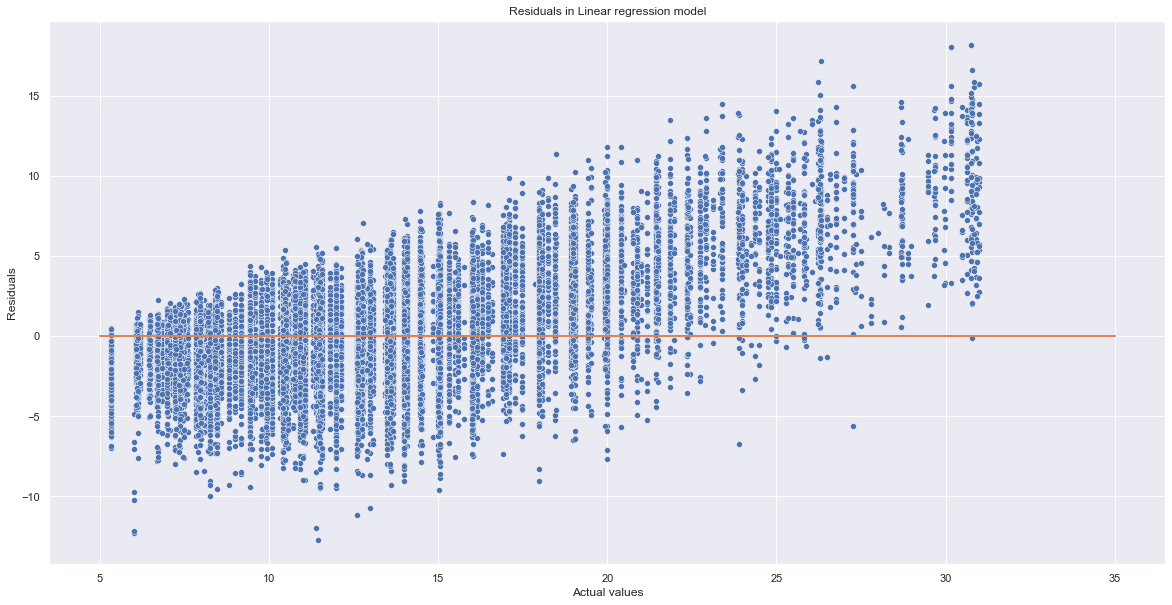

In [91]:
one_hot_columns = ["term", "verification_status", "initial_list_status", "disbursement_method", "purpose", "home_ownership", "application_type"]
    
    
OneHotPipeline = ColumnTransformer(
    [
        ("one_hot_columns",OneHotEncoder(drop="first", handle_unknown="ignore"), one_hot_columns)
    ], remainder="passthrough"
)


Preprocessor = Pipeline(
    [
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
        ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
        ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize="all")),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline)
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", RobustScaler()),
        ("model", xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 42)),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    temp_df, temp_df_target, test_size=0.2, random_state=42
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([5, 35], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [92]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5813980129436152

We get an r2 score of 0.58. If we look at the residual graph we can see, that the model struggles to predict the higher interest rates, due to lower amount of data - we saw the same trend for predicting grade. 

In [28]:
def objective_booster(trial, X: pd.DataFrame, y: pd.Series):
    

    
    scalers = trial.suggest_categorical("scaler", ["MinMax", "Standard", "Robust"])
    if scalers == "MinMax":
        scaler = MinMaxScaler()
    elif scalers == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
        
    state = trial.suggest_categorical("state", [True, False])
    binarize = trial.suggest_categorical("binarize", ["none", "some", "all"])

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.7)
    n_estimators = trial.suggest_int("n_estimators", 10, 300)
    max_depth = trial.suggest_int("max_depth", 2, 6, log=True)
    min_impurity_decrease = trial.suggest_float(
        "min_impurity_decrease", 1e-10, 0.1
    )
    
    one_hot_columns = ["term", "verification_status", "initial_list_status", "disbursement_method", "purpose", "home_ownership", "application_type"]
    
    
    OneHotPipeline = ColumnTransformer(
        [
            ("one_hot_columns",OneHotEncoder(drop="first", handle_unknown="ignore"), one_hot_columns)
        ], remainder="passthrough"
    )

    Preprocessor = Pipeline(
        [
            ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=state)),
            ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
            ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
            ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize=binarize)),
            ("log_transform", TransformToLog(skewed_columns)),
            ("one_hot_encode", OneHotPipeline)
        ]
    )
    
    full_pipe = Pipeline(
        [
            ("preprocessor", Preprocessor),
            ("scaler", scaler),
            (
                "model", 
                 xg.XGBRegressor(
                    learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_impurity_decrease=min_impurity_decrease,
                    tree_method='gpu_hist',
                ),
            ),
        ]
    )

    models[trial.number] = full_pipe
    score = cross_val_score(
        full_pipe,
        X,
        y,
        n_jobs=-1,
        cv=5,
        scoring="r2",
        verbose=30,
    )
    score = pd.Series(score).fillna(0)
    print(score)
    r2 = score.mean()
    return r2

In [ ]:
models = {}
grade_wrapper = lambda trial: objective_booster(
    trial, temp_df, temp_df_target
)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(grade_wrapper, n_trials=200)
joblib.dump(optuna_booster, "optuna_int_rate.pkl")

[I 2022-10-14 22:09:07,932] A new study created in memory with name: no-name-8c92cdf7-99ac-4b63-b180-5c2acd6ada91
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.3s remaining:   38.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:10:23,741] Trial 0 finished with value: 0.5958518817470939 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.4371725996295432, 'n_estimators': 122, 'max_depth': 2, 'min_impurity_decrease': 0.054488014807840456}. Best is trial 0 with value: 0.5958518817470939.


0    0.596568
1    0.597707
2    0.596132
3    0.592854
4    0.595998
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   55.1s remaining:   36.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:11:40,545] Trial 1 finished with value: 0.6004381835287654 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.13365067156003618, 'n_estimators': 280, 'max_depth': 4, 'min_impurity_decrease': 0.09924032752065577}. Best is trial 1 with value: 0.6004381835287654.


0    0.601470
1    0.601702
2    0.599674
3    0.597864
4    0.601482
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.0s remaining:   38.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:12:59,253] Trial 2 finished with value: 0.6006123951609299 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'all', 'learning_rate': 0.1461043370716394, 'n_estimators': 233, 'max_depth': 5, 'min_impurity_decrease': 0.06689811395652831}. Best is trial 2 with value: 0.6006123951609299.


0    0.601244
1    0.602138
2    0.600030
3    0.598055
4    0.601595
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   44.2s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[I 2022-10-14 22:14:01,174] Trial 3 finished with value: 0.6053040170893118 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.6884570496592716, 'n_estimators': 100, 'max_depth': 2, 'min_impurity_decrease': 0.08491807721304573}. Best is trial 3 with value: 0.6053040170893118.


0    0.606112
1    0.607090
2    0.604604
3    0.602679
4    0.606035
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.1s remaining:   32.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[I 2022-10-14 22:15:10,137] Trial 4 finished with value: 0.5978937137018596 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.26756887850677835, 'n_estimators': 118, 'max_depth': 3, 'min_impurity_decrease': 0.031793054610970116}. Best is trial 3 with value: 0.6053040170893118.


0    0.598251
1    0.599800
2    0.597649
3    0.595124
4    0.598645
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   51.0s remaining:   33.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:16:21,248] Trial 5 finished with value: 0.5982201336183034 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'all', 'learning_rate': 0.1770293474031233, 'n_estimators': 78, 'max_depth': 5, 'min_impurity_decrease': 0.06854681611462274}. Best is trial 3 with value: 0.6053040170893118.


0    0.599260
1    0.600026
2    0.597309
3    0.595602
4    0.598904
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   48.5s remaining:   32.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[I 2022-10-14 22:17:29,530] Trial 6 finished with value: 0.6084099332260732 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.38865261976115784, 'n_estimators': 109, 'max_depth': 3, 'min_impurity_decrease': 0.03496019194904148}. Best is trial 6 with value: 0.6084099332260732.


0    0.608816
1    0.610195
2    0.607683
3    0.606720
4    0.608635
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   48.0s remaining:   32.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[I 2022-10-14 22:18:36,328] Trial 7 finished with value: 0.6008227302791646 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.6171059442702514, 'n_estimators': 34, 'max_depth': 2, 'min_impurity_decrease': 0.023946071237932378}. Best is trial 6 with value: 0.6084099332260732.


0    0.602023
1    0.602182
2    0.600032
3    0.597827
4    0.602050
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   51.6s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:19:48,559] Trial 8 finished with value: 0.6092565983519466 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'all', 'learning_rate': 0.5659721182774367, 'n_estimators': 153, 'max_depth': 3, 'min_impurity_decrease': 0.07769092684226173}. Best is trial 8 with value: 0.6092565983519466.


0    0.608827
1    0.612443
2    0.608275
3    0.606930
4    0.609809
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   44.4s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[I 2022-10-14 22:20:50,597] Trial 9 finished with value: -0.2663332313118093 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'none', 'learning_rate': 0.050442372162615504, 'n_estimators': 20, 'max_depth': 2, 'min_impurity_decrease': 0.04135474085007746}. Best is trial 8 with value: 0.6092565983519466.


0   -0.264537
1   -0.266989
2   -0.266937
3   -0.270014
4   -0.263189
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   52.1s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:22:03,395] Trial 10 finished with value: 0.6081291289714181 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.52795861442956, 'n_estimators': 189, 'max_depth': 4, 'min_impurity_decrease': 0.007667081341821598}. Best is trial 8 with value: 0.6092565983519466.


0    0.609299
1    0.609714
2    0.607337
3    0.604690
4    0.609605
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.4s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:23:12,924] Trial 11 finished with value: 0.6095778514841308 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.38316913178831974, 'n_estimators': 163, 'max_depth': 3, 'min_impurity_decrease': 0.054538978605353394}. Best is trial 11 with value: 0.6095778514841308.


0    0.609588
1    0.610949
2    0.609189
3    0.607596
4    0.610567
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   50.6s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:24:23,172] Trial 12 finished with value: 0.6102100207093614 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.5162697607315972, 'n_estimators': 180, 'max_depth': 3, 'min_impurity_decrease': 0.07241256620572242}. Best is trial 12 with value: 0.6102100207093614.


0    0.610983
1    0.612401
2    0.609807
3    0.607302
4    0.610557
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   51.7s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:25:35,477] Trial 13 finished with value: 0.6094038129678827 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.4684657073776899, 'n_estimators': 199, 'max_depth': 4, 'min_impurity_decrease': 0.05627849884778537}. Best is trial 12 with value: 0.6102100207093614.


0    0.611131
1    0.610893
2    0.608515
3    0.607061
4    0.609420
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   59.7s remaining:   39.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 22:26:57,625] Trial 14 finished with value: 0.60775693806654 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.29601678319942976, 'n_estimators': 239, 'max_depth': 6, 'min_impurity_decrease': 0.09036328404497518}. Best is trial 12 with value: 0.6102100207093614.


0    0.608406
1    0.608569
2    0.606417
3    0.606086
4    0.609307
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.8s remaining:   33.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:28:07,390] Trial 15 finished with value: 0.6102072538754304 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.3374698822942548, 'n_estimators': 171, 'max_depth': 3, 'min_impurity_decrease': 0.06740505657685715}. Best is trial 12 with value: 0.6102100207093614.


0    0.610582
1    0.611959
2    0.609774
3    0.607811
4    0.610911
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   50.9s remaining:   33.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:29:18,574] Trial 16 finished with value: 0.6128191154207648 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.29807070416116943, 'n_estimators': 220, 'max_depth': 4, 'min_impurity_decrease': 0.07040438844685426}. Best is trial 16 with value: 0.6128191154207648.


0    0.612318
1    0.614677
2    0.612780
3    0.610514
4    0.613807
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   54.0s remaining:   35.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:30:33,328] Trial 17 finished with value: 0.6137875279101165 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.23644192904770422, 'n_estimators': 295, 'max_depth': 4, 'min_impurity_decrease': 0.07779616887908401}. Best is trial 17 with value: 0.6137875279101165.


0    0.613942
1    0.615335
2    0.612706
3    0.612286
4    0.614670
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.4s remaining:   38.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:31:52,680] Trial 18 finished with value: 0.6136013103923083 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.2404422869782431, 'n_estimators': 298, 'max_depth': 5, 'min_impurity_decrease': 0.08325587751466905}. Best is trial 17 with value: 0.6137875279101165.


0    0.613748
1    0.614814
2    0.613207
3    0.611331
4    0.614907
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 22:33:17,612] Trial 19 finished with value: 0.610959847023975 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.2301880132986898, 'n_estimators': 299, 'max_depth': 6, 'min_impurity_decrease': 0.09891928380004344}. Best is trial 17 with value: 0.6137875279101165.


0    0.612991
1    0.611476
2    0.609452
3    0.609973
4    0.610909
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.0s remaining:   38.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:34:35,926] Trial 20 finished with value: 0.6115472582341468 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.06745137152009417, 'n_estimators': 263, 'max_depth': 5, 'min_impurity_decrease': 0.08481088172642592}. Best is trial 17 with value: 0.6137875279101165.


0    0.611988
1    0.613080
2    0.610800
3    0.609759
4    0.612109
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   52.2s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:35:48,455] Trial 21 finished with value: 0.6129556009262638 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.24856023099772082, 'n_estimators': 232, 'max_depth': 4, 'min_impurity_decrease': 0.07786904292480142}. Best is trial 17 with value: 0.6137875279101165.


0    0.613658
1    0.614503
2    0.611662
3    0.610721
4    0.614234
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   58.0s remaining:   38.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:37:07,990] Trial 22 finished with value: 0.6143449065340014 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.20454347795797118, 'n_estimators': 300, 'max_depth': 5, 'min_impurity_decrease': 0.08060506524081004}. Best is trial 22 with value: 0.6143449065340014.


0    0.615128
1    0.616290
2    0.613389
3    0.611995
4    0.614923
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.9s remaining:   37.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:38:27,226] Trial 23 finished with value: 0.6138884901689023 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1943676538316586, 'n_estimators': 297, 'max_depth': 5, 'min_impurity_decrease': 0.09312637104337641}. Best is trial 22 with value: 0.6143449065340014.


0    0.614421
1    0.615349
2    0.613117
3    0.612124
4    0.614432
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.1min remaining:   42.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 22:39:53,978] Trial 24 finished with value: -1.2483094860749804 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.0023896439265228275, 'n_estimators': 267, 'max_depth': 6, 'min_impurity_decrease': 0.09146612751209802}. Best is trial 22 with value: 0.6143449065340014.


0   -1.238979
1   -1.246546
2   -1.251762
3   -1.257575
4   -1.246685
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   55.3s remaining:   36.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:41:10,923] Trial 25 finished with value: 0.614215851009144 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.18724656263006073, 'n_estimators': 258, 'max_depth': 5, 'min_impurity_decrease': 0.09259556705050631}. Best is trial 22 with value: 0.6143449065340014.


0    0.614095
1    0.616068
2    0.613418
3    0.612410
4    0.615088
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.2s remaining:   37.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:42:28,587] Trial 26 finished with value: 0.6132795444988369 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.10743886095993407, 'n_estimators': 259, 'max_depth': 5, 'min_impurity_decrease': 0.09195826762141494}. Best is trial 22 with value: 0.6143449065340014.


0    0.613662
1    0.614802
2    0.612180
3    0.611540
4    0.614214
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   59.8s remaining:   39.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 22:43:50,665] Trial 27 finished with value: 0.6137500621506355 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.17577064580941165, 'n_estimators': 252, 'max_depth': 6, 'min_impurity_decrease': 0.09820509348536795}. Best is trial 22 with value: 0.6143449065340014.


0    0.614613
1    0.614502
2    0.612919
3    0.611545
4    0.615172
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   54.2s remaining:   36.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:45:05,818] Trial 28 finished with value: 0.6137117427581396 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.18558515421991104, 'n_estimators': 210, 'max_depth': 5, 'min_impurity_decrease': 0.05999173892853729}. Best is trial 22 with value: 0.6143449065340014.


0    0.613804
1    0.615175
2    0.613129
3    0.611561
4    0.614888
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.0s remaining:   37.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:46:24,372] Trial 29 finished with value: 0.6005517946598837 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'none', 'learning_rate': 0.08735755256672256, 'n_estimators': 277, 'max_depth': 6, 'min_impurity_decrease': 0.08845992557223376}. Best is trial 22 with value: 0.6143449065340014.


0    0.601169
1    0.602158
2    0.599830
3    0.598002
4    0.601600
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   53.1s remaining:   35.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:47:37,623] Trial 30 finished with value: 0.6049858501919815 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.01855774239043753, 'n_estimators': 277, 'max_depth': 5, 'min_impurity_decrease': 0.0944129577621215}. Best is trial 22 with value: 0.6143449065340014.


0    0.605665
1    0.606392
2    0.604598
3    0.602566
4    0.605708
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   54.0s remaining:   36.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:48:52,688] Trial 31 finished with value: 0.6133534924783007 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.20753979629148864, 'n_estimators': 300, 'max_depth': 4, 'min_impurity_decrease': 0.08036629877839849}. Best is trial 22 with value: 0.6143449065340014.


0    0.613415
1    0.615350
2    0.612609
3    0.610848
4    0.614546
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   53.2s remaining:   35.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:50:06,880] Trial 32 finished with value: 0.6125588588740574 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.145198625108794, 'n_estimators': 285, 'max_depth': 4, 'min_impurity_decrease': 0.0754552968981289}. Best is trial 22 with value: 0.6143449065340014.


0    0.612810
1    0.614233
2    0.611759
3    0.610773
4    0.613219
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   54.7s remaining:   36.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:51:22,775] Trial 33 finished with value: 0.6105685209661098 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.32614935818149793, 'n_estimators': 249, 'max_depth': 5, 'min_impurity_decrease': 0.04582834471223192}. Best is trial 22 with value: 0.6143449065340014.


0    0.611195
1    0.610943
2    0.609259
3    0.610095
4    0.611351
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   55.9s remaining:   37.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:52:39,921] Trial 34 finished with value: 0.6005466165153442 and parameters: {'scaler': 'Robust', 'state': False, 'binarize': 'some', 'learning_rate': 0.12627256566348535, 'n_estimators': 283, 'max_depth': 4, 'min_impurity_decrease': 0.06214809348186766}. Best is trial 22 with value: 0.6143449065340014.


0    0.601399
1    0.602341
2    0.599881
3    0.597628
4    0.601484
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   51.0s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 22:53:51,179] Trial 35 finished with value: 0.6124078325359026 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.2875501591695473, 'n_estimators': 137, 'max_depth': 5, 'min_impurity_decrease': 0.08378603023362016}. Best is trial 22 with value: 0.6143449065340014.


0    0.612967
1    0.613664
2    0.611670
3    0.610529
4    0.613209
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 22:55:15,883] Trial 36 finished with value: 0.5968098566870126 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.2115587623999414, 'n_estimators': 284, 'max_depth': 6, 'min_impurity_decrease': 0.09977580884400472}. Best is trial 22 with value: 0.6143449065340014.


0    0.597709
1    0.597990
2    0.596666
3    0.594566
4    0.597118
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.1s remaining:   38.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 22:56:35,067] Trial 37 finished with value: 0.6137350641610704 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.16194480447024767, 'n_estimators': 225, 'max_depth': 5, 'min_impurity_decrease': 0.08710293709940341}. Best is trial 22 with value: 0.6143449065340014.


0    0.614316
1    0.614946
2    0.612989
3    0.612061
4    0.614364
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   47.4s remaining:   31.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[I 2022-10-14 22:57:41,060] Trial 38 finished with value: 0.6120198052982824 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'none', 'learning_rate': 0.38009629232112924, 'n_estimators': 243, 'max_depth': 4, 'min_impurity_decrease': 0.06316521980578578}. Best is trial 22 with value: 0.6143449065340014.


0    0.612482
1    0.612981
2    0.611251
3    0.610289
4    0.613096
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 22:59:04,853] Trial 39 finished with value: 0.5935525659459513 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.267692052349001, 'n_estimators': 268, 'max_depth': 6, 'min_impurity_decrease': 0.07422698597106496}. Best is trial 22 with value: 0.6143449065340014.


0    0.595297
1    0.594205
2    0.592592
3    0.591202
4    0.594466
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.5s remaining:   37.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:00:23,021] Trial 40 finished with value: 0.6137396766063574 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1076837699226359, 'n_estimators': 289, 'max_depth': 5, 'min_impurity_decrease': 0.08074728961906014}. Best is trial 22 with value: 0.6143449065340014.


0    0.614252
1    0.615172
2    0.612762
3    0.612127
4    0.614385
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   59.6s remaining:   39.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:01:45,114] Trial 41 finished with value: 0.6134007442035204 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.16751670095545063, 'n_estimators': 253, 'max_depth': 6, 'min_impurity_decrease': 0.09757442635619967}. Best is trial 22 with value: 0.6143449065340014.


0    0.613889
1    0.614750
2    0.612317
3    0.611822
4    0.614225
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:03:08,949] Trial 42 finished with value: 0.6136446531648942 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.19365905724119017, 'n_estimators': 270, 'max_depth': 6, 'min_impurity_decrease': 0.09464880793828243}. Best is trial 22 with value: 0.6143449065340014.


0    0.613933
1    0.615001
2    0.612281
3    0.611662
4    0.615346
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   55.4s remaining:   36.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:04:25,919] Trial 43 finished with value: 0.6138839330119751 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.1398025300542458, 'n_estimators': 254, 'max_depth': 5, 'min_impurity_decrease': 0.08784789991570287}. Best is trial 22 with value: 0.6143449065340014.


0    0.614737
1    0.614678
2    0.613130
3    0.612077
4    0.614798
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.0s remaining:   38.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:05:44,496] Trial 44 finished with value: 0.6143510304735503 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.13300148260601372, 'n_estimators': 300, 'max_depth': 5, 'min_impurity_decrease': 0.08748243153571683}. Best is trial 44 with value: 0.6143510304735503.


0    0.615130
1    0.615331
2    0.613063
3    0.612247
4    0.615984
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   50.0s remaining:   33.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 23:06:54,107] Trial 45 finished with value: 0.6053072087176081 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.06393069601518564, 'n_estimators': 80, 'max_depth': 5, 'min_impurity_decrease': 0.08790888461853204}. Best is trial 44 with value: 0.6143510304735503.


0    0.606040
1    0.606625
2    0.604821
3    0.602935
4    0.606114
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.2s remaining:   32.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[I 2022-10-14 23:08:02,748] Trial 46 finished with value: 0.6128941782422398 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.12936792207567613, 'n_estimators': 207, 'max_depth': 5, 'min_impurity_decrease': 0.09323795335688202}. Best is trial 44 with value: 0.6143510304735503.


0    0.613672
1    0.614113
2    0.611677
3    0.611137
4    0.613872
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.2s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:09:20,541] Trial 47 finished with value: 0.5977555577011555 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.03968657470871434, 'n_estimators': 276, 'max_depth': 5, 'min_impurity_decrease': 0.015197193112191774}. Best is trial 44 with value: 0.6143510304735503.


0    0.598509
1    0.599622
2    0.597078
3    0.595118
4    0.598451
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.8s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 23:10:30,345] Trial 48 finished with value: 0.6031841057452128 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.08866110425681936, 'n_estimators': 232, 'max_depth': 2, 'min_impurity_decrease': 0.0813168248457717}. Best is trial 44 with value: 0.6143510304735503.


0    0.603826
1    0.604688
2    0.602816
3    0.600523
4    0.604067
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.9s remaining:   37.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:11:49,330] Trial 49 finished with value: 0.5845761897216799 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.6990780327738129, 'n_estimators': 256, 'max_depth': 5, 'min_impurity_decrease': 0.029349199661105656}. Best is trial 44 with value: 0.6143510304735503.


0    0.586656
1    0.587081
2    0.581152
3    0.582596
4    0.585396
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   53.9s remaining:   35.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 23:13:04,156] Trial 50 finished with value: 0.6126620735851909 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.14497067964668162, 'n_estimators': 288, 'max_depth': 4, 'min_impurity_decrease': 0.0001612254334298971}. Best is trial 44 with value: 0.6143510304735503.


0    0.612520
1    0.614272
2    0.612175
3    0.610707
4    0.613636
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   52.5s remaining:   34.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 23:14:17,712] Trial 51 finished with value: 0.6136871320180416 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'some', 'learning_rate': 0.24410795417642484, 'n_estimators': 299, 'max_depth': 4, 'min_impurity_decrease': 0.08698474043373235}. Best is trial 44 with value: 0.6143510304735503.


0    0.613502
1    0.615541
2    0.613028
3    0.611975
4    0.614388
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.2s remaining:   38.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:15:36,252] Trial 52 finished with value: 0.6140928460880933 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.21513854702615748, 'n_estimators': 288, 'max_depth': 5, 'min_impurity_decrease': 0.07714946143231236}. Best is trial 44 with value: 0.6143510304735503.


0    0.615061
1    0.614646
2    0.613008
3    0.612478
4    0.615271
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.6s remaining:   37.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:16:54,241] Trial 53 finished with value: 0.6138545959689697 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.21514582205149008, 'n_estimators': 269, 'max_depth': 5, 'min_impurity_decrease': 0.0710002271585485}. Best is trial 44 with value: 0.6143510304735503.


0    0.614554
1    0.614424
2    0.613097
3    0.612591
4    0.614608
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:18:19,299] Trial 54 finished with value: 0.6076570186333712 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'all', 'learning_rate': 0.2719242219362742, 'n_estimators': 289, 'max_depth': 6, 'min_impurity_decrease': 0.09389974823377328}. Best is trial 44 with value: 0.6143510304735503.


0    0.607771
1    0.608040
2    0.607453
3    0.607036
4    0.607986
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.5s remaining:   37.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:19:37,822] Trial 55 finished with value: 0.5920168866740451 and parameters: {'scaler': 'Robust', 'state': True, 'binarize': 'some', 'learning_rate': 0.6255124109341883, 'n_estimators': 243, 'max_depth': 5, 'min_impurity_decrease': 0.08450764849336666}. Best is trial 44 with value: 0.6143510304735503.


0    0.591450
1    0.592884
2    0.590484
3    0.590616
4    0.594650
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.0s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:20:54,888] Trial 56 finished with value: 0.6053728169911698 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.43534568355572445, 'n_estimators': 262, 'max_depth': 5, 'min_impurity_decrease': 0.06735143461852064}. Best is trial 44 with value: 0.6143510304735503.


0    0.607420
1    0.607588
2    0.602316
3    0.603014
4    0.606527
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:22:20,094] Trial 57 finished with value: 0.6060344406273899 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.3082383826634936, 'n_estimators': 273, 'max_depth': 6, 'min_impurity_decrease': 0.07719412146994858}. Best is trial 44 with value: 0.6143510304735503.


0    0.606397
1    0.606687
2    0.606431
3    0.602693
4    0.607964
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   48.3s remaining:   32.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[I 2022-10-14 23:23:27,703] Trial 58 finished with value: 0.6100538327188513 and parameters: {'scaler': 'MinMax', 'state': True, 'binarize': 'none', 'learning_rate': 0.1657124131201277, 'n_estimators': 290, 'max_depth': 3, 'min_impurity_decrease': 0.08973404024232472}. Best is trial 44 with value: 0.6143510304735503.


0    0.610312
1    0.611694
2    0.609522
3    0.607948
4    0.610794
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   48.2s remaining:   32.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[I 2022-10-14 23:24:35,521] Trial 59 finished with value: 0.6052400157298233 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.11186545441629972, 'n_estimators': 46, 'max_depth': 5, 'min_impurity_decrease': 0.07256892050618244}. Best is trial 44 with value: 0.6143510304735503.


0    0.606020
1    0.606684
2    0.604893
3    0.602650
4    0.605953
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.8s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:25:55,121] Trial 60 finished with value: 0.5985024890854487 and parameters: {'scaler': 'MinMax', 'state': False, 'binarize': 'some', 'learning_rate': 0.19008747904292447, 'n_estimators': 221, 'max_depth': 6, 'min_impurity_decrease': 0.04977302763934423}. Best is trial 44 with value: 0.6143510304735503.


0    0.598487
1    0.600235
2    0.597744
3    0.596909
4    0.599137
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   55.9s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:27:12,588] Trial 61 finished with value: 0.613954001619343 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.20279005216118354, 'n_estimators': 264, 'max_depth': 5, 'min_impurity_decrease': 0.08180285985790045}. Best is trial 44 with value: 0.6143510304735503.


0    0.614579
1    0.615516
2    0.612604
3    0.612468
4    0.614603
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.7s remaining:   37.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:28:31,107] Trial 62 finished with value: 0.6142101933212805 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.22055404482499358, 'n_estimators': 300, 'max_depth': 5, 'min_impurity_decrease': 0.09058265658100353}. Best is trial 44 with value: 0.6143510304735503.


0    0.615232
1    0.615336
2    0.613052
3    0.612336
4    0.615095
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   55.4s remaining:   36.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:29:48,133] Trial 63 finished with value: 0.6134223626892944 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.2236484247484652, 'n_estimators': 281, 'max_depth': 5, 'min_impurity_decrease': 0.07959607661270465}. Best is trial 44 with value: 0.6143510304735503.


0    0.613540
1    0.615297
2    0.612613
3    0.611539
4    0.614122
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   57.4s remaining:   38.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:31:07,239] Trial 64 finished with value: 0.6129587042789509 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.26137223056437997, 'n_estimators': 296, 'max_depth': 5, 'min_impurity_decrease': 0.0962146532463893}. Best is trial 44 with value: 0.6143510304735503.


0    0.612922
1    0.614569
2    0.611535
3    0.611873
4    0.613895
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:32:32,548] Trial 65 finished with value: 0.6126534082681783 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.19999268748177476, 'n_estimators': 299, 'max_depth': 6, 'min_impurity_decrease': 0.09064377369989848}. Best is trial 44 with value: 0.6143510304735503.


0    0.613058
1    0.614119
2    0.611363
3    0.611369
4    0.613358
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   52.8s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 23:33:45,998] Trial 66 finished with value: 0.6121270505780376 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.355561874009541, 'n_estimators': 278, 'max_depth': 4, 'min_impurity_decrease': 0.08384912531622431}. Best is trial 44 with value: 0.6143510304735503.


0    0.611876
1    0.613905
2    0.610892
3    0.611144
4    0.612818
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.6s remaining:   37.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:35:03,933] Trial 67 finished with value: 0.6137018265875327 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.23076305468585537, 'n_estimators': 262, 'max_depth': 5, 'min_impurity_decrease': 0.07567026052639615}. Best is trial 44 with value: 0.6143510304735503.


0    0.614113
1    0.614951
2    0.612555
3    0.612287
4    0.614603
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.2s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:36:22,498] Trial 68 finished with value: 0.614038767250153 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1596970231702164, 'n_estimators': 292, 'max_depth': 5, 'min_impurity_decrease': 0.091590493732283}. Best is trial 44 with value: 0.6143510304735503.


0    0.614226
1    0.615533
2    0.612873
3    0.612755
4    0.614806
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:37:47,564] Trial 69 finished with value: 0.6139648573400536 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.0826960637279683, 'n_estimators': 286, 'max_depth': 6, 'min_impurity_decrease': 0.08101658264982851}. Best is trial 44 with value: 0.6143510304735503.


0    0.614104
1    0.615077
2    0.613183
3    0.612570
4    0.614890
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:39:13,175] Trial 70 finished with value: 0.6133265431913358 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'all', 'learning_rate': 0.08692137171927253, 'n_estimators': 289, 'max_depth': 6, 'min_impurity_decrease': 0.09643592037936276}. Best is trial 44 with value: 0.6143510304735503.


0    0.614643
1    0.615012
2    0.612123
3    0.610967
4    0.613887
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:40:37,628] Trial 71 finished with value: 0.6142113082691236 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.16074483773532902, 'n_estimators': 276, 'max_depth': 6, 'min_impurity_decrease': 0.08180548610007916}. Best is trial 44 with value: 0.6143510304735503.


0    0.615788
1    0.615485
2    0.612948
3    0.612128
4    0.614707
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:42:01,159] Trial 72 finished with value: 0.6140673140670918 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.16427924183275688, 'n_estimators': 280, 'max_depth': 6, 'min_impurity_decrease': 0.08588018566795877}. Best is trial 44 with value: 0.6143510304735503.


0    0.614894
1    0.614862
2    0.613156
3    0.612129
4    0.615295
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:43:24,799] Trial 73 finished with value: 0.613595185768595 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1712854993185171, 'n_estimators': 276, 'max_depth': 6, 'min_impurity_decrease': 0.08555181152430973}. Best is trial 44 with value: 0.6143510304735503.


0    0.613916
1    0.615343
2    0.611931
3    0.612751
4    0.614035
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.0s remaining:   37.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[I 2022-10-14 23:44:42,469] Trial 74 finished with value: 0.6136802948086497 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.12057262172692182, 'n_estimators': 188, 'max_depth': 6, 'min_impurity_decrease': 0.09014025682351014}. Best is trial 44 with value: 0.6143510304735503.


0    0.614640
1    0.614683
2    0.612619
3    0.612141
4    0.614319
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:46:07,461] Trial 75 finished with value: 0.6143184648190857 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.1567907804453221, 'n_estimators': 292, 'max_depth': 6, 'min_impurity_decrease': 0.09212563813416941}. Best is trial 44 with value: 0.6143510304735503.


0    0.614873
1    0.615468
2    0.613095
3    0.613189
4    0.614968
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   40.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:47:31,402] Trial 76 finished with value: 0.6144624200029832 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.14440203950280733, 'n_estimators': 280, 'max_depth': 6, 'min_impurity_decrease': 0.0785584686621025}. Best is trial 76 with value: 0.6144624200029832.


0    0.614696
1    0.616058
2    0.613592
3    0.612920
4    0.615046
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   53.7s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[I 2022-10-14 23:48:46,454] Trial 77 finished with value: 0.6131458700176726 and parameters: {'scaler': 'Standard', 'state': True, 'binarize': 'some', 'learning_rate': 0.15133882323454598, 'n_estimators': 138, 'max_depth': 6, 'min_impurity_decrease': 0.07837256905336815}. Best is trial 76 with value: 0.6144624200029832.


0    0.613564
1    0.614905
2    0.612123
3    0.610991
4    0.614147
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[I 2022-10-14 23:50:11,718] Trial 78 finished with value: 0.5981681284652725 and parameters: {'scaler': 'Standard', 'state': False, 'binarize': 'some', 'learning_rate': 0.18018255666731287, 'n_estimators': 300, 'max_depth': 6, 'min_impurity_decrease': 0.06920275476111103}. Best is trial 76 with value: 0.6144624200029832.


0    0.598474
1    0.599747
2    0.598323
3    0.595221
4    0.599075
dtype: float64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


We get a slightly better r2 value - 0.61446. Let's train the model using all of the data.

In [34]:
temp_df = train_set.copy()

In [35]:
temp_df_target = temp_df["int_rate"]
#temp_df = temp_df.drop(["int_rate"], axis=1)
temp_df = temp_df.drop(["int_rate", "sub_grade"], axis=1)

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[09:57:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




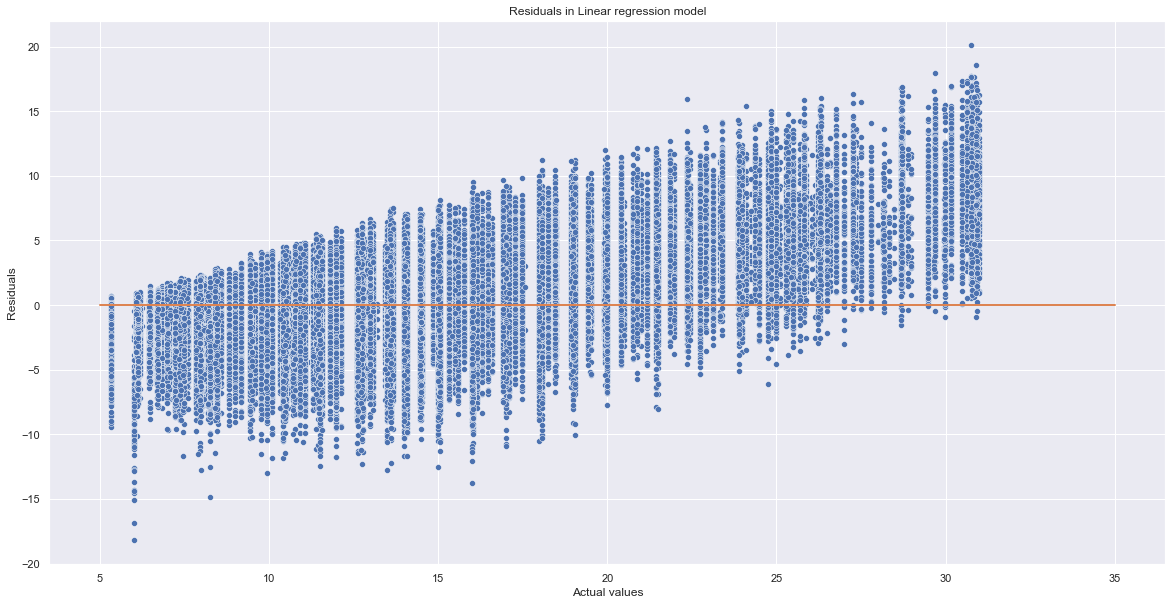

In [37]:
one_hot_columns = ["term", "verification_status", "initial_list_status", "disbursement_method", "purpose", "home_ownership", "application_type"]
    
    
OneHotPipeline = ColumnTransformer(
    [
        ("one_hot_columns",OneHotEncoder(drop="first", handle_unknown="ignore"), one_hot_columns)
    ], remainder="passthrough"
)


Preprocessor = Pipeline(
    [
        ("zip_to_coords", ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True)),
        ("careers",FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title")),
        ("filter_values_columns",SmallValuesToOther(["purpose", "home_ownership"])),
        ("fill_missing_data", FillMissingDataAccepted(best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop, binarize="some")),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline)
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", StandardScaler()),
        ("model", xg.XGBRegressor(objective ='reg:squarederror', seed = 42, learning_rate=0.1444, n_estimators=280, max_depth=6, min_impurity_decrease=0.078558)),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    temp_df, temp_df_target, test_size=0.2, random_state=42
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([5, 35], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [38]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.6238755643046976

Using the whole dataset we get an even better r2 score.

In [39]:
joblib.dump(full_pipe, "int_rate_model_tuned.pkl")

['int_rate_model_tuned.pkl']

In [40]:
int_rate_pipe = joblib.load("int_rate_model_tuned.pkl")

## Testing

In [57]:
r2_score(test_set["grade"], grade_pipe.predict(test_set.drop(["grade", "sub_grade"], axis=1)))

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.5959248891425837

In [58]:
predictions = grade_pipe.predict(test_set.drop(["grade", "sub_grade"], axis=1))
predictions = np.round(predictions)
predictions[predictions<1] = 1
predictions[predictions>7] = 7

r2_score(test_set["grade"], predictions)

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.5417618292130579

In [59]:
subgrades = pd.Series(index=[i for i in range(1,8)], name="score")
for grade in test_set["grade"].unique():
    
    temp_df = test_set.loc[test_set["grade"]==grade]
    
    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
    
    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)
    
    sub_grade_pipe = joblib.load(f"trained_{grade}_sub_grades.pkl")
    
    r2_score(temp_df_target, grade_pipe.predict(temp_df))
    predictions = grade_pipe.predict(temp_df)
    predictions = np.round(predictions)
    predictions[predictions<1] = 1
    predictions[predictions>5] = 5
    
    subgrades[grade] = r2_score(temp_df_target, predictions)
    
subgrades

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2294241847.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  subgrades = pd.Series(index=[i for i in range(1,8)], name="score")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2294241847.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2294241847.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users

1   -0.926215
2   -0.228720
3   -0.010974
4   -0.327383
5   -0.469966
6   -1.534331
7   -1.693391
Name: score, dtype: float64

In [60]:
test_set

loan_amnt        term  grade  sub_grade                    emp_title  \
629244     13000.0   36 months      1         30          Executive Assistant   
1364231    12000.0   36 months      3         20                          NaN   
2068540     9500.0   36 months      2         28                Senior Airman   
2107862     6000.0   36 months      3         23     Randomization Specialist   
2222013    12000.0   36 months      2         29                          NaN   
...            ...         ...    ...        ...                          ...   
1960413    20000.0   60 months      2         27                         Cook   
487517      7000.0   36 months      2         29  Director of Shared Services   
2131242     9600.0   36 months      2         29             Business Analyst   
1446589    14000.0   36 months      1         32      Senior project engineer   
2136282    10000.0   36 months      1         30                   supervisor   

         emp_length_years home_ownership  annual_inc verification_status  \
629244                1.0       mortgage     32400.0        Not Verified   
1364231               0.0       mortgage    185000.0        Not Verified   
2068540               2.0           rent     42905.0     Source Verified   
2107862              15.0       mortgage     57000.0            Verified   
2222013               NaN            own     20000.0     Source Verified   
...                   ...            ...         ...                 ...   
1960413              15.0           rent     90000.0     Source Verified   
487517                4.0       mortgage    100000.0     Source Verified   
2131242               1.0           rent     80000.0        Not Verified   
1446589               2.0            own    175000.0        Not Verified   
2136282              15.0           rent     60000.0     Source Verified   

                    purpose  ... percent_bc_gt_75 pub_rec_bankruptcies  \
629244   debt_consolidation  ...              0.0                  0.0   
1364231               other  ...             60.0                  0.0   
2068540         credit_card  ...             50.0                  0.0   
2107862  debt_consolidation  ...            100.0                  0.0   
2222013               other  ...             33.3                  0.0   
...                     ...  ...              ...                  ...   
1960413  debt_consolidation  ...             20.0                  0.0   
487517          credit_card  ...             50.0                  0.0   
2131242  debt_consolidation  ...              0.0                  0.0   
1446589  debt_consolidation  ...              0.0                  0.0   
2136282               other  ...              0.0                  0.0   

         tax_liens  tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  \
629244         0.0         190566.0            14277.0         11600.0   
1364231        0.0          42100.0            35290.0         22700.0   
2068540        0.0          68255.0            47683.0         25000.0   
2107862        0.0         228210.0            30157.0         29100.0   
2222013        0.0         213810.0            34402.0         13500.0   
...            ...              ...                ...             ...   
1960413        0.0          53419.0            28979.0         22200.0   
487517         0.0         595982.0            54573.0         49700.0   
2131242        0.0          73541.0            37794.0         26700.0   
1446589        0.0          62761.0            15088.0         22400.0   
2136282        0.0          26000.0             2143.0          6000.0   

         total_il_high_credit_limit  disbursement_method  risk_score  \
629244                      20365.0                 Cash       742.0   
1364231                     15000.0                 Cash       707.0   
2068540                     42055.0                 Cash       732.0   
2107862                     18660.0                 Cash 

In [61]:
test_set["grade"] = grade_pipe.predict(test_set)
test_set.loc[:, "int_rate"] = int_rate

temp_df = test_set.copy()

temp_df_target = temp_df["int_rate"]
#temp_df = temp_df.drop(["int_rate"], axis=1)
temp_df = temp_df.drop(["int_rate", "sub_grade"], axis=1)

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [62]:
r2_score(temp_df_target, int_rate_pipe.predict(temp_df))

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6253064345694954

## Conclusions